## Displaying the Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from matplotlib.lines import Line2D

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL, MSTL

from ipywidgets import HBox, VBox, Checkbox, interactive_output

CSV_DIR = Path("bmrs_csv_filled") 

paths = {
    "imbalance": CSV_DIR / "SYSTEM_PRICES.csv",
    "mid":       CSV_DIR / "MID.csv",
    "agws":      CSV_DIR / "ACTUAL_GEN_WIND_SOLAR.csv",
    "dgws":      CSV_DIR / "DAYAHEAD_GEN_WIND_SOLAR.csv",
    "we":        CSV_DIR / "WIND_ERROR.csv",
    "ad":        CSV_DIR / "ACTUAL_DEMAND.csv",
    "dd":        CSV_DIR / "DAYAHEAD_DEMAND.csv",
    "inter":     CSV_DIR / "INTER.csv",
    "drm":       CSV_DIR / "LOLPDRM.csv"
}

df_imbalance = (pd.read_csv(paths["imbalance"], parse_dates=["startTime"]).set_index("startTime"))
df_mid       = (pd.read_csv(paths["mid"],       parse_dates=["startTime"]).set_index("startTime"))
df_agws      = (pd.read_csv(paths["agws"],      parse_dates=["startTime"]).set_index("startTime"))
df_dgws      = (pd.read_csv(paths["dgws"],      parse_dates=["startTime"]).set_index("startTime"))
df_we        = (pd.read_csv(paths["we"],        parse_dates=["startTime"]).set_index("startTime"))
df_ad        = (pd.read_csv(paths["ad"],        parse_dates=["startTime"]).set_index("startTime"))
df_dd        = (pd.read_csv(paths["dd"],        parse_dates=["startTime"]).set_index("startTime"))
df_inter     = (pd.read_csv(paths["inter"],     parse_dates=["startTime"]).set_index("startTime"))
df_drm       = (pd.read_csv(paths["drm"],       parse_dates=["startTime"]).set_index("startTime"))

# Settlement Period
settlement_period = df_mid["settlementPeriod"]

# System Prices, Market Prices, and Volumes
price       = df_imbalance["systemPrice"]
wholesale   = df_mid["price"]
diff        = price - wholesale
volume      = df_imbalance["netImbalanceVolume"]

# Wind & solar forecast errors
act_total_wind = (df_agws["windOnshoreGeneration"] + df_agws["windOffshoreGeneration"])
act_solar      = df_agws["solarGeneration"]

fc_total_wind  = df_dgws["windOnshoreGeneration"] + df_dgws["windOffshoreGeneration"]
fc_solar       = df_dgws["solarGeneration"]

wind_error    = df_we["windError"]
solar_error   = act_solar - fc_solar

# Demand forecast error
demand_error  = (df_ad["initialTransmissionSystemDemandOutturn"] - df_dd["transmissionSystemDemand"])

# Interconnector delta (in GW)
df_inter["totalInterGen"] = df_inter.filter(like="INT").sum(axis=1)
inter_delta = df_inter["totalInterGen"].diff().fillna(0)

# De-rated margin (1h, in GW)
drm_1h      = df_drm["1hDRM"]

# Combine into one DataFrame
df_all = pd.concat([
    settlement_period.rename("Settlement Period"),
    price.rename("Imbalance Price"),
    volume.rename("Imbalance Volume"),
    wholesale.rename("Market Index"),
    fc_total_wind.rename("Forecast Wind"),
    act_total_wind.rename("Actual Wind"),
    wind_error.rename("Wind Error"),
    fc_solar.rename("Forecast Solar"),
    act_solar.rename("Actual Solar"),
    solar_error.rename("Solar Error"),
    demand_error.rename("Demand Error"),
    drm_1h.rename("De-Rated Margin (1h)"),
    inter_delta.rename("Inter Delta")
], axis=1)

# Z-score normalised DataFrame
df_z = (df_all - df_all.mean()) / df_all.std()

# Tab colours for plotting
tab_colours = [
    "tab:blue", "tab:orange", "tab:green", "tab:red",
    "tab:purple", "tab:brown", "tab:pink", "tab:gray",
    "tab:olive", "tab:cyan"
]

print("Data loaded: df_all shape =", df_all.shape)

# Global Matplotlib configuration for publication‐quality figures
plt.rcParams.update({
    # Resolution
    "figure.dpi": 300,
    # Font
    "font.family": "Times New Roman",
    "mathtext.fontset": "stix",
    # Figure size (optional – adjust as needed)
    "figure.figsize": (10, 6),
    # Title and label font sizes
    "figure.titlesize": 18,    # overall figure title
    "axes.titlesize": 18,      # axes title
    "axes.labelsize": 14,      # x/y axis labels
    # Tick label size
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    # Legend
    "legend.fontsize": 12,
    # Line width (for plot lines)
    "lines.linewidth": 1.5,
    # Grid styling (optional)
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
})

Data loaded: df_all shape = (147502, 13)


### Imbalance Price

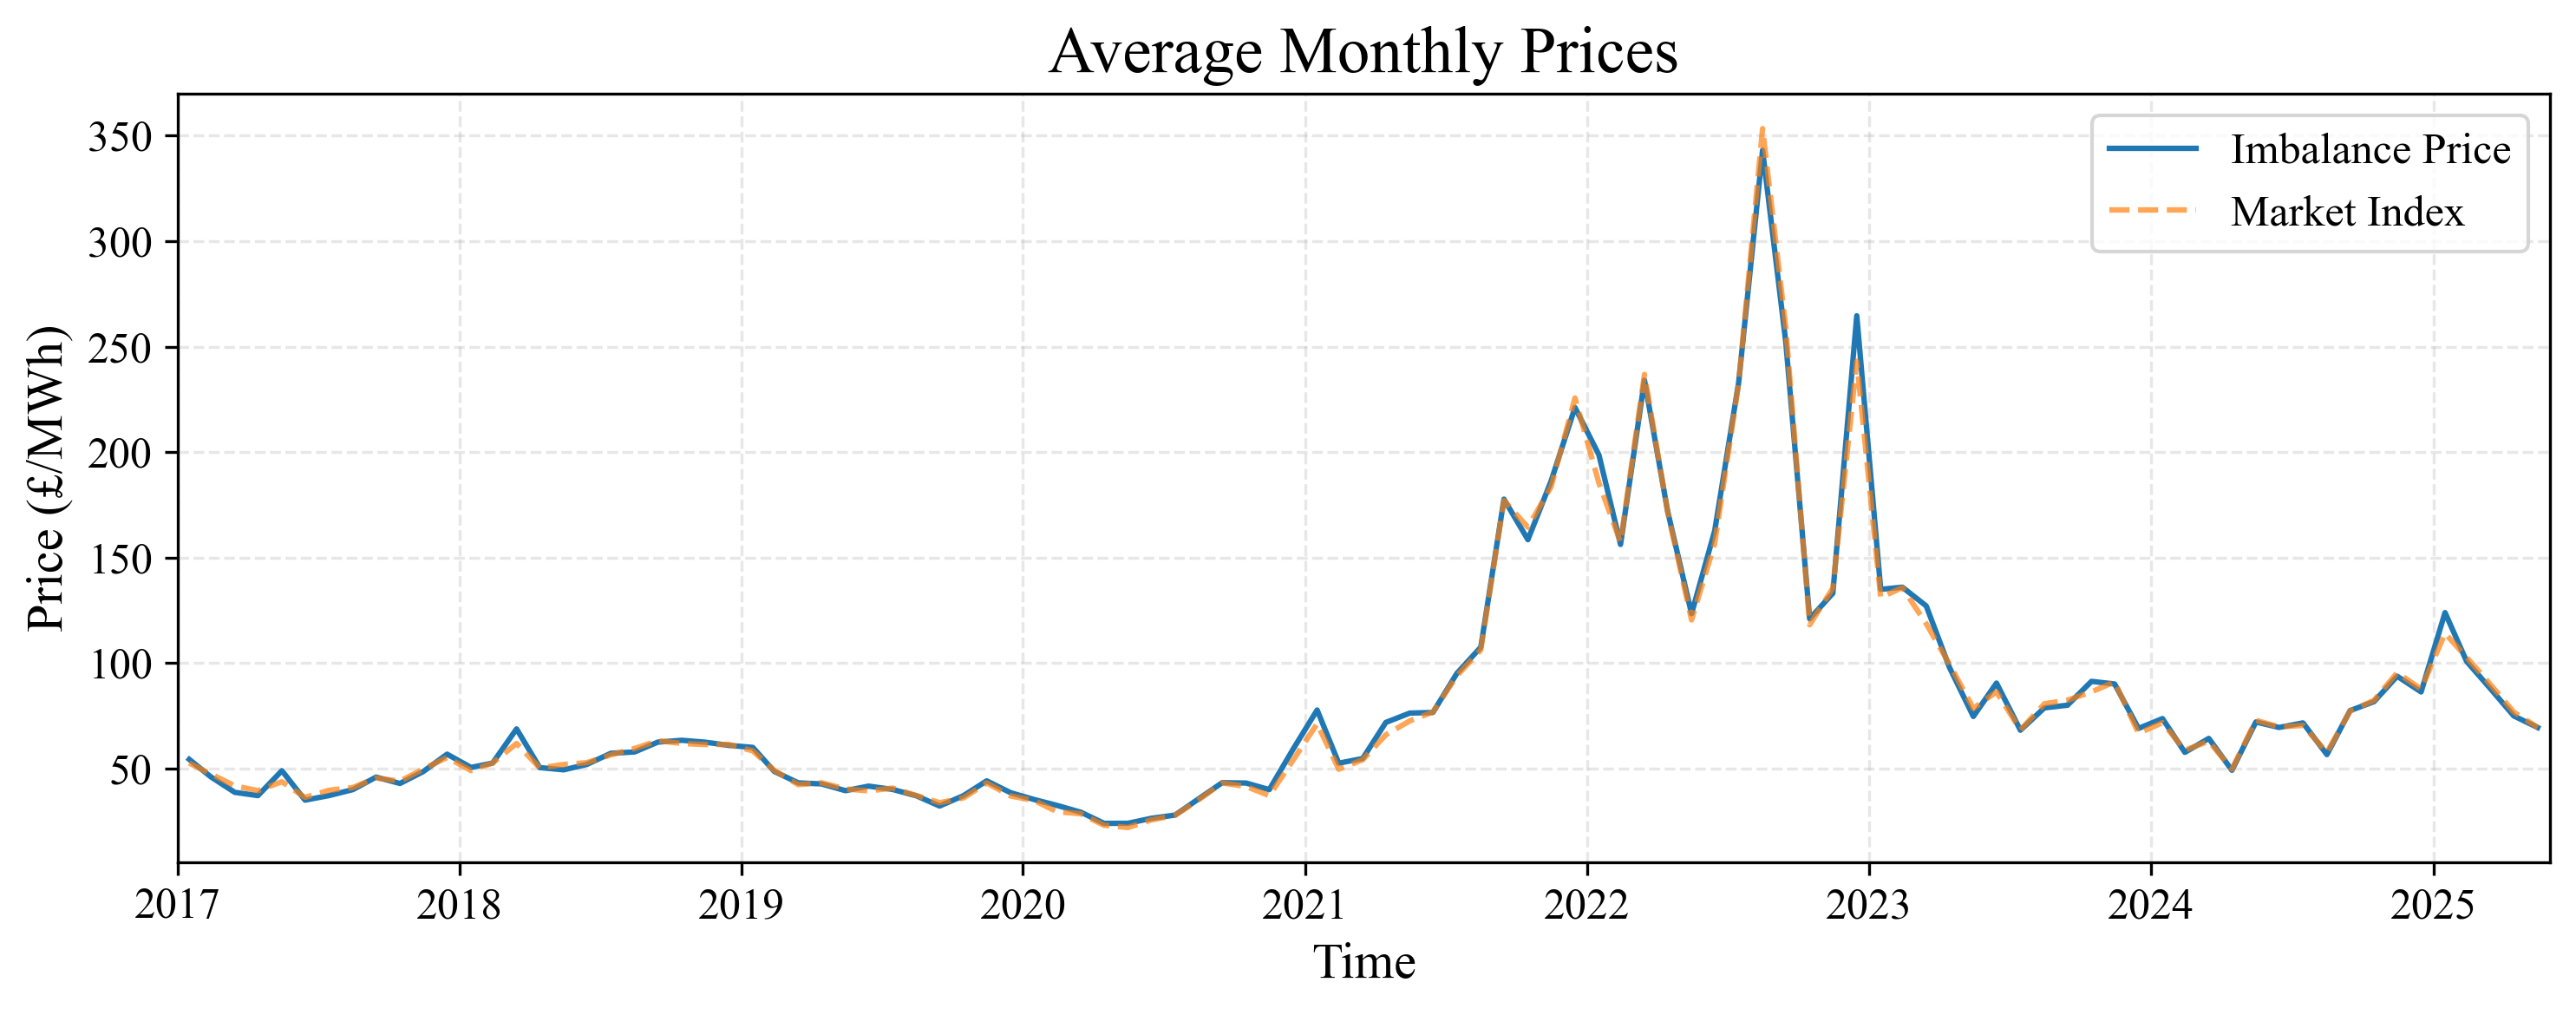

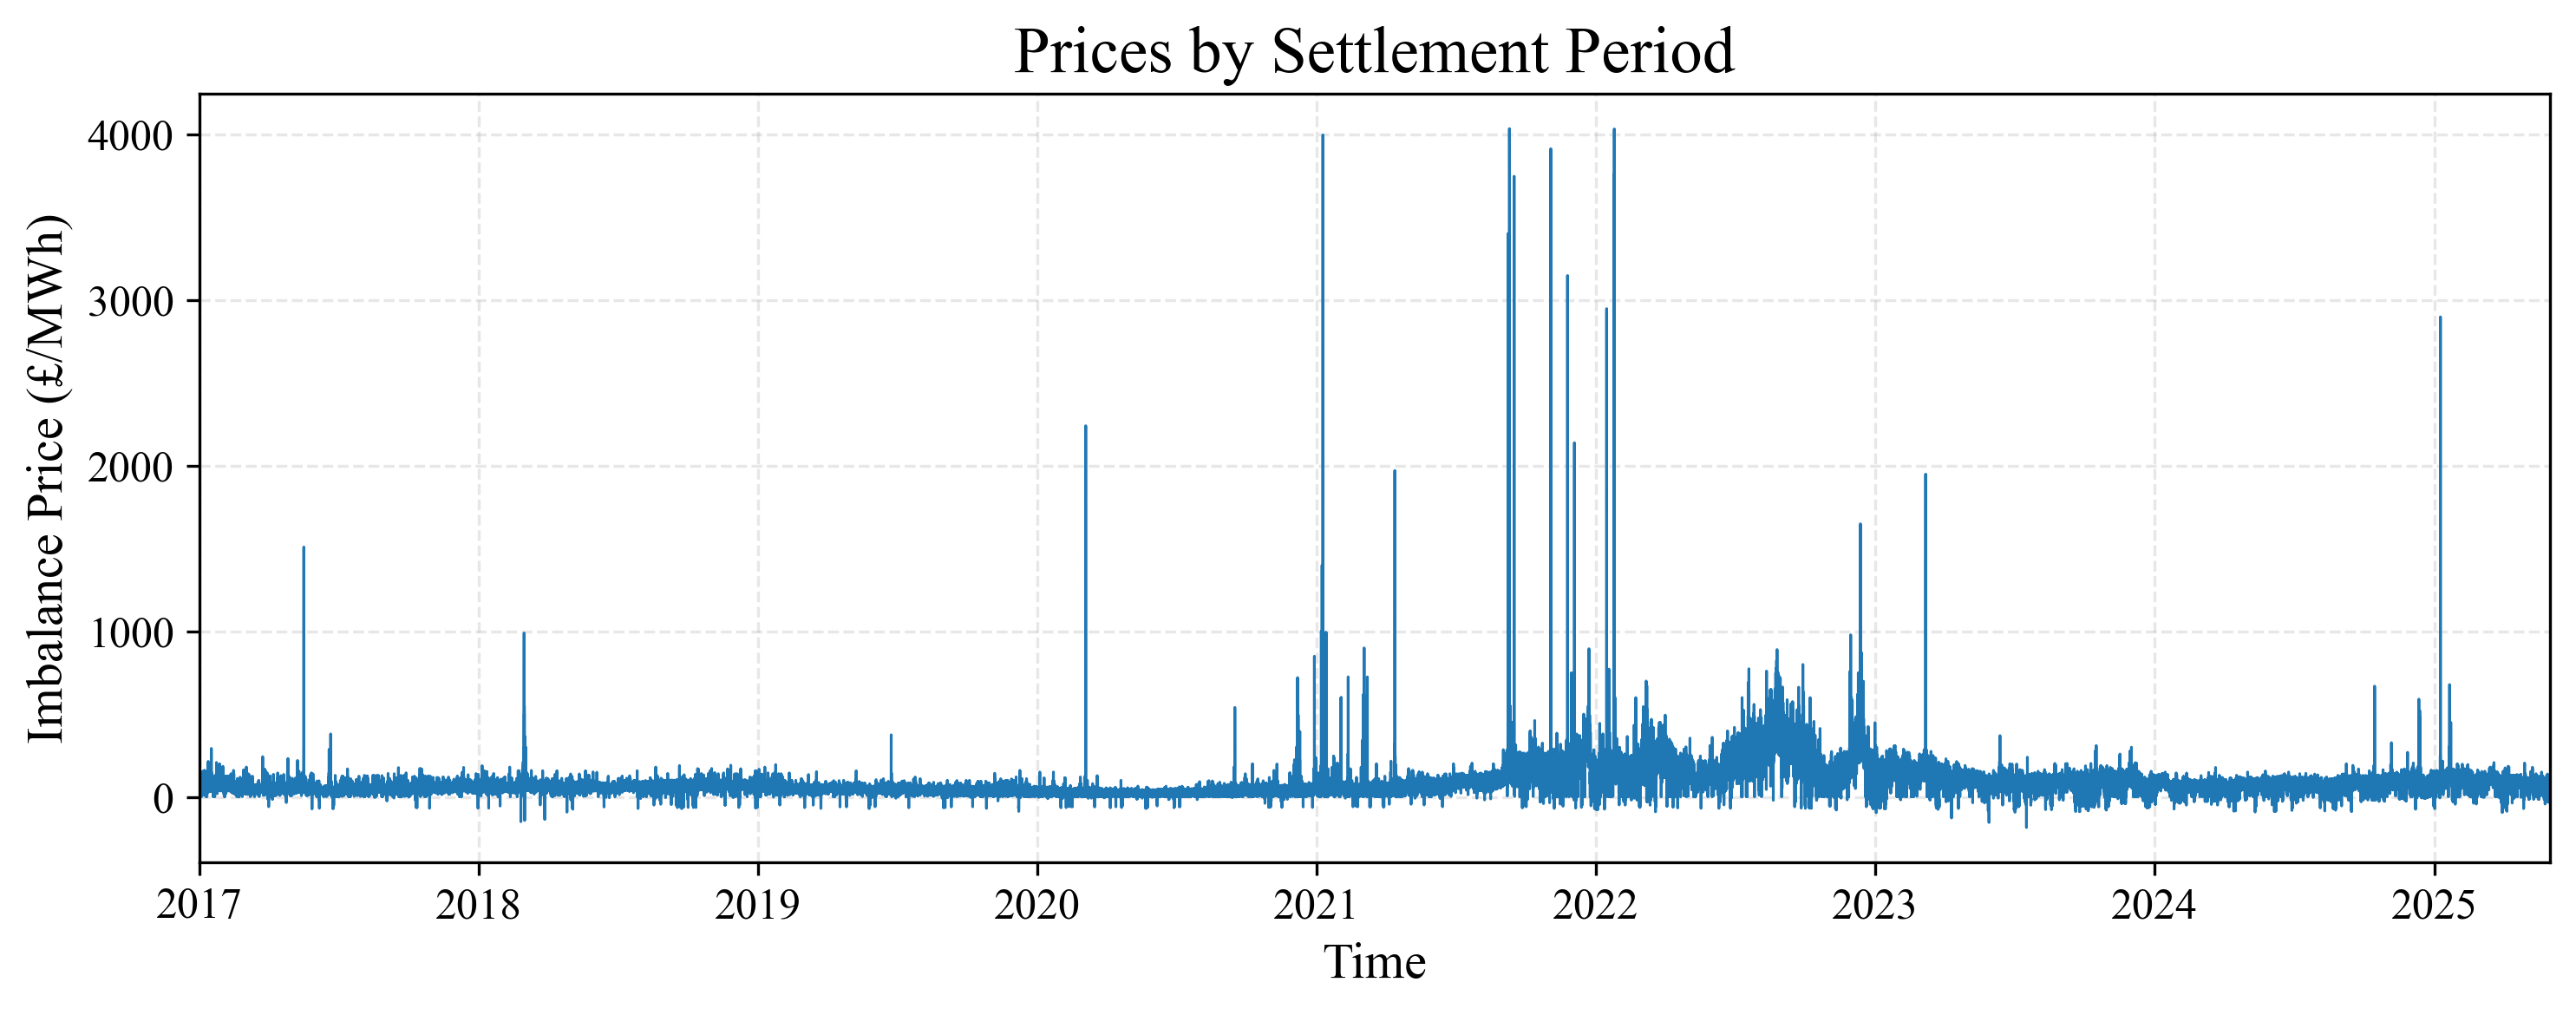

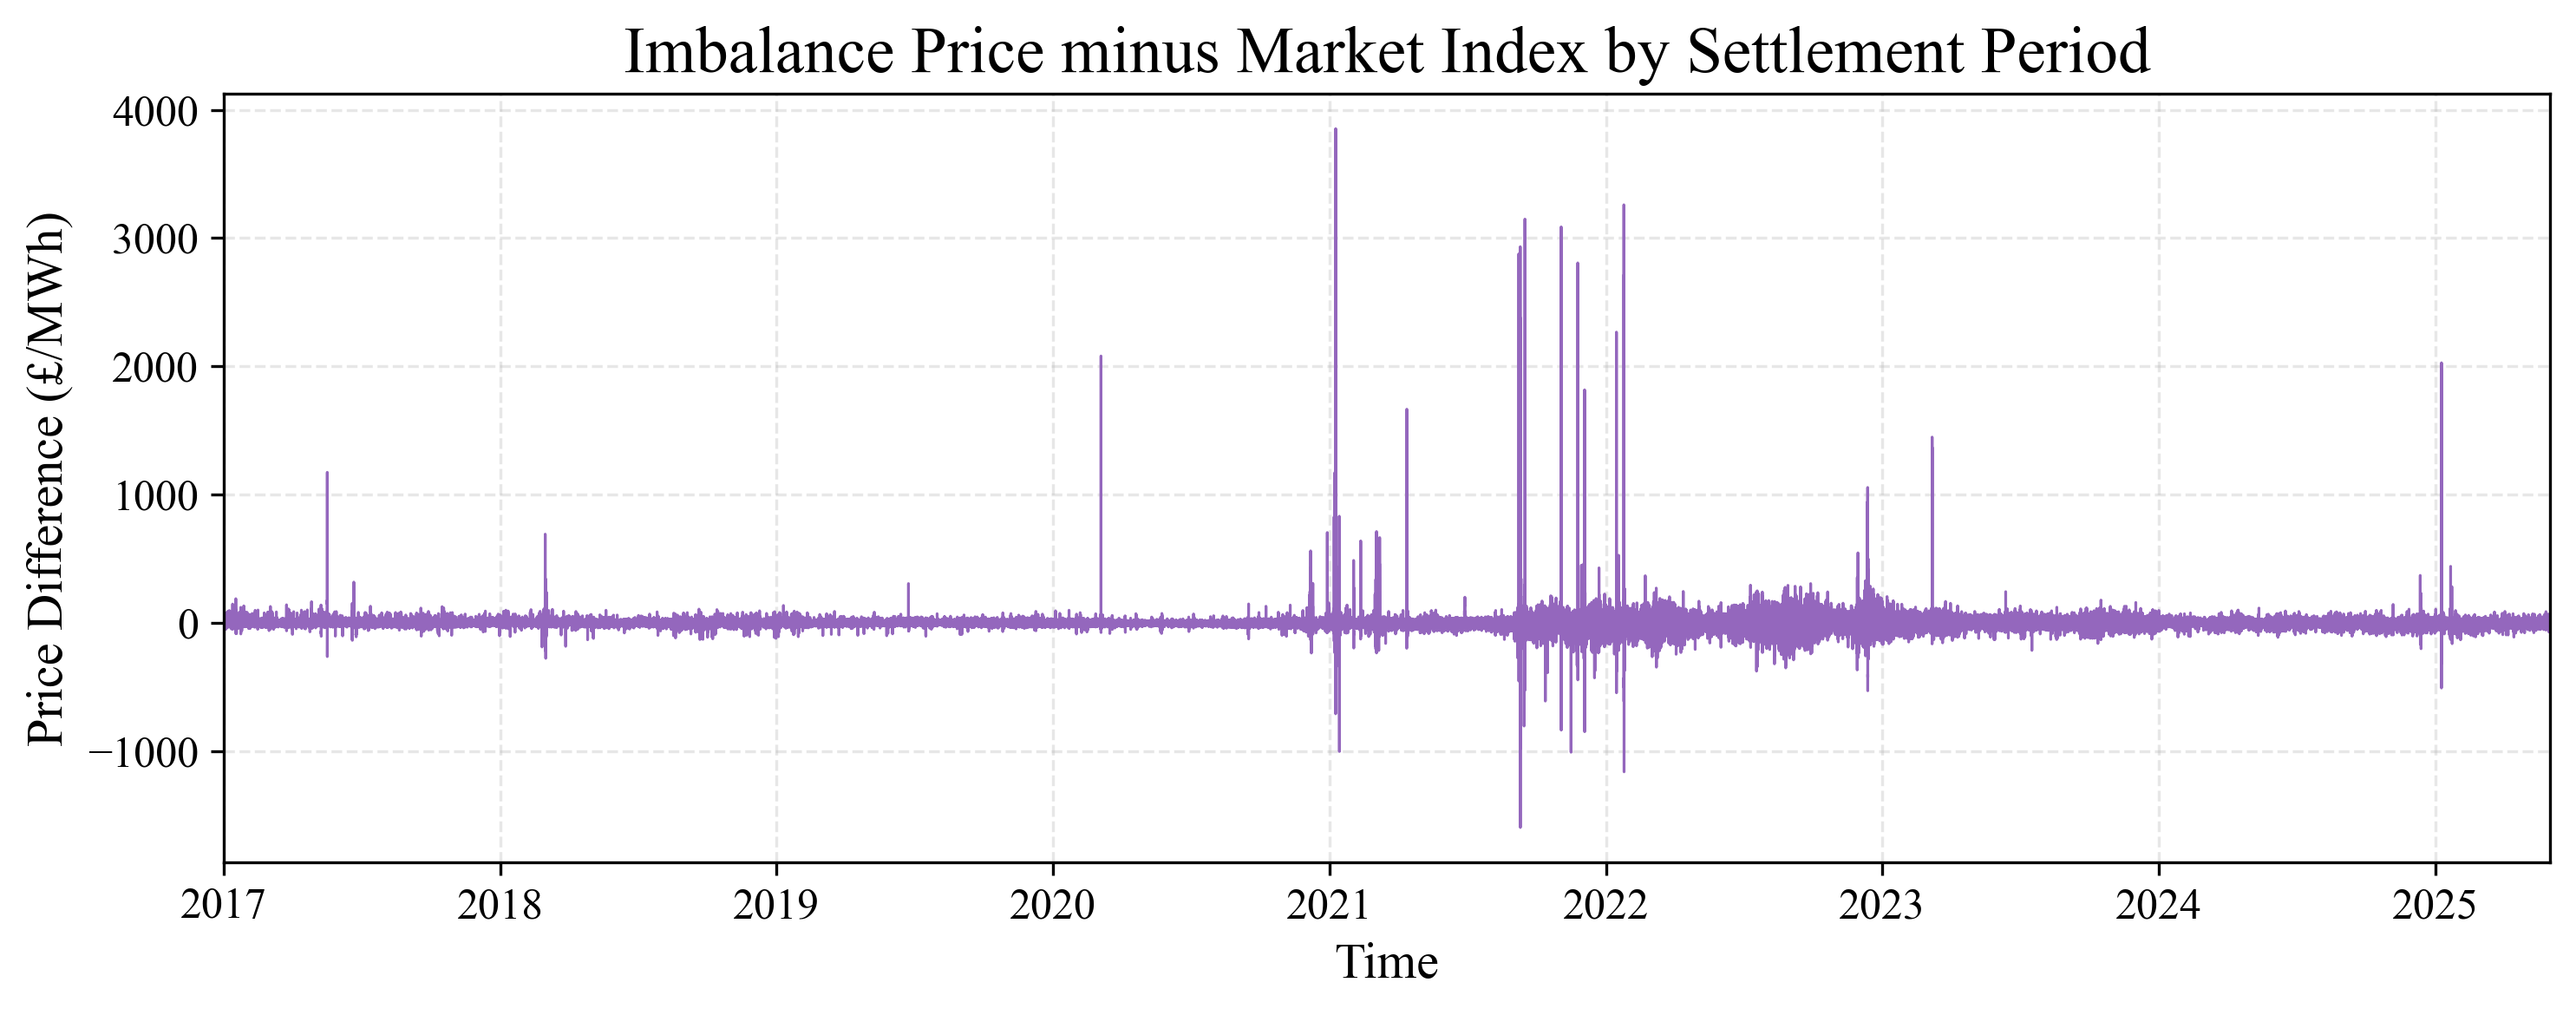

In [4]:
monthly_avg_price = price.resample("ME").mean().shift(freq='-15D')
monthly_avg_market = wholesale.resample("ME").mean().shift(freq='-15D')

plt.figure(figsize=(10,4))
plt.plot(monthly_avg_price.index, monthly_avg_price.values, label='Imbalance Price', color='tab:blue')
plt.plot(monthly_avg_market.index, monthly_avg_market.values, label='Market Index', linestyle='--', alpha=.7, color='tab:orange')
plt.title("Average Monthly Prices")
plt.xlabel("Time")
plt.xlim(price.index.min(), price.index.max())
plt.ylabel("Price (£/MWh)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(price.index, price.values, linewidth=.75, color='tab:blue', alpha=1)
plt.title("Prices by Settlement Period")
plt.xlabel("Time")
plt.xlim(price.index.min(), price.index.max())
plt.ylabel("Imbalance Price (£/MWh)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(diff.index, diff.values, linewidth=.75, color='tab:purple', alpha=1)
plt.title("Imbalance Price minus Market Index by Settlement Period")
plt.xlabel("Time")
plt.xlim(diff.index.min(), diff.index.max())
plt.ylabel("Price Difference (£/MWh)")
plt.tight_layout()
plt.show()

### Imbalance Price vs. Imbalance Volume

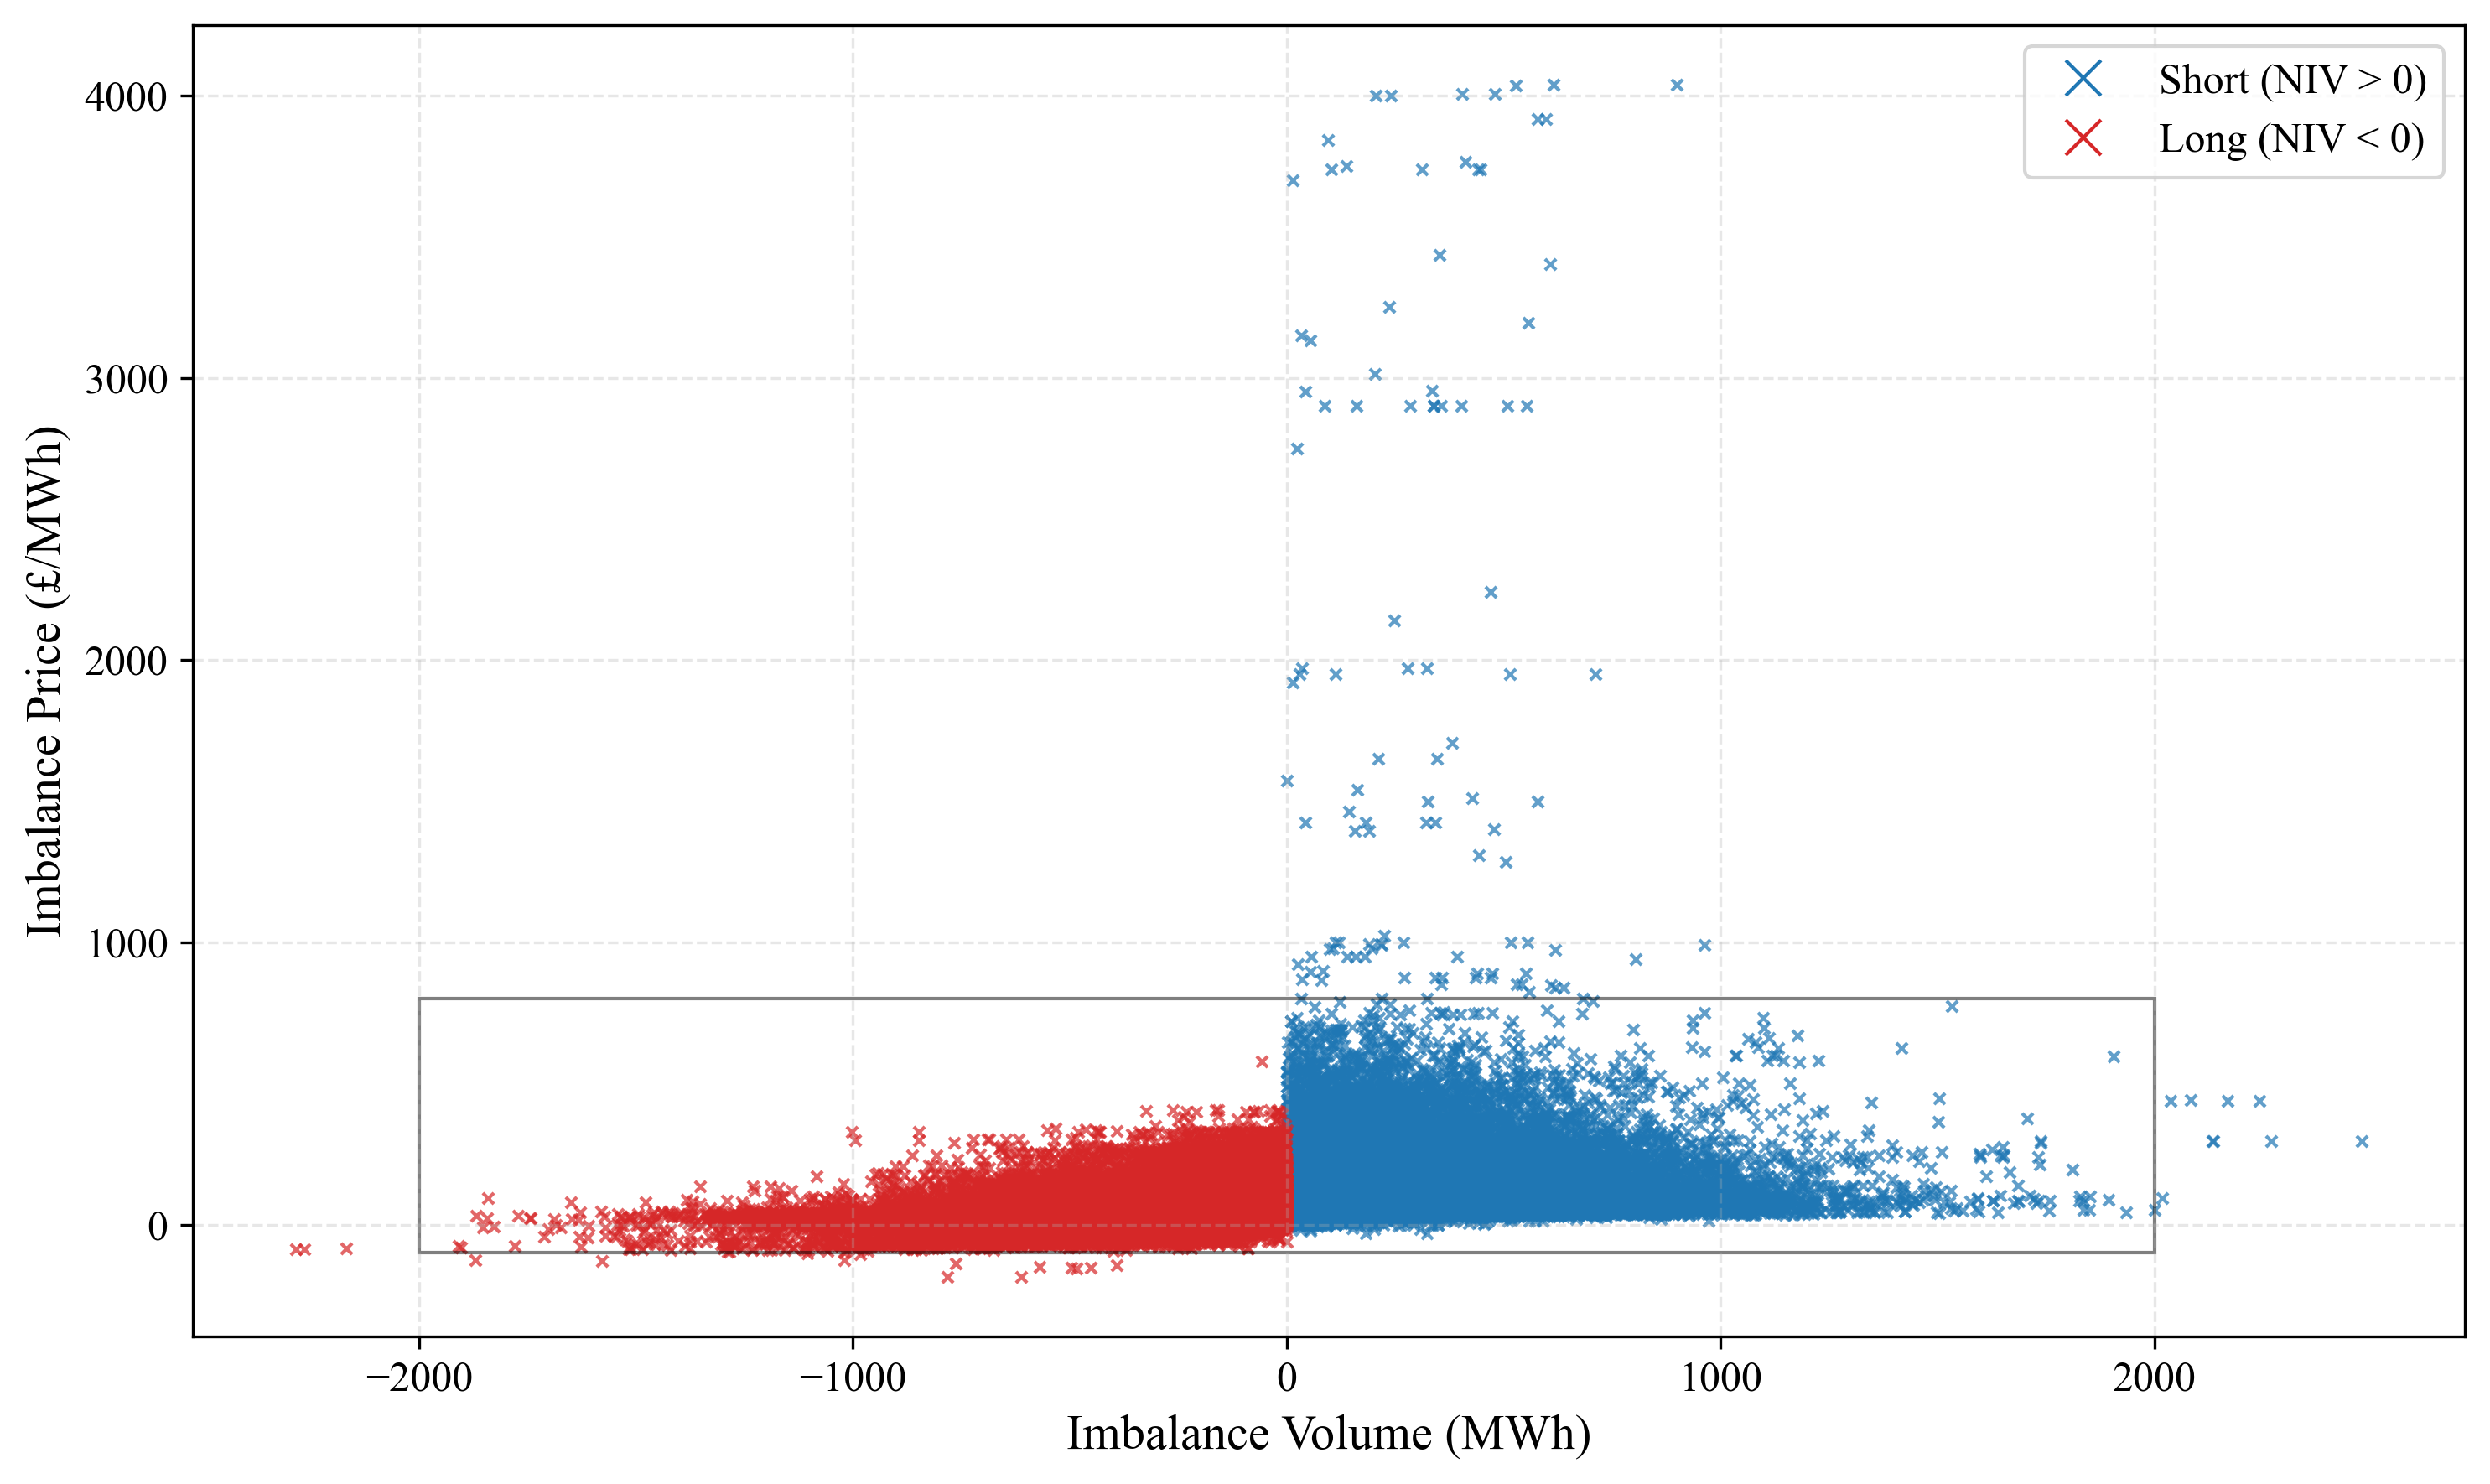

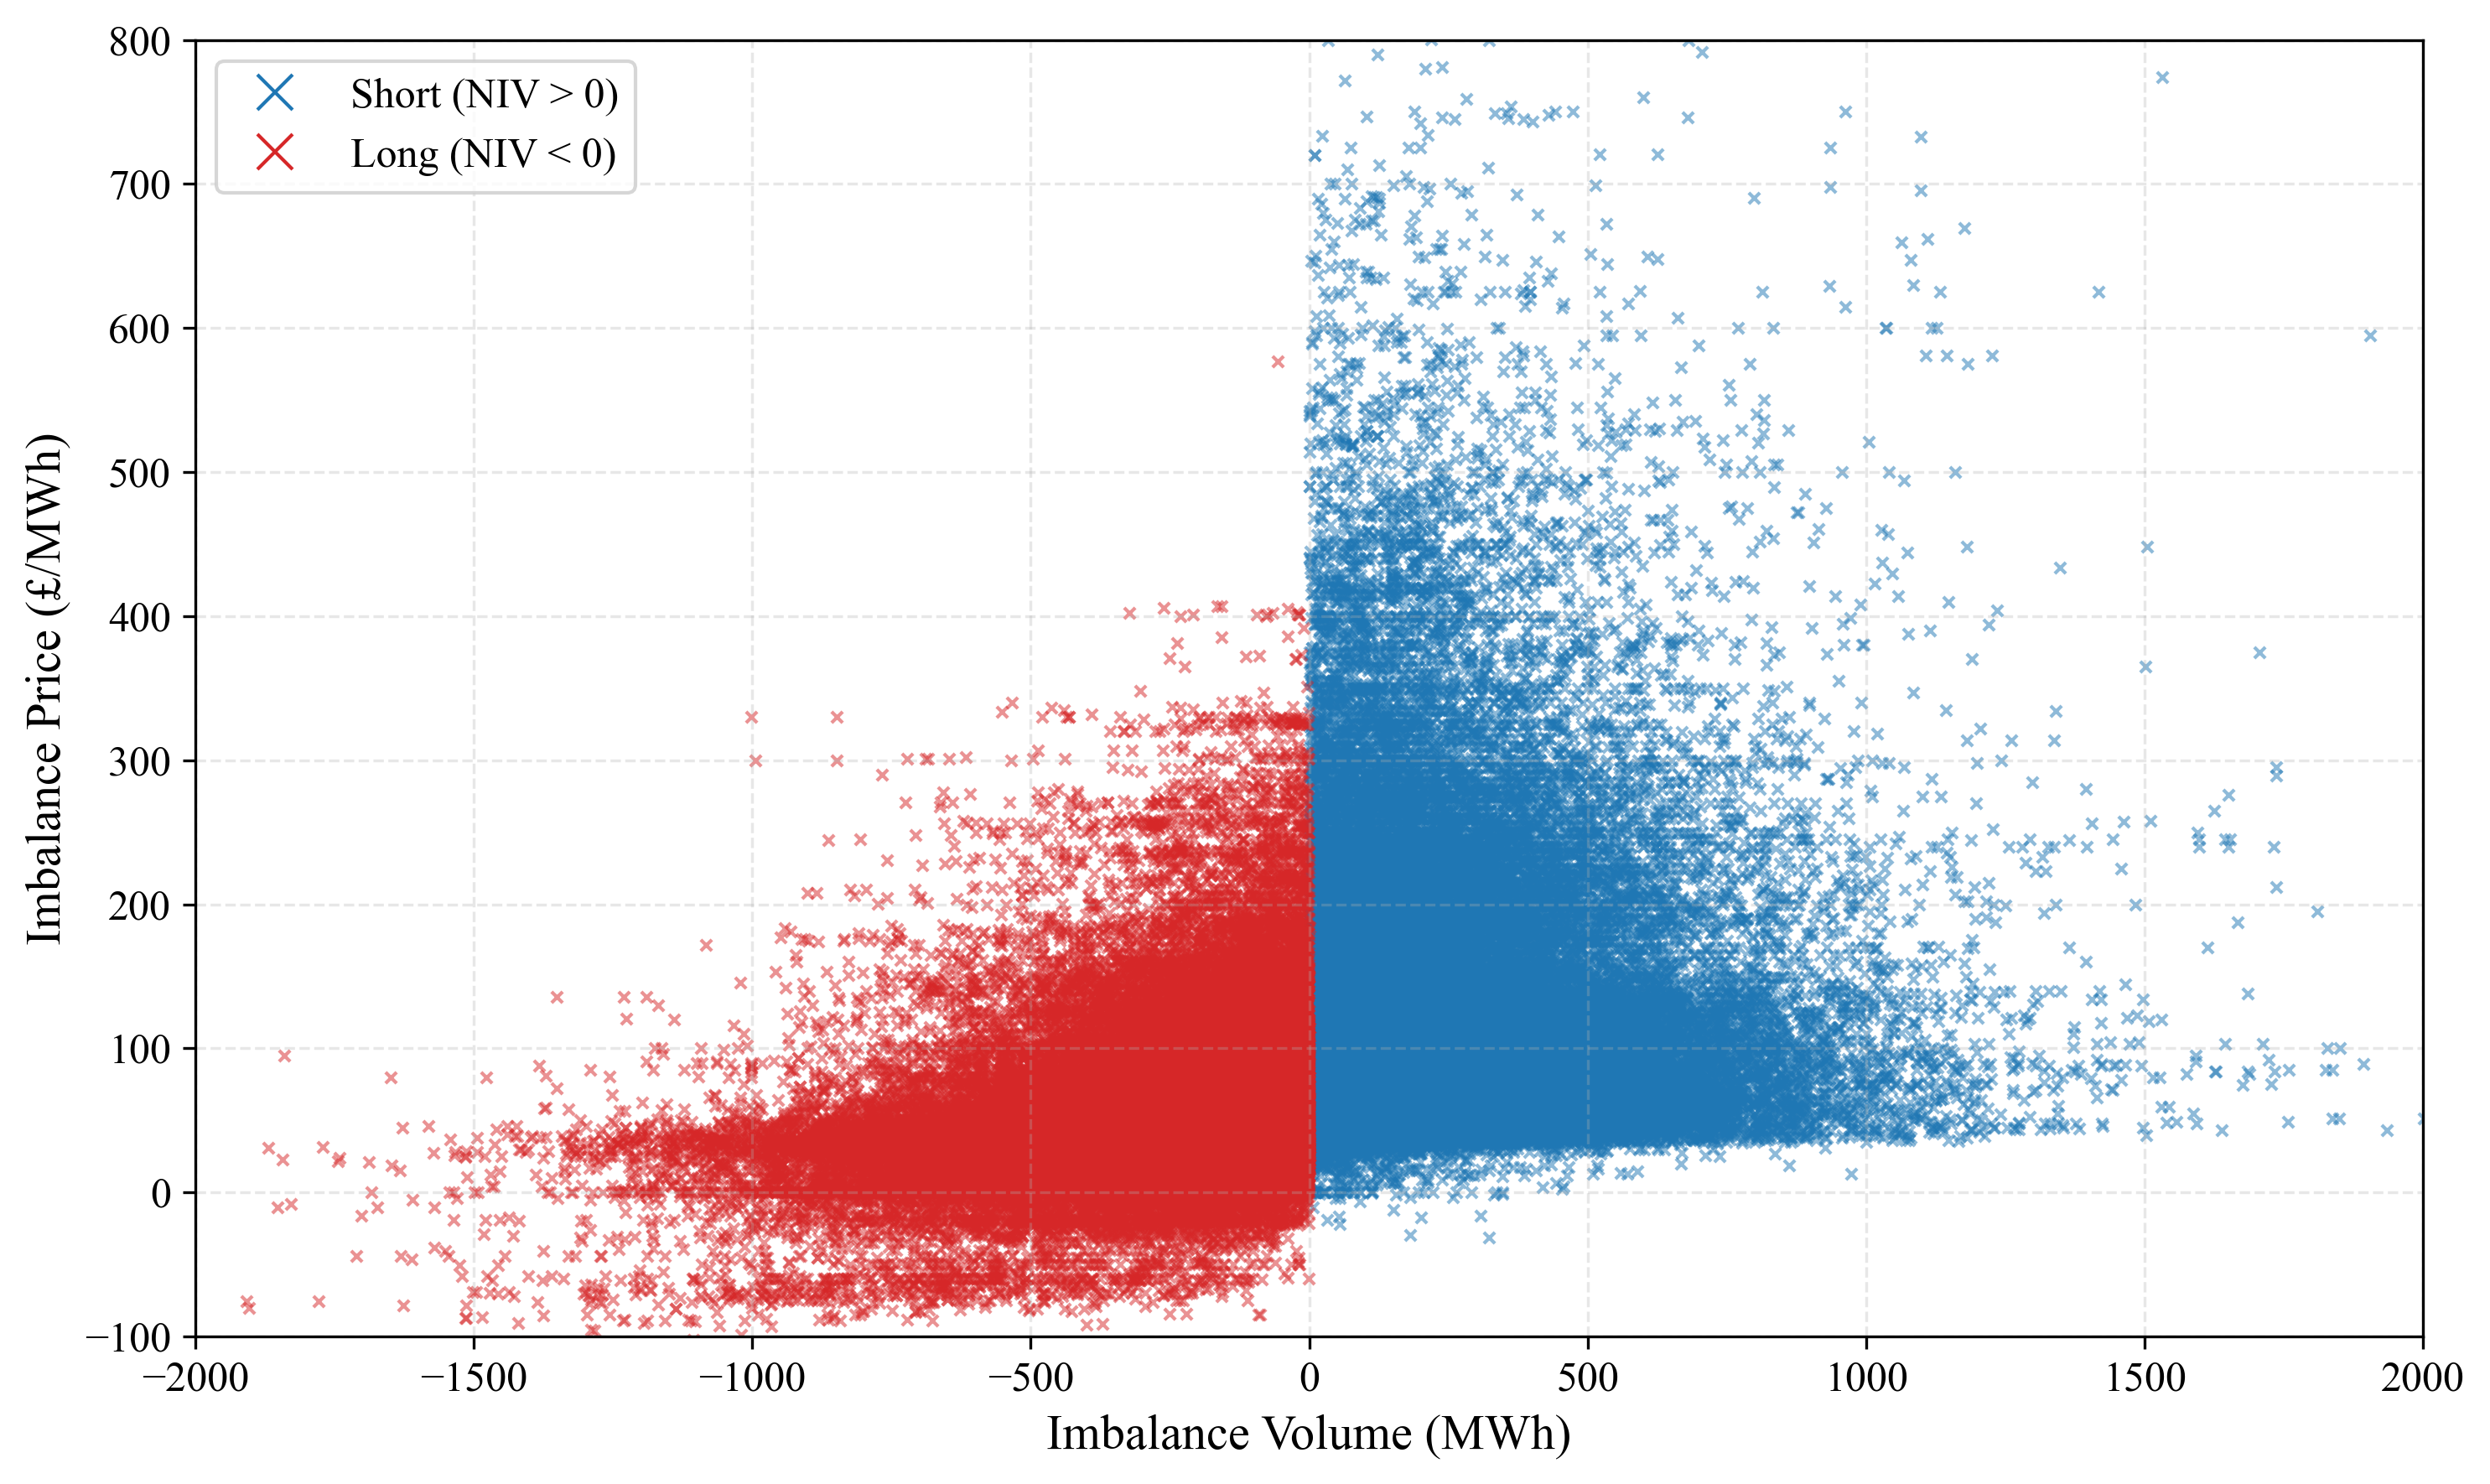

In [5]:
neg_mask = volume < 0

# 1) Full scatter with coloured markers
plt.figure(figsize=(10, 6))
plt.scatter(volume[~neg_mask], price[~neg_mask], alpha=0.7, marker='x', s=10, linewidths=1)
plt.scatter(volume[neg_mask],  price[neg_mask],  alpha=0.7, marker='x', s=10, linewidths=1, color='tab:red')

# Custom legend with larger markers
legend_handles = [
    Line2D([0], [0], marker='x', color='tab:blue', markersize=10, linestyle='None', label="Short (NIV > 0)"),
    Line2D([0], [0], marker='x', color='tab:red',  markersize=10, linestyle='None', label="Long (NIV < 0)")
]
plt.legend(handles=legend_handles)

plt.gca().add_patch(
    plt.Rectangle(
        (-2000, -100), 4000, 900,
        fill=False, edgecolor="black", linewidth=1, alpha=0.5
    )
)
plt.ylabel("Imbalance Price (£/MWh)")
plt.xlabel("Imbalance Volume (MWh)")
plt.tight_layout()
plt.show()

# 2) Zoomed-in version
plt.figure(figsize=(10, 6))
plt.scatter(volume[~neg_mask], price[~neg_mask], alpha=0.5, marker='x', s=10, linewidths=1)
plt.scatter(volume[neg_mask],  price[neg_mask],  alpha=0.5, marker='x', s=10, linewidths=1, color='tab:red')

# Reuse the same custom legend
plt.legend(handles=legend_handles)

plt.ylabel("Imbalance Price (£/MWh)")
plt.xlabel("Imbalance Volume (MWh)")
plt.xlim(-2000, 2000)
plt.ylim(-100, 800)
plt.tight_layout()
plt.show()


### Day-Ahead Forecast vs Actual

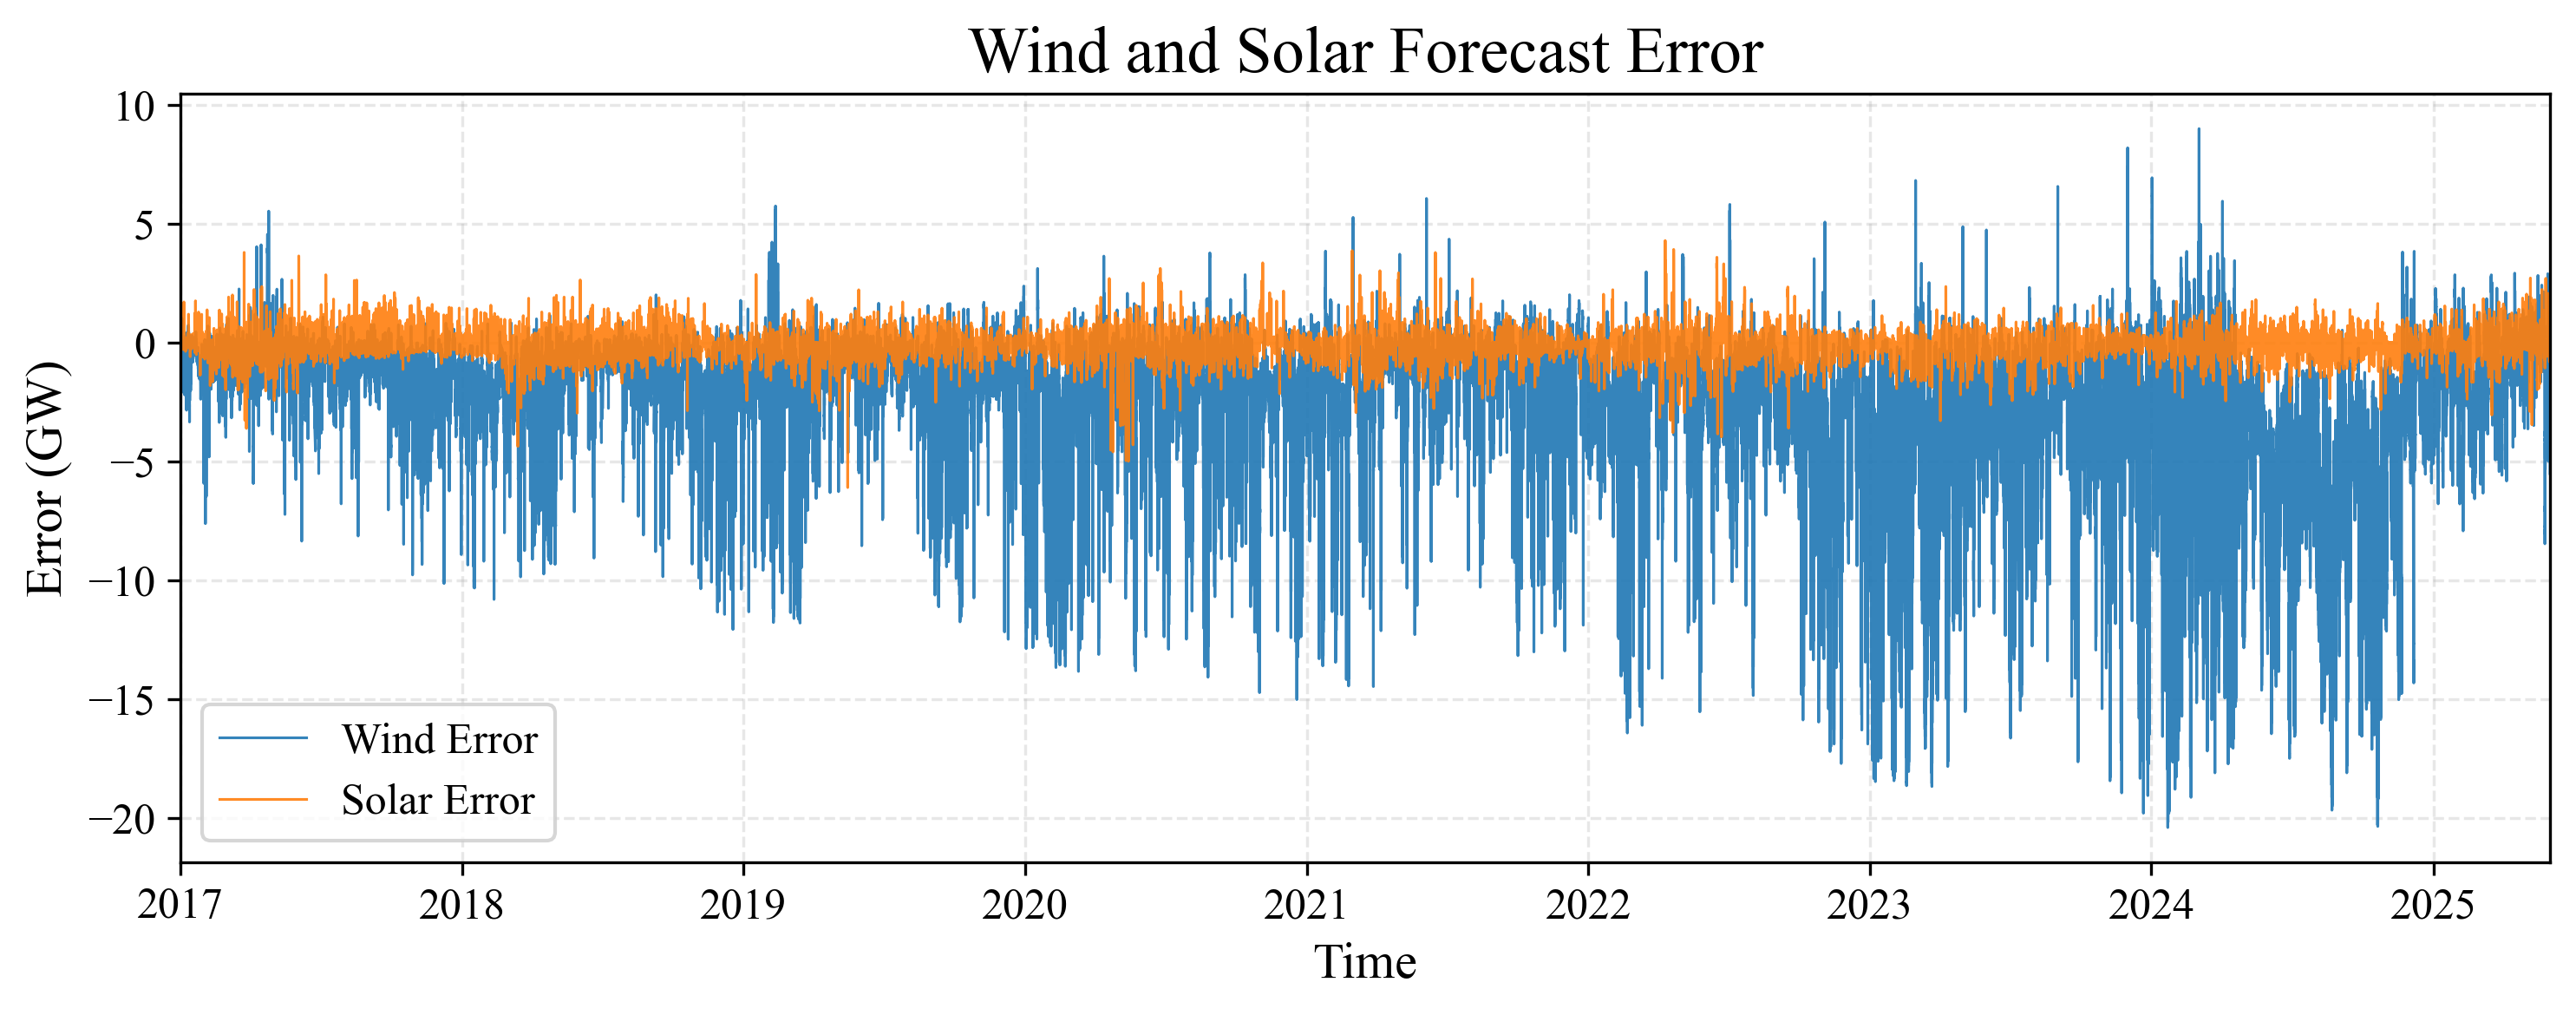

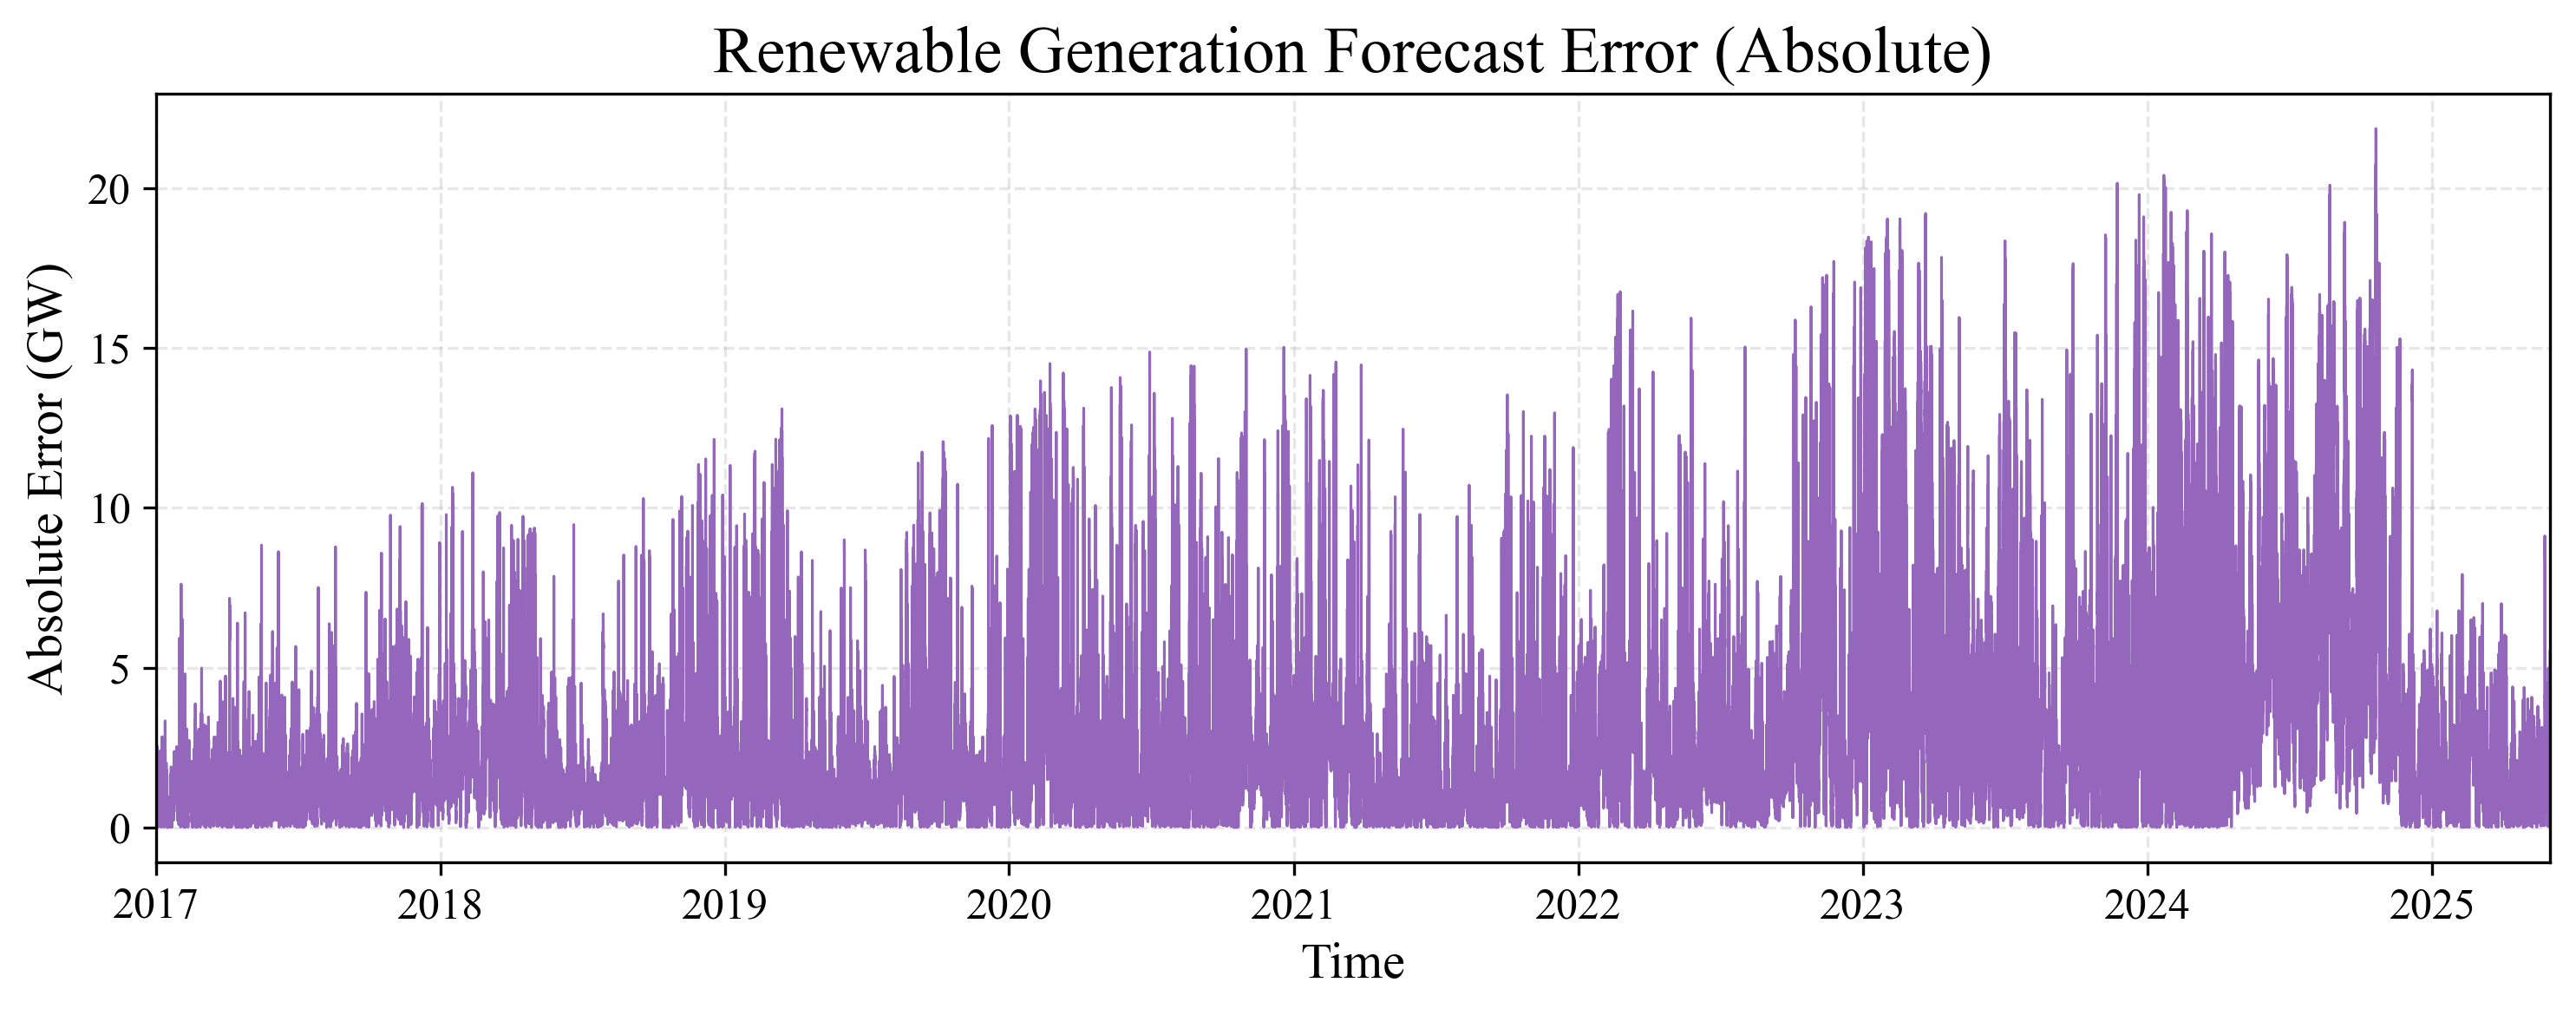

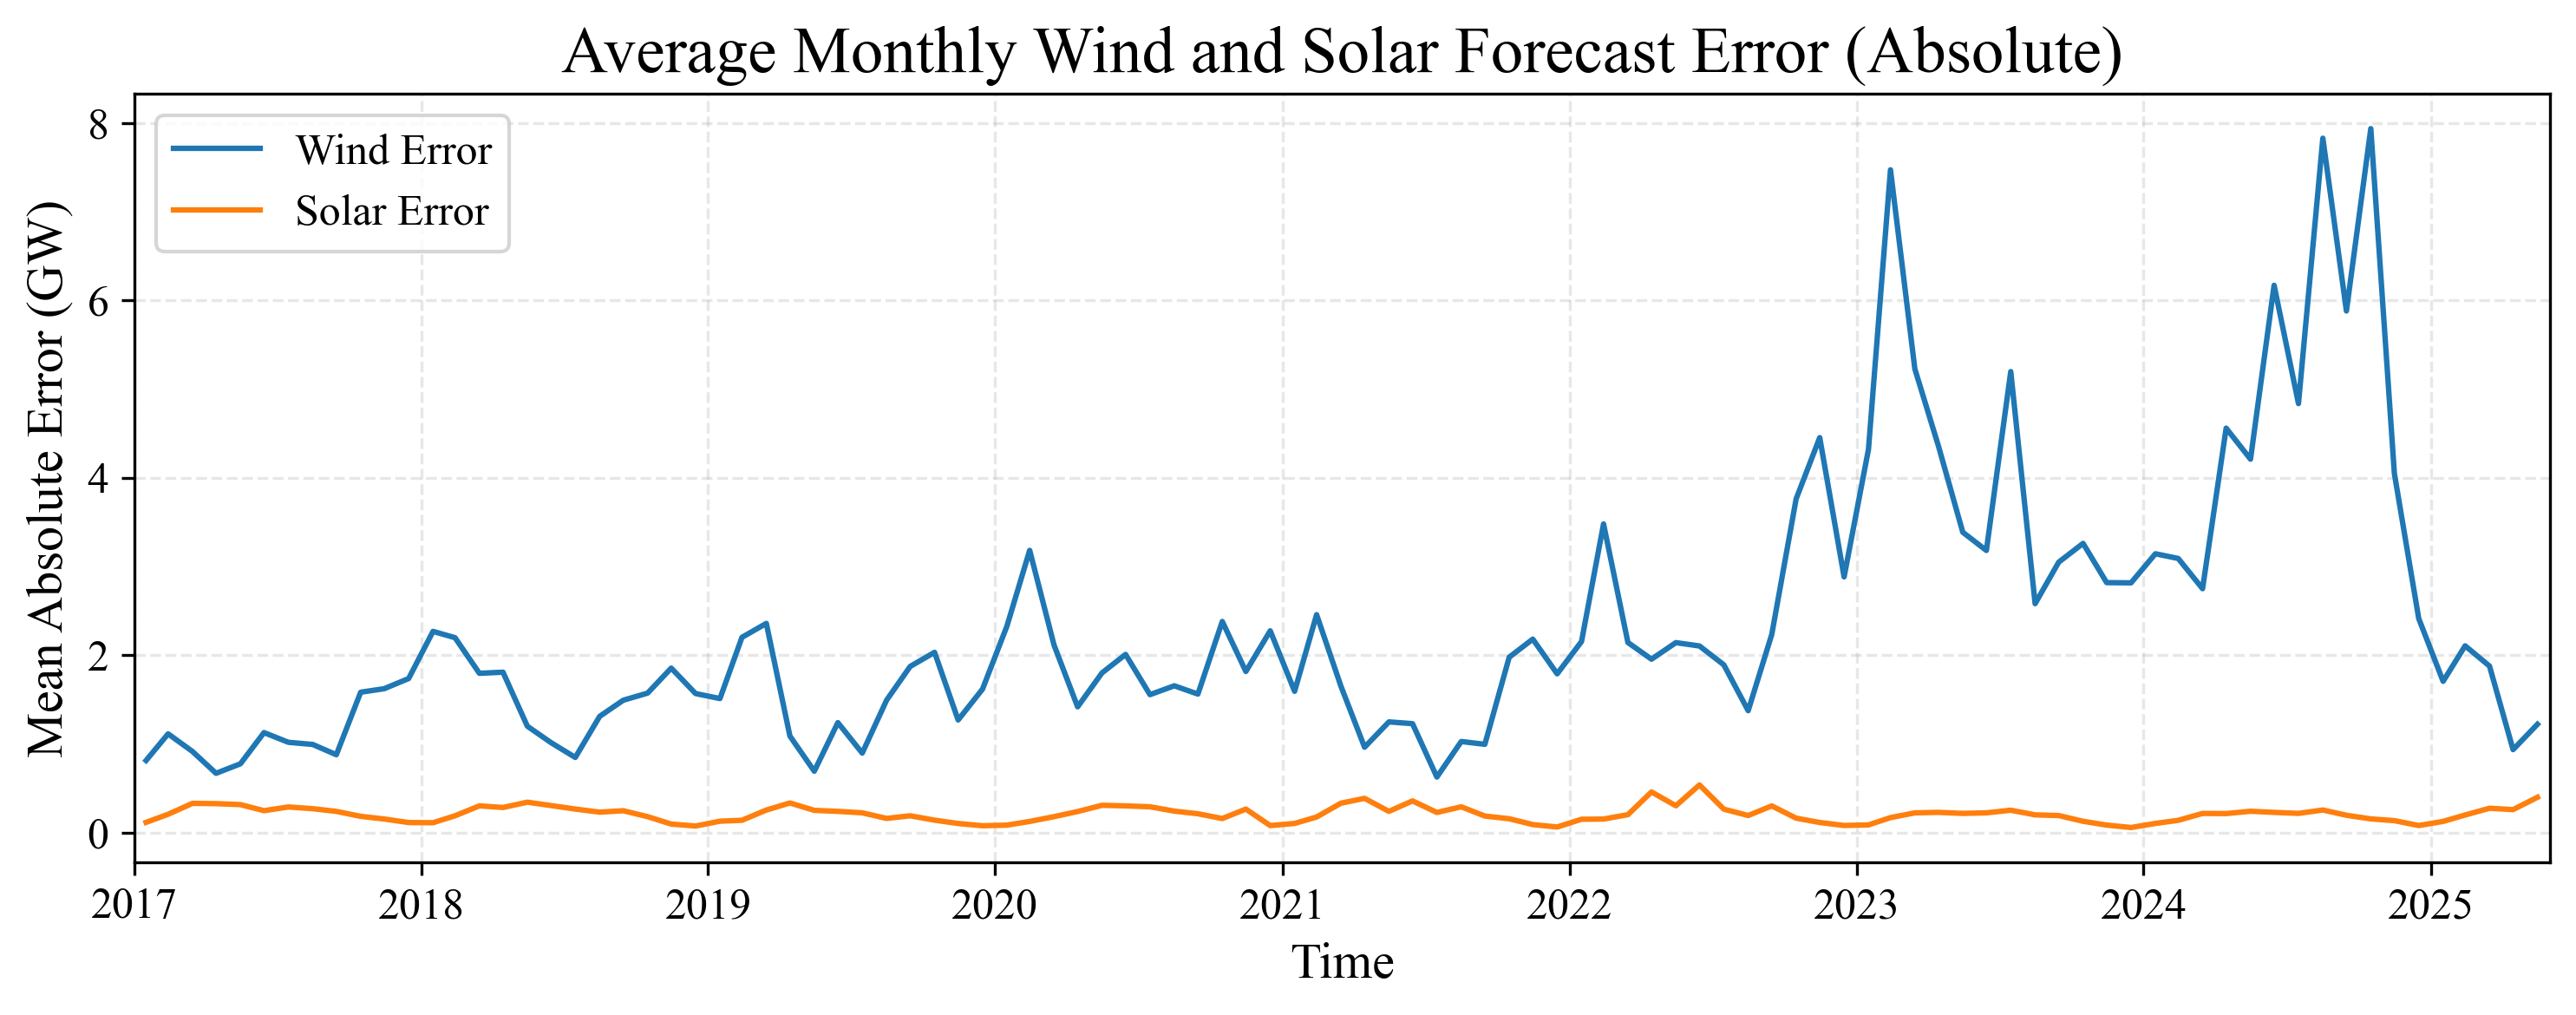

In [6]:
wind_error_gw = wind_error / 1_000
solar_error_gw = solar_error / 1_000

wind_error_abs = wind_error.abs()
solar_error_abs = solar_error.abs()
total_error_abs_gw = ( wind_error_abs + solar_error_abs ) / 1_000

# Resample and shift timestamps to month centres
monthly_wind_error_gw  = wind_error_abs.resample("ME").mean().shift(freq='-15D') / 1_000
monthly_solar_error_gw = solar_error_abs.resample("ME").mean().shift(freq='-15D') / 1_000


#1) Wind & Solar error time series in GW
plt.figure(figsize=(10, 4))
plt.plot(wind_error_gw.index,  wind_error_gw.values,  label="Wind Error", linewidth=0.75, alpha=0.9)
plt.plot(solar_error_gw.index, solar_error_gw.values, label="Solar Error", linewidth=0.75, alpha=0.9)
plt.title("Wind and Solar Forecast Error")
plt.xlabel("Time")
plt.ylabel("Error (GW)")
plt.xlim(wind_error.index.min(), wind_error.index.max())
#plt.ylim(0, max(wind_error.max(), solar_error.max()) / 1_000 * 1.05)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Total forecast error in GW
plt.figure(figsize=(10, 4))
plt.plot(total_error_abs_gw.index, total_error_abs_gw.values, color='tab:purple', linewidth=0.75)
plt.title("Renewable Generation Forecast Error (Absolute)")
plt.xlabel("Time")
plt.ylabel("Absolute Error (GW)")
plt.xlim(wind_error.index.min(), wind_error.index.max())
#plt.ylim(0, total_error_gw.max() * 1.05)
plt.tight_layout()
plt.show()

# 3) Average monthly error in GW
plt.figure(figsize=(10, 4))
plt.plot(monthly_wind_error_gw.index,  monthly_wind_error_gw.values,  label="Wind Error")
plt.plot(monthly_solar_error_gw.index, monthly_solar_error_gw.values, label="Solar Error")
plt.title("Average Monthly Wind and Solar Forecast Error (Absolute)")
plt.xlabel("Time")
plt.ylabel("Mean Absolute Error (GW)")
plt.xlim(wind_error.index.min(), wind_error.index.max())
#plt.ylim(monthly_wind_error_gw.min() * 1.05, monthly_solar_error_gw.max() * 1.05)
plt.legend()
plt.tight_layout()
plt.show()


### Demand Forecast Error

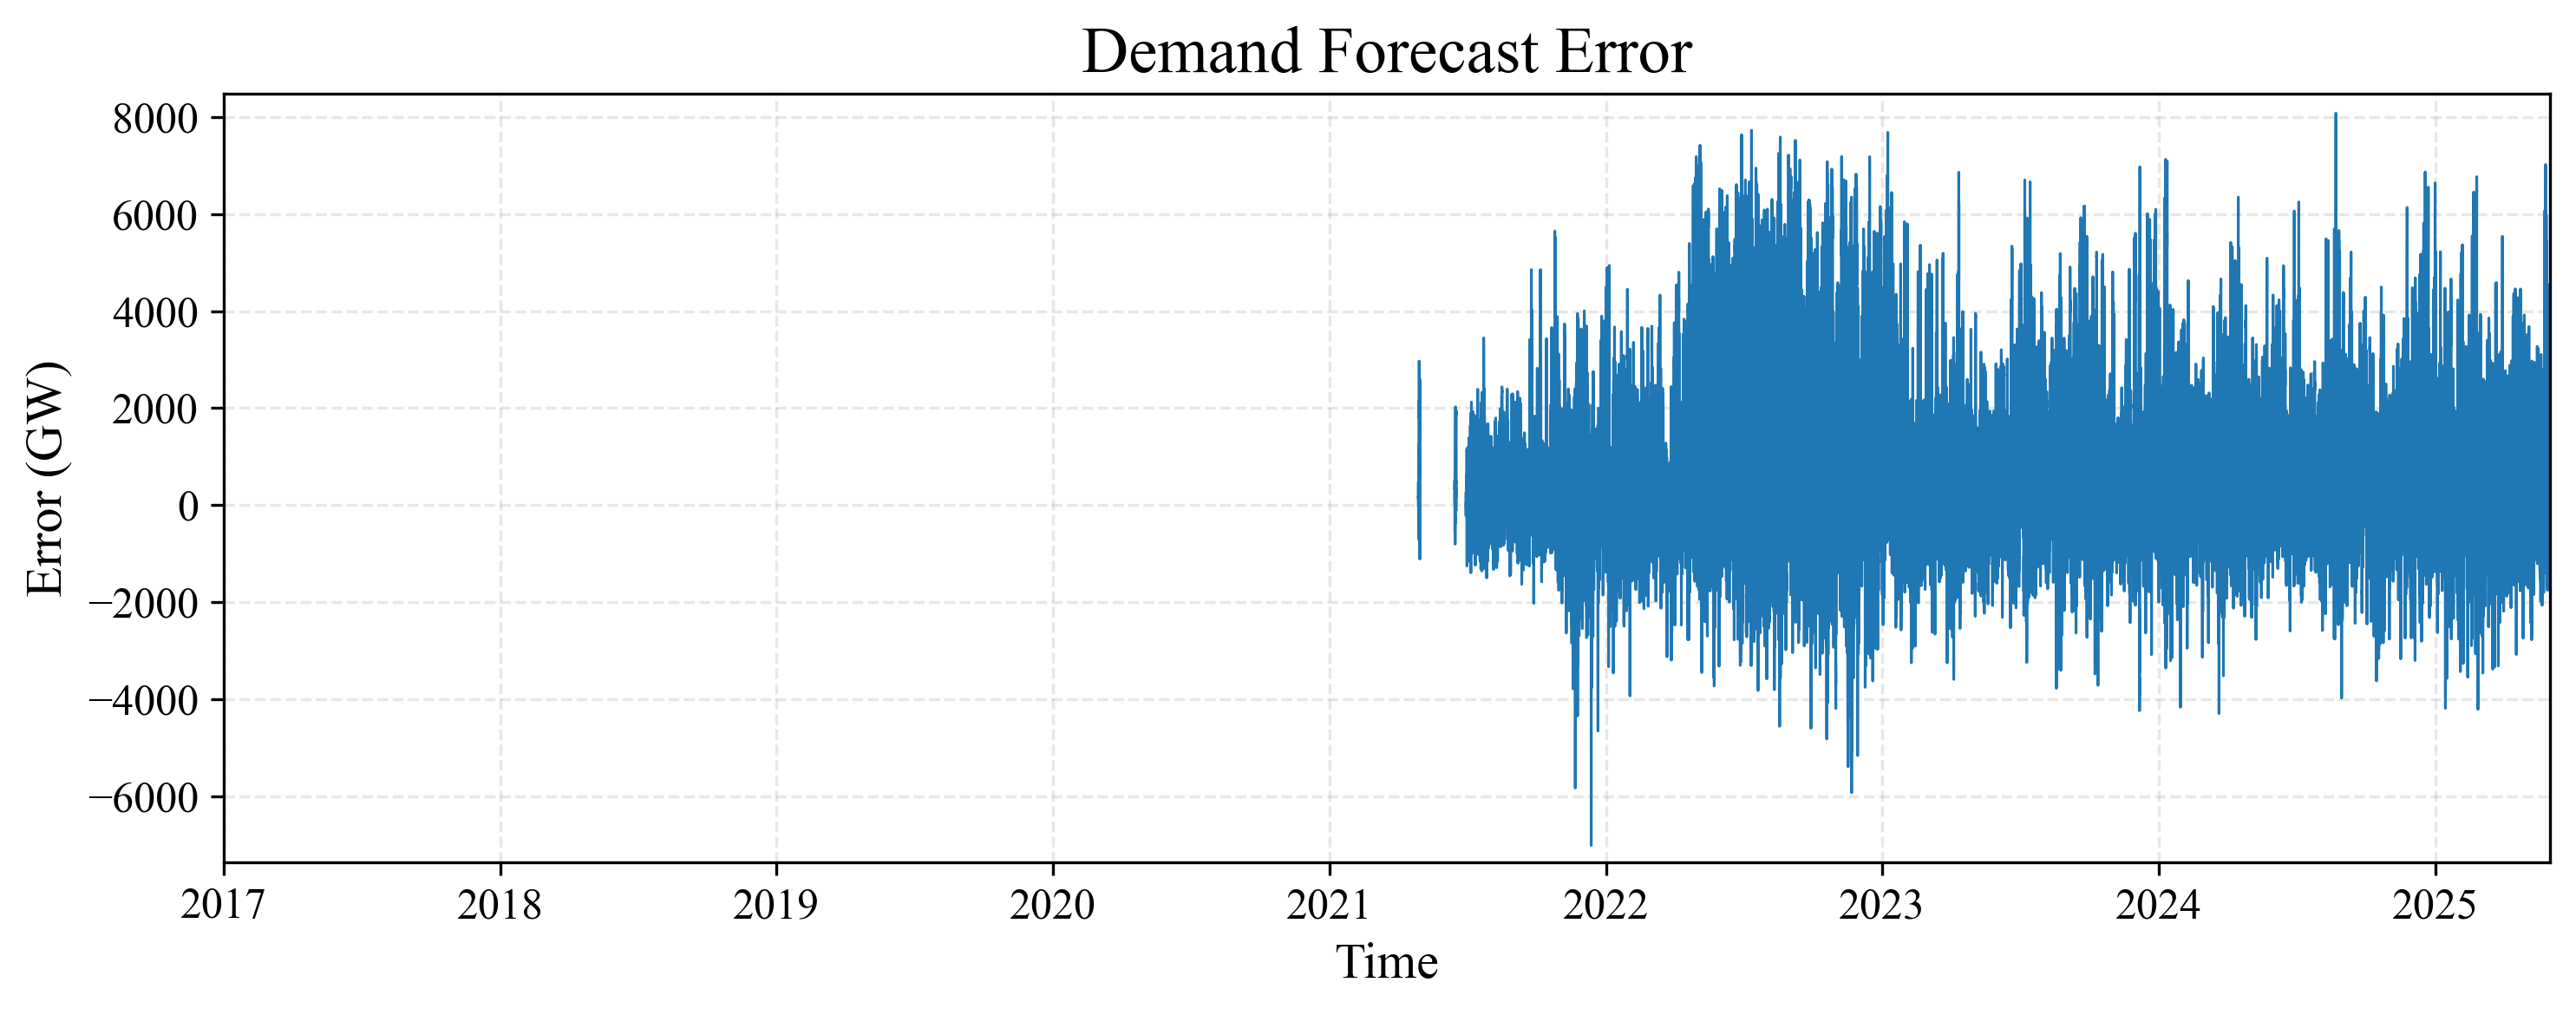

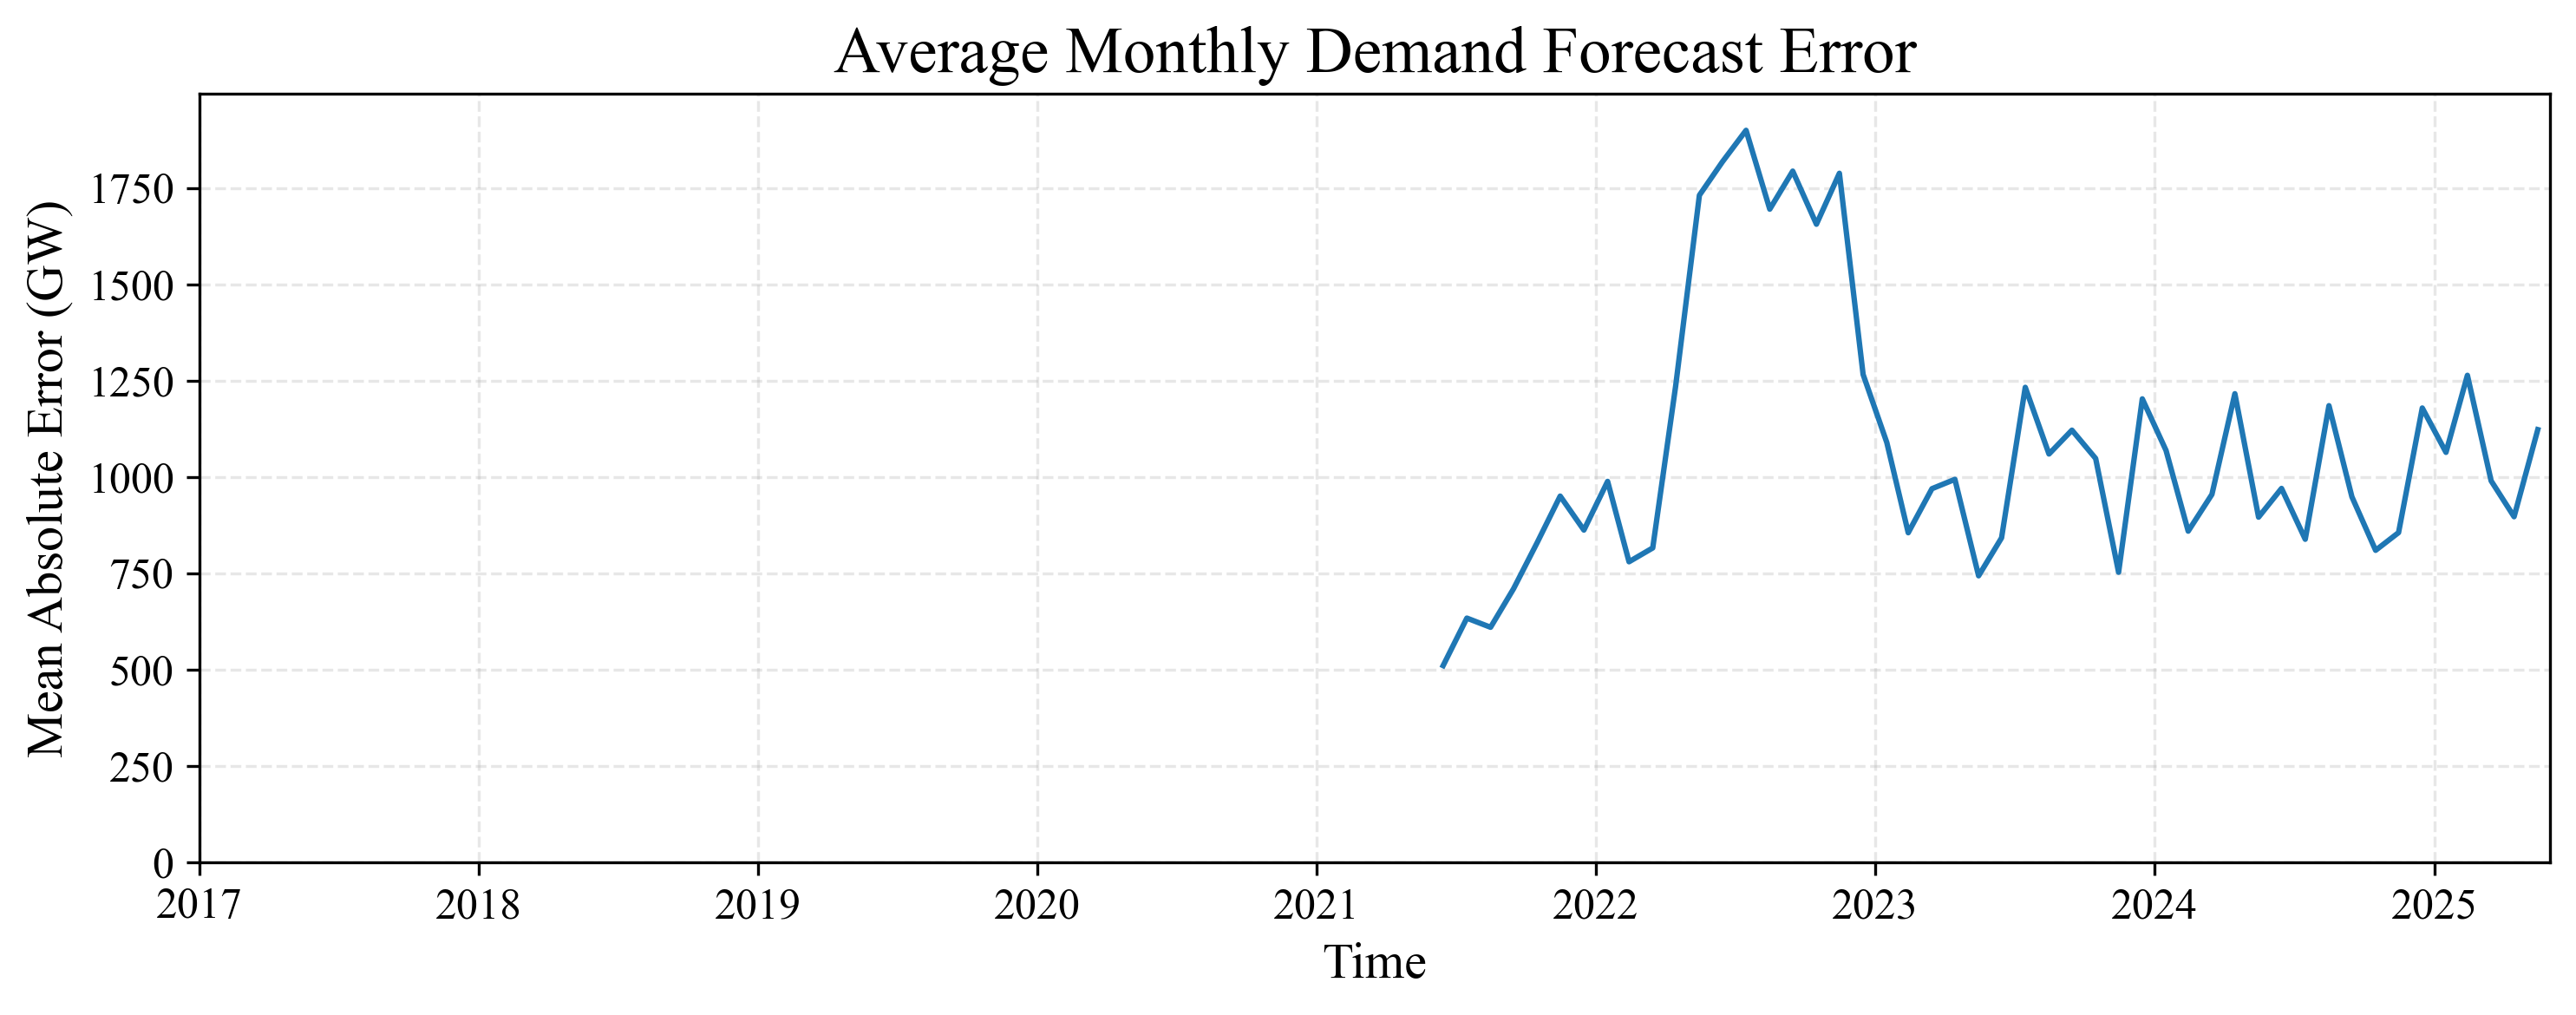

In [7]:
demand_error_abs = demand_error.abs()

# Resample and shift timestamps to month centres
monthly_demand_error  = demand_error_abs.resample("ME").mean().shift(freq='-15D')

# 2) Demand forecast error in GW
plt.figure(figsize=(10, 4))
plt.plot(demand_error.index, demand_error.values, color='tab:blue', linewidth=0.75)
plt.title("Demand Forecast Error")
plt.xlabel("Time")
plt.ylabel("Error (GW)")
plt.xlim(demand_error.index.min(), demand_error.index.max())
plt.ylim(demand_error.min() * 1.05, demand_error.max() * 1.05)
plt.tight_layout()
plt.show()

# 3) Average monthly error in GW
plt.figure(figsize=(10, 4))
plt.plot(monthly_demand_error.index,  monthly_demand_error.values)
plt.title("Average Monthly Demand Forecast Error")
plt.xlabel("Time")
plt.ylabel("Mean Absolute Error (GW)")
plt.xlim(demand_error.index.min(), demand_error.index.max())
plt.ylim(0, monthly_demand_error.max() * 1.05)
plt.tight_layout()
plt.show()


### Inter Delta

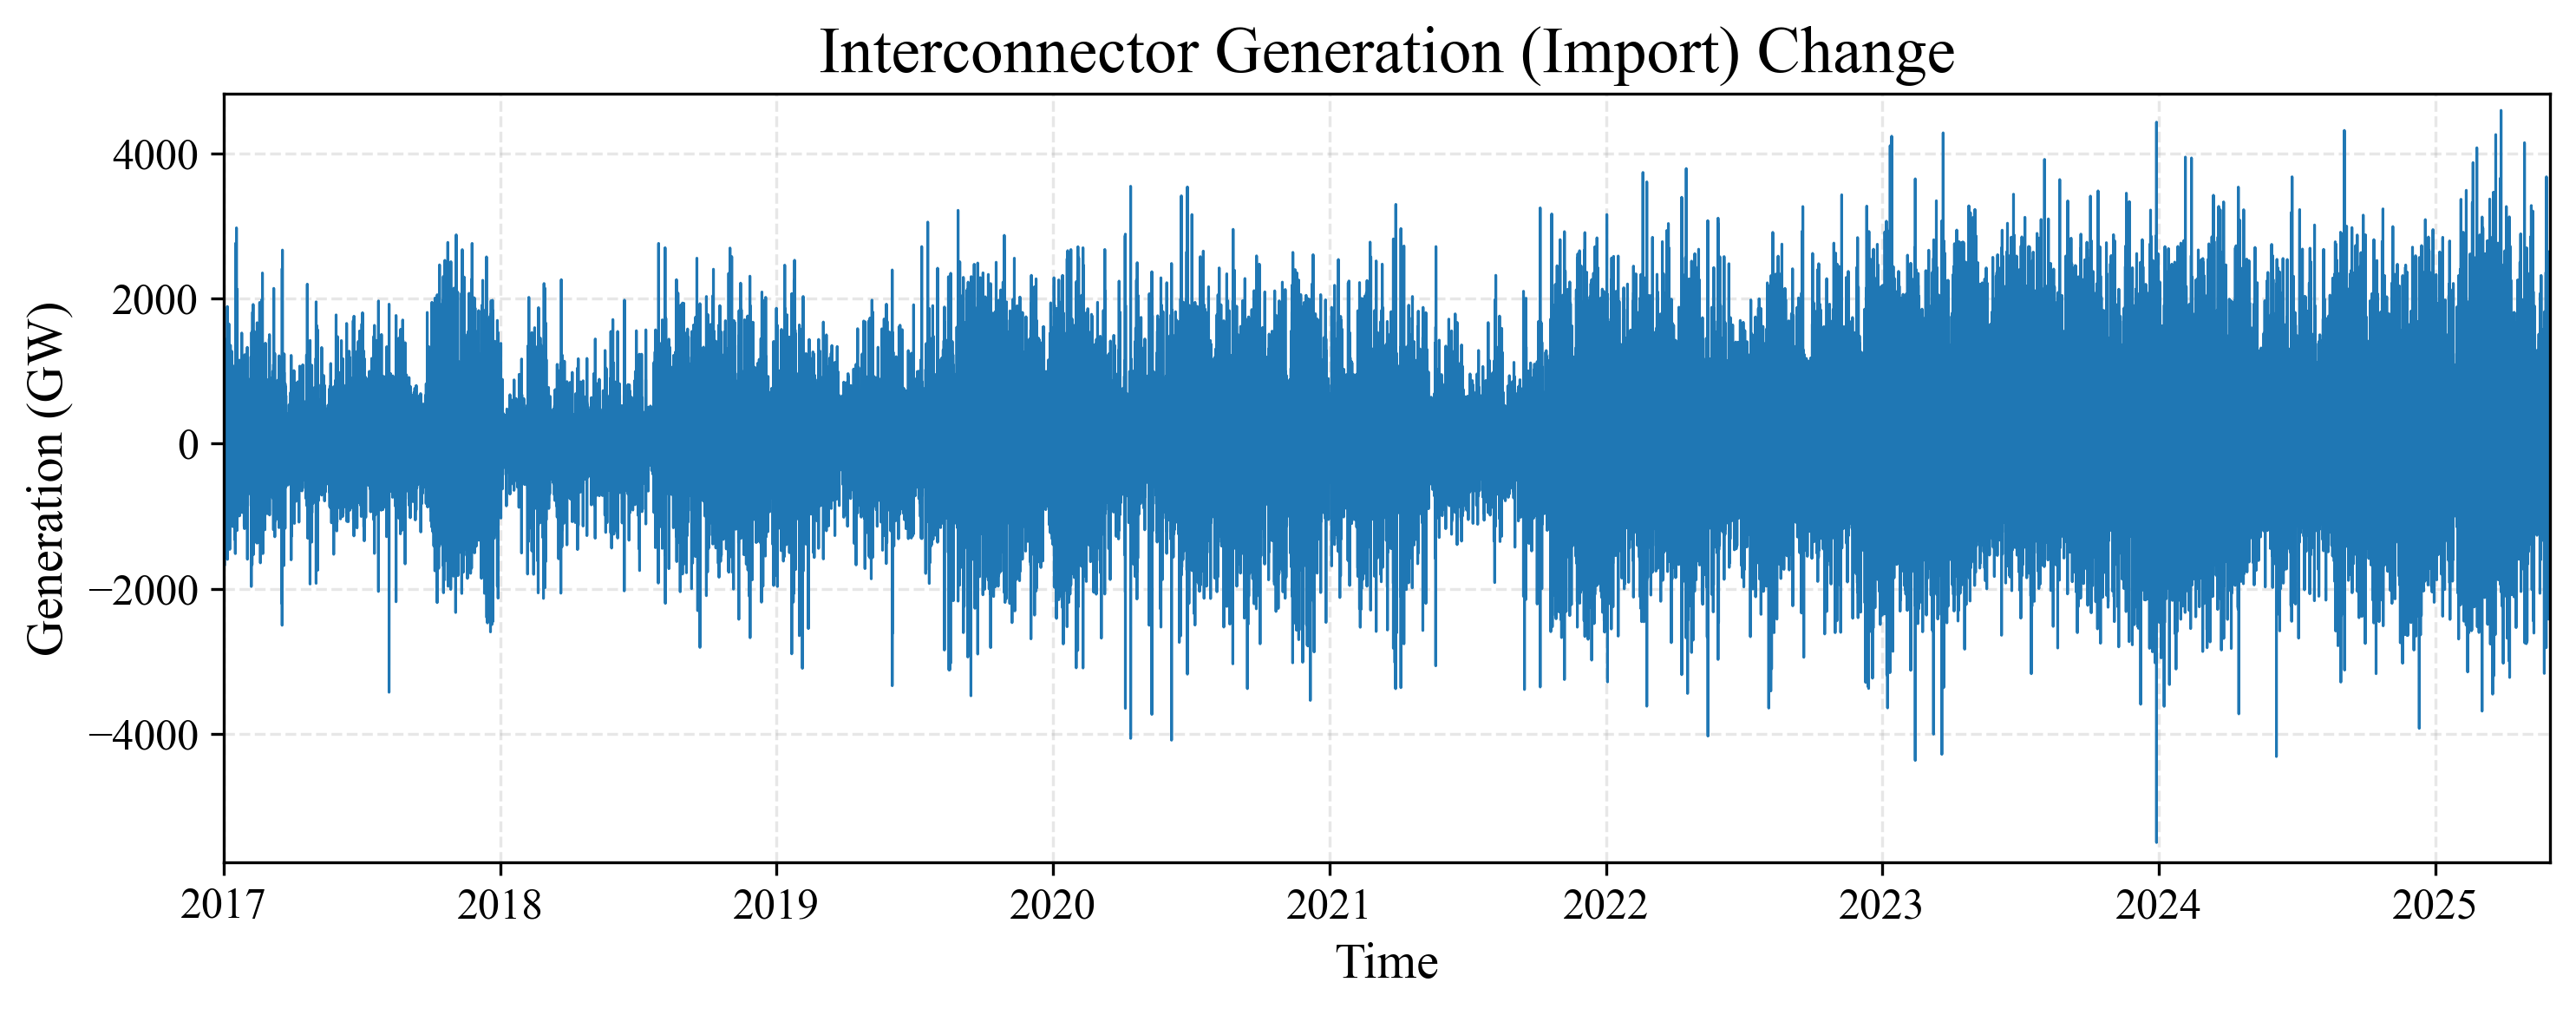

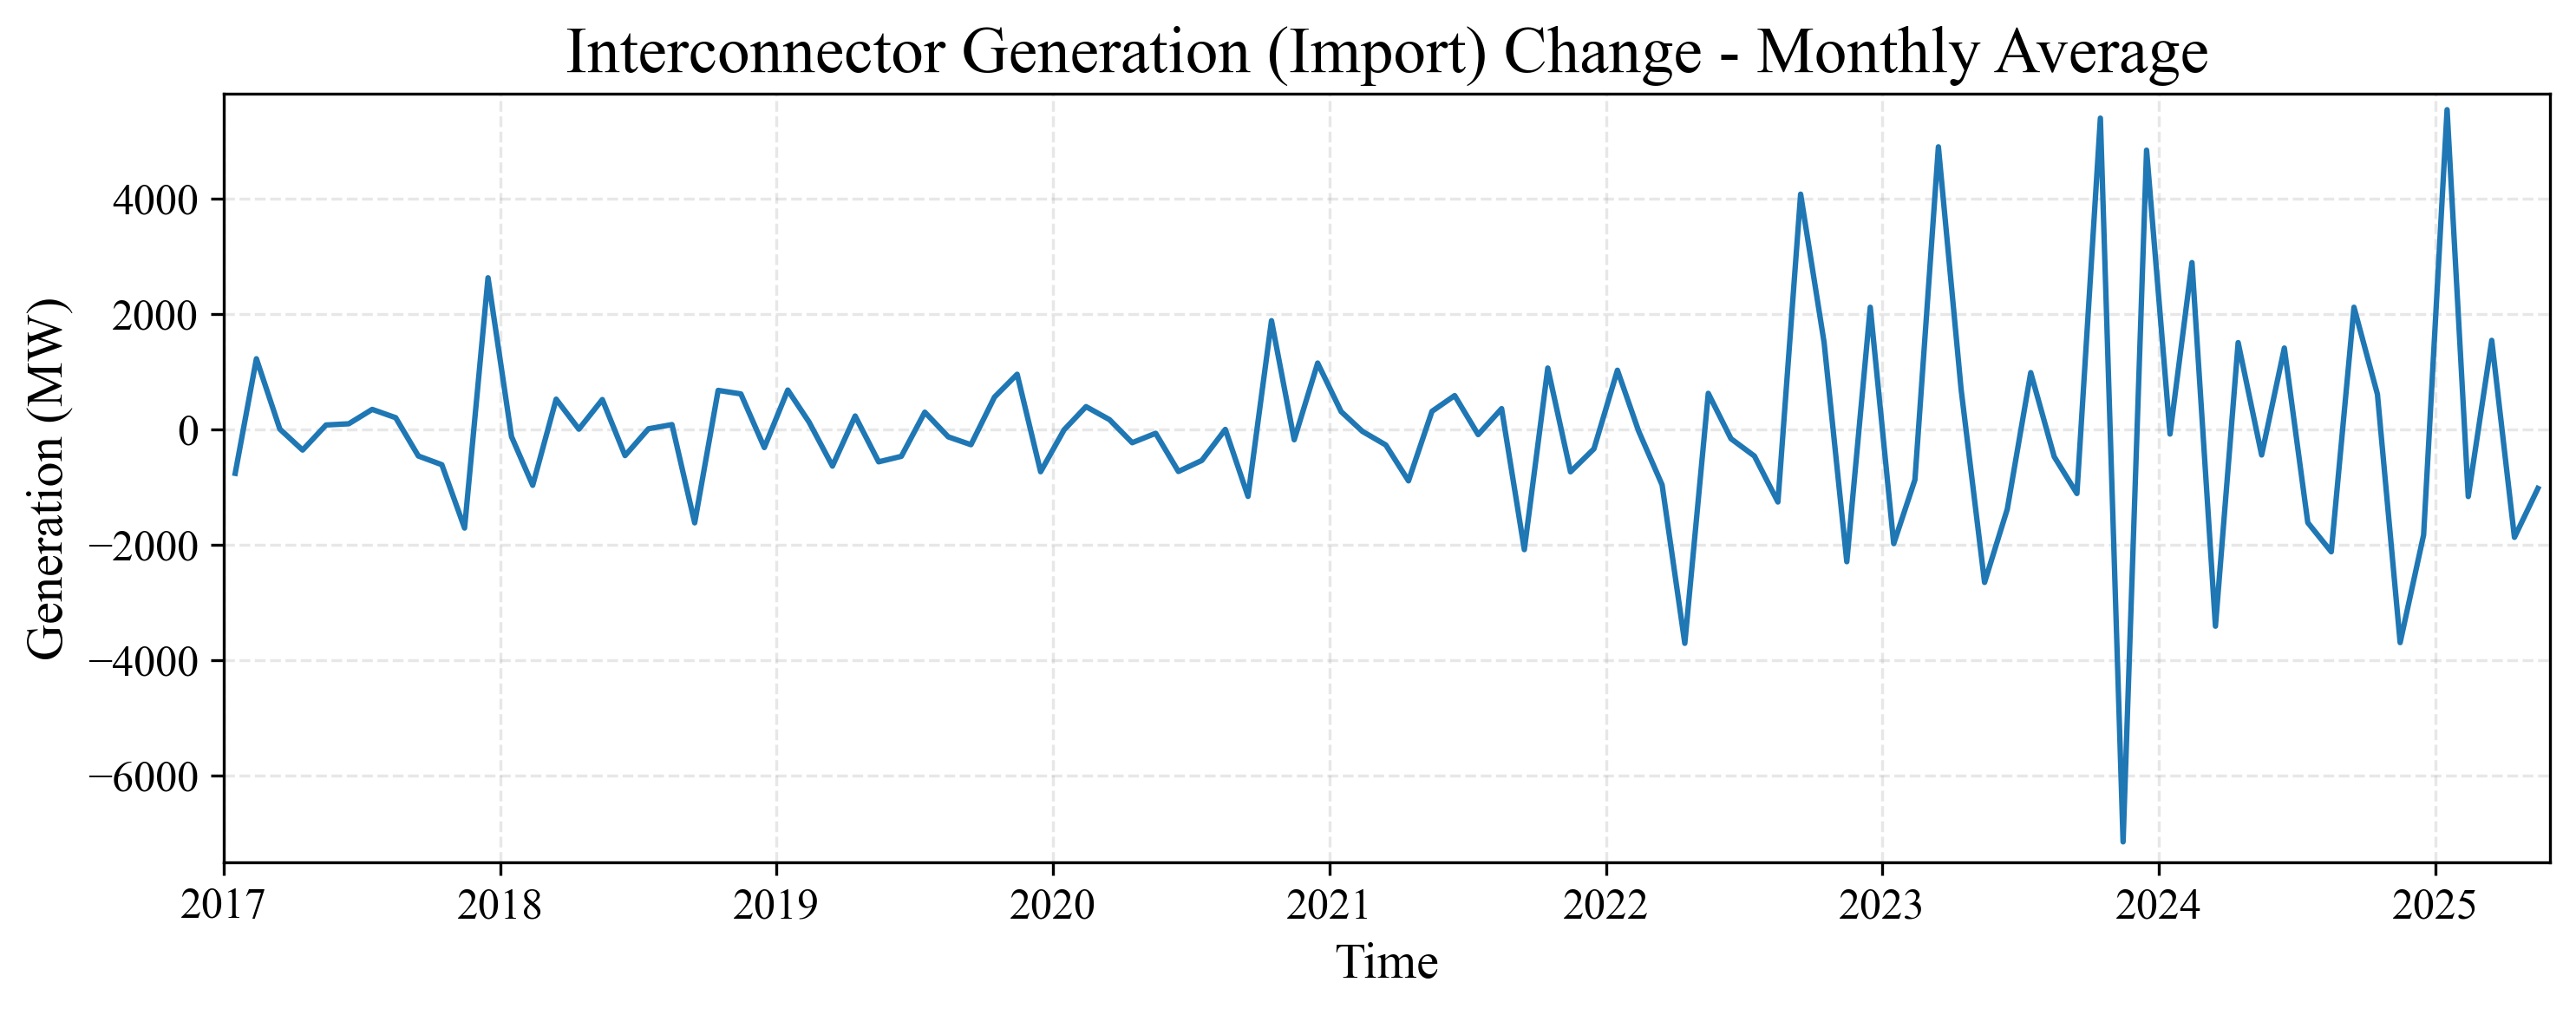

In [8]:
monthly_inter_delta = inter_delta.resample("ME").mean().shift(freq='-15D') * 1_000

plt.figure(figsize=(10, 4))
plt.plot(inter_delta.index,  inter_delta.values, color='tab:blue', linewidth=0.75)
plt.title("Interconnector Generation (Import) Change")
plt.xlabel("Time")
plt.ylabel("Generation (GW)")
plt.xlim(inter_delta.index.min(), inter_delta.index.max())
plt.ylim(inter_delta.min() * 1.05, inter_delta.max() * 1.05)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(monthly_inter_delta.index,  monthly_inter_delta.values, color='tab:blue')
plt.title("Interconnector Generation (Import) Change - Monthly Average")
plt.xlabel("Time")
plt.ylabel("Generation (MW)")
plt.xlim(inter_delta.index.min(), inter_delta.index.max())
plt.ylim(monthly_inter_delta.min() * 1.05, monthly_inter_delta.max() * 1.05)
plt.tight_layout()
plt.show()

### De-Rated Margin

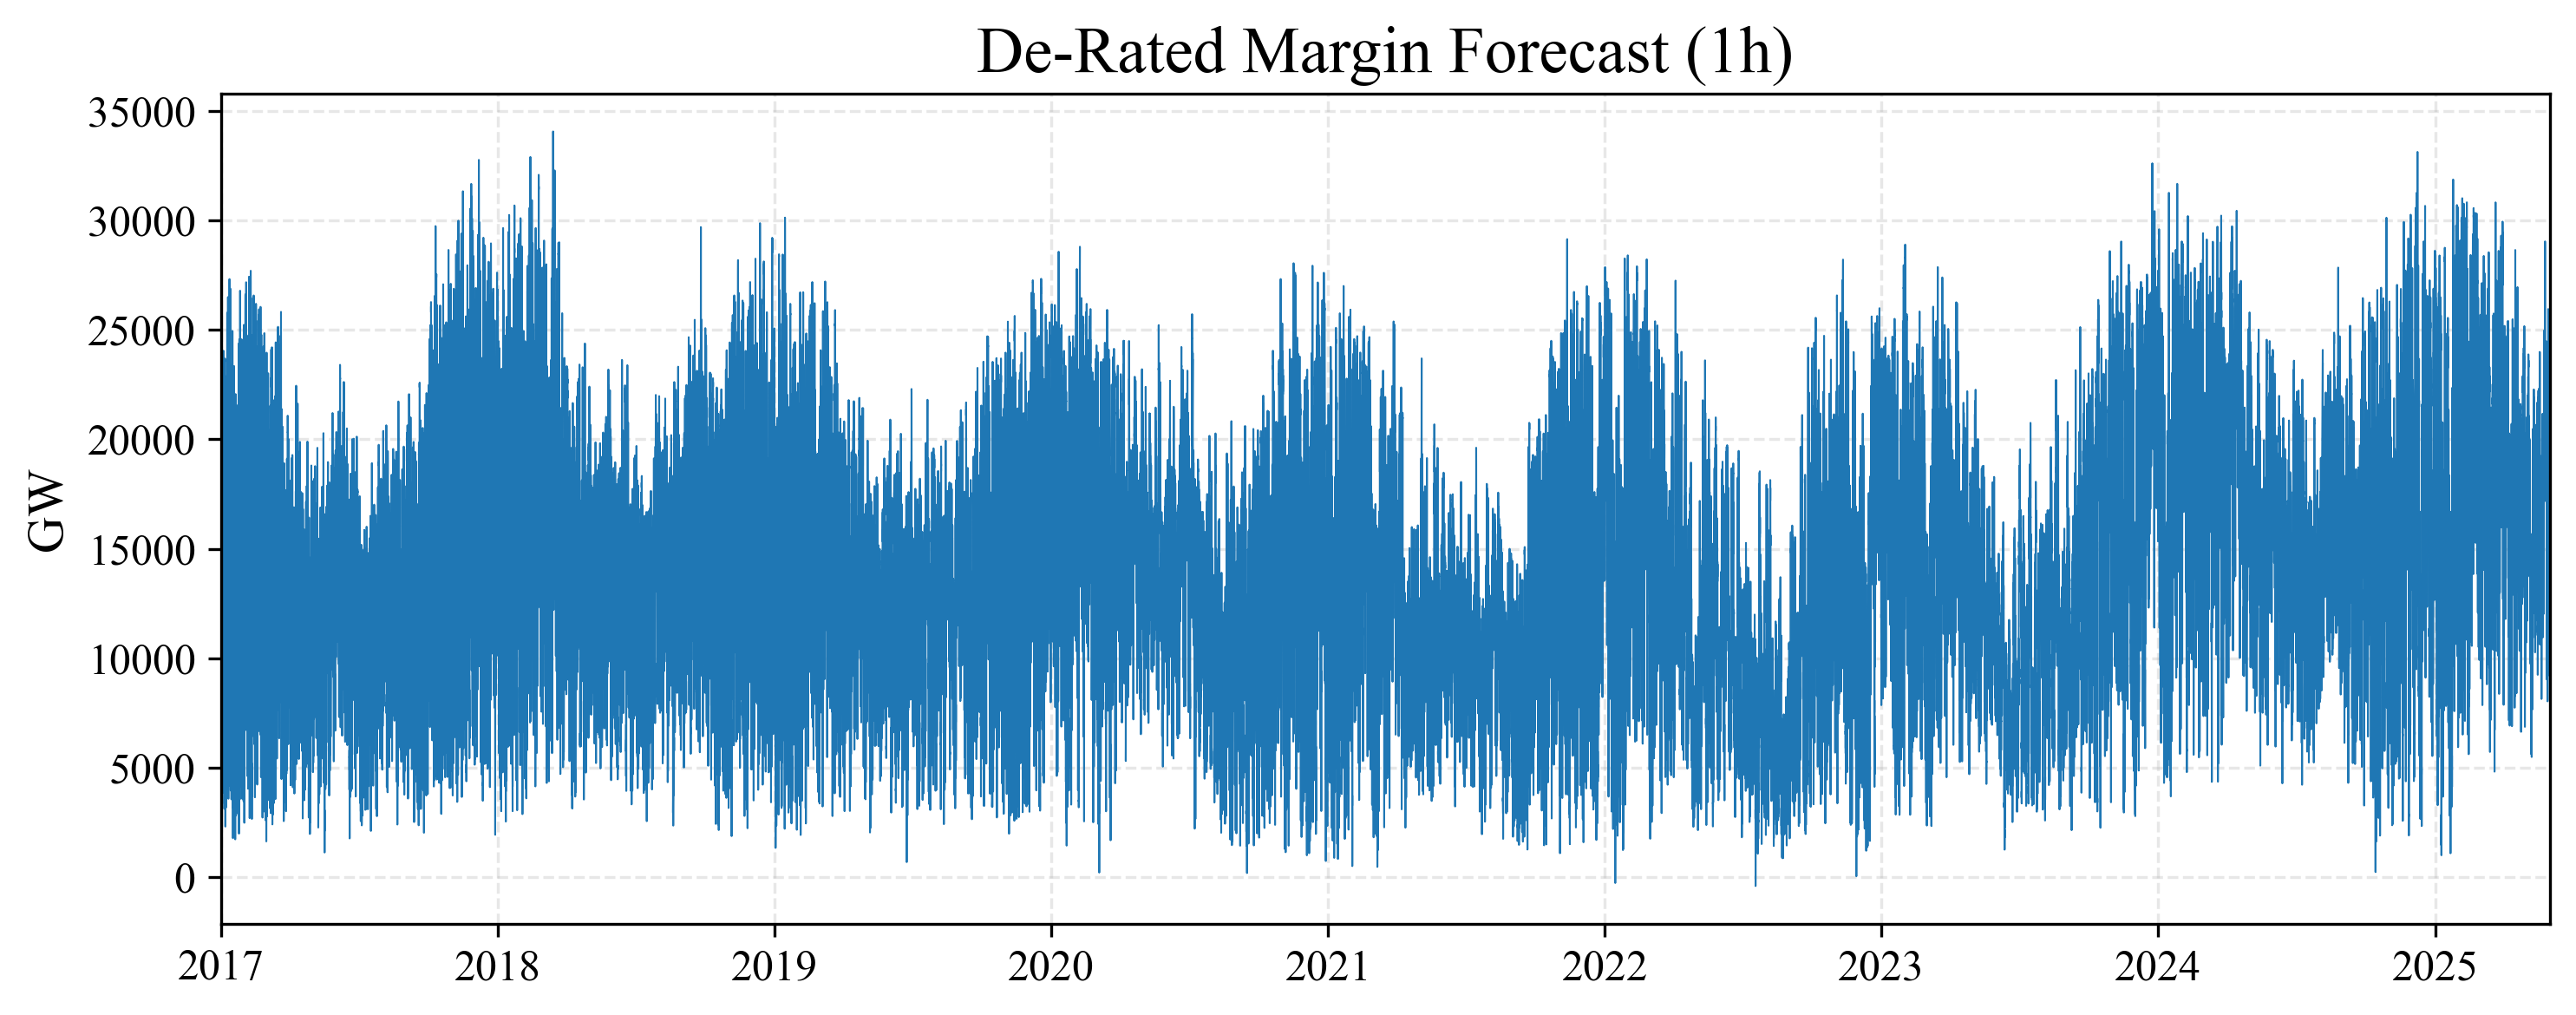

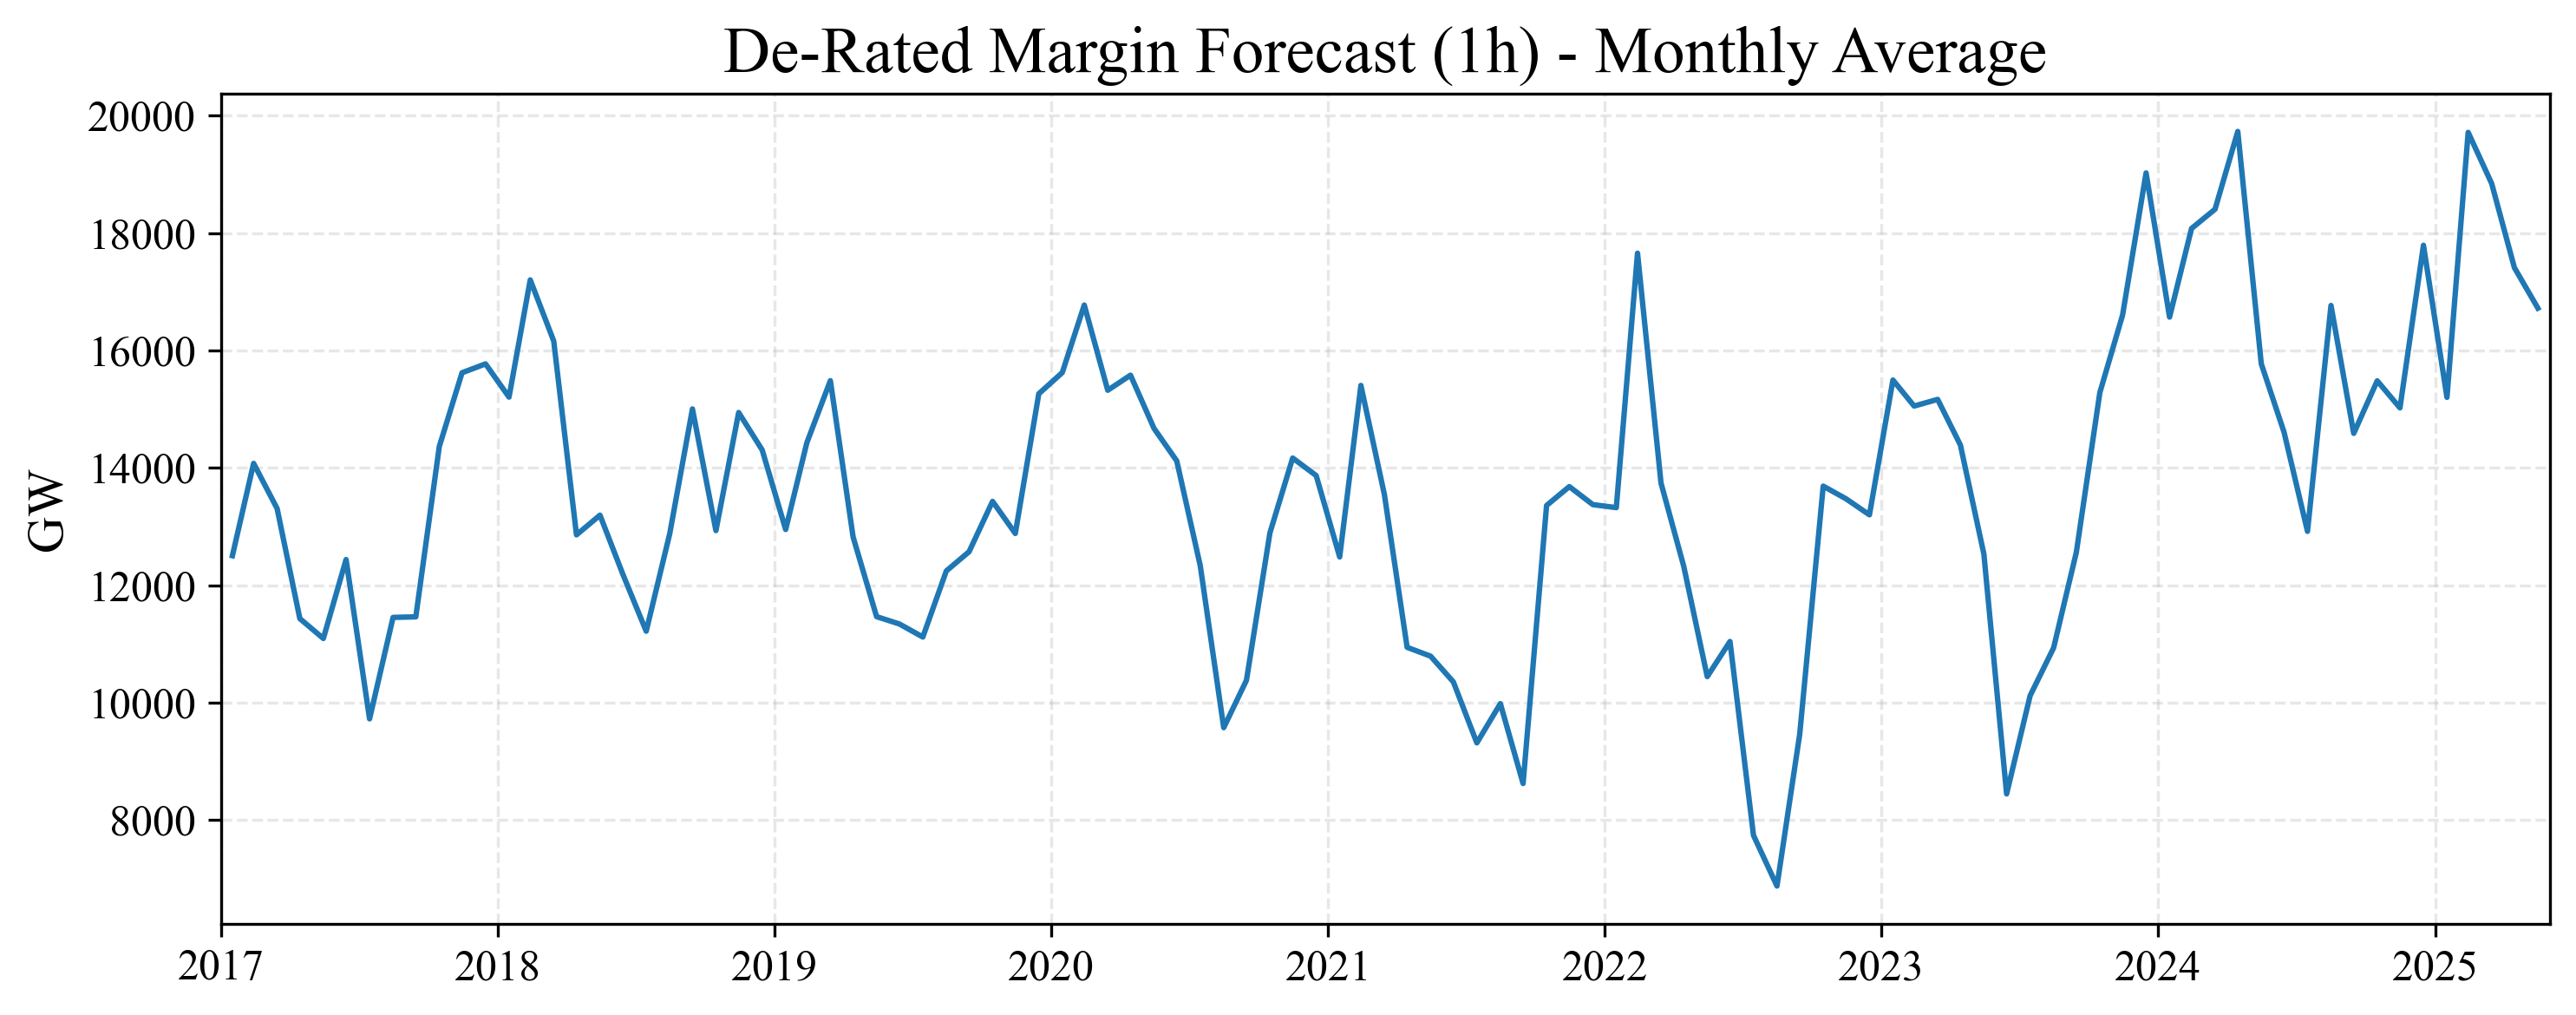

In [9]:
drm_monthly = drm_1h.resample("ME").mean().shift(freq='-15D')

plt.figure(figsize=(10, 4))
plt.plot(drm_1h.index,  drm_1h.values, color='tab:blue', linewidth=0.5)
plt.title("De-Rated Margin Forecast (1h)")
plt.ylabel("GW")
plt.xlim(drm_1h.index.min(), drm_1h.index.max())
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(drm_monthly.index,  drm_monthly.values, color='tab:blue')
plt.title("De-Rated Margin Forecast (1h) - Monthly Average")
plt.ylabel("GW")
plt.xlim(drm_1h.index.min(), drm_1h.index.max())
plt.tight_layout()
plt.show()


### Z-Score

In [10]:
from ipywidgets import VBox

checkboxes = [Checkbox(value=False, description=col) for col in df_z.columns]

def plot_selected(**kwargs):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    lines = []
    labels = []

    for name, checked in kwargs.items():
        if checked:
            # Plot with thin line but store thick legend handle
            line, = ax.plot(df_z.index, df_z[name], label=name, linewidth=0.5, alpha=0.8)
            # Create custom legend handle with thicker line
            legend_line = Line2D(
                [0], [0],
                color=line.get_color(),
                linewidth=2.5,
                label=name
            )
            lines.append(legend_line)
            labels.append(name)

    ax.set_xlabel("Time")
    ax.set_ylabel("Z-score")
    ax.set_xlim(df_z.index.min(), df_z.index.max())

    if lines:
        ax.legend(handles=lines, labels=labels, loc="upper left", ncol=2)

    plt.tight_layout()
    plt.show()

cb_dict = {cb.description: cb for cb in checkboxes}
output = interactive_output(plot_selected, cb_dict)

half = len(checkboxes) // 2 + len(checkboxes) % 2
row1 = HBox(checkboxes[:half])
row2 = HBox(checkboxes[half:])

display(VBox([row1, row2]), output)


Output()

In [11]:
from ipywidgets import HBox, Checkbox, interactive_output
import matplotlib.pyplot as plt
from IPython.display import display

# 1) Create checkboxes for each column
checkboxes = [Checkbox(value=False, description=col) for col in df_z.columns]

# 2) Create a dictionary for checkbox widgets
cb_dict = {cb.description: cb for cb in checkboxes}

# 3) Define plotting function
def plot_bell_curves(**kwargs):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    added_any = False

    for i, col in enumerate(df_z.columns):
        if kwargs.get(col, False):
            data = df_z[col].dropna()
            ax.hist(
                data,
                bins=100,
                density=True,
                alpha=0.4,
                label=col,
                linewidth=0.75,
                histtype="stepfilled",
                color=tab_colours[i % len(tab_colours)]
            )
            added_any = True

    ax.set_xlabel("Z-score")
    ax.set_ylabel("Density")
    ax.set_title("Z-Score Distributions")

    if added_any:
        ax.legend()

    plt.tight_layout()
    plt.show()

# 4) Link checkbox values to plotting function
output = interactive_output(plot_bell_curves, {k: v for k, v in cb_dict.items()})

half = len(checkboxes) // 2 + len(checkboxes) % 2
row1 = HBox(checkboxes[:half])
row2 = HBox(checkboxes[half:])

display(VBox([row1, row2]), output)

Output()

In [12]:
day, week, month = 48, 336, 1460
volatility_series = {
    "Imbalance Price": df_all["Imbalance Price"],
    "1-day Rolling σ":   df_all["Imbalance Price"].rolling(window=day).std(),
    "1-week Rolling σ":  df_all["Imbalance Price"].rolling(window=week).std(),
    "1-month Rolling σ": df_all["Imbalance Price"].rolling(window=month).std(),
}

tab_colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

checkboxes = [Checkbox(value=(k == "1-week Rolling σ"), description=k)
              for k in volatility_series]
cb_dict = {cb.description: cb for cb in checkboxes}

def plot_vol(**kwargs):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    lines = []
    for i, name in enumerate(volatility_series):
        if kwargs.get(name, False):
            data  = volatility_series[name]
            colour = tab_colours[i % len(tab_colours)]
            line, = ax.plot(data.index, data,
                            label=name,
                            linewidth=0.75,
                            alpha=0.75,
                            color=colour)
            lines.append(Line2D([0], [0], color=colour, linewidth=2.5, label=name))

    ax.set_xlabel("Time")
    ax.set_ylabel("Price Volatility (£/MWh)")
    ax.set_xlim(df_all.index.min(), df_all.index.max())
    if lines:
        ax.legend(handles=lines, loc="upper left")
    plt.tight_layout()
    plt.show()

output = interactive_output(plot_vol, cb_dict)

display(HBox(checkboxes), output)

Output()

### Correlation Matrix

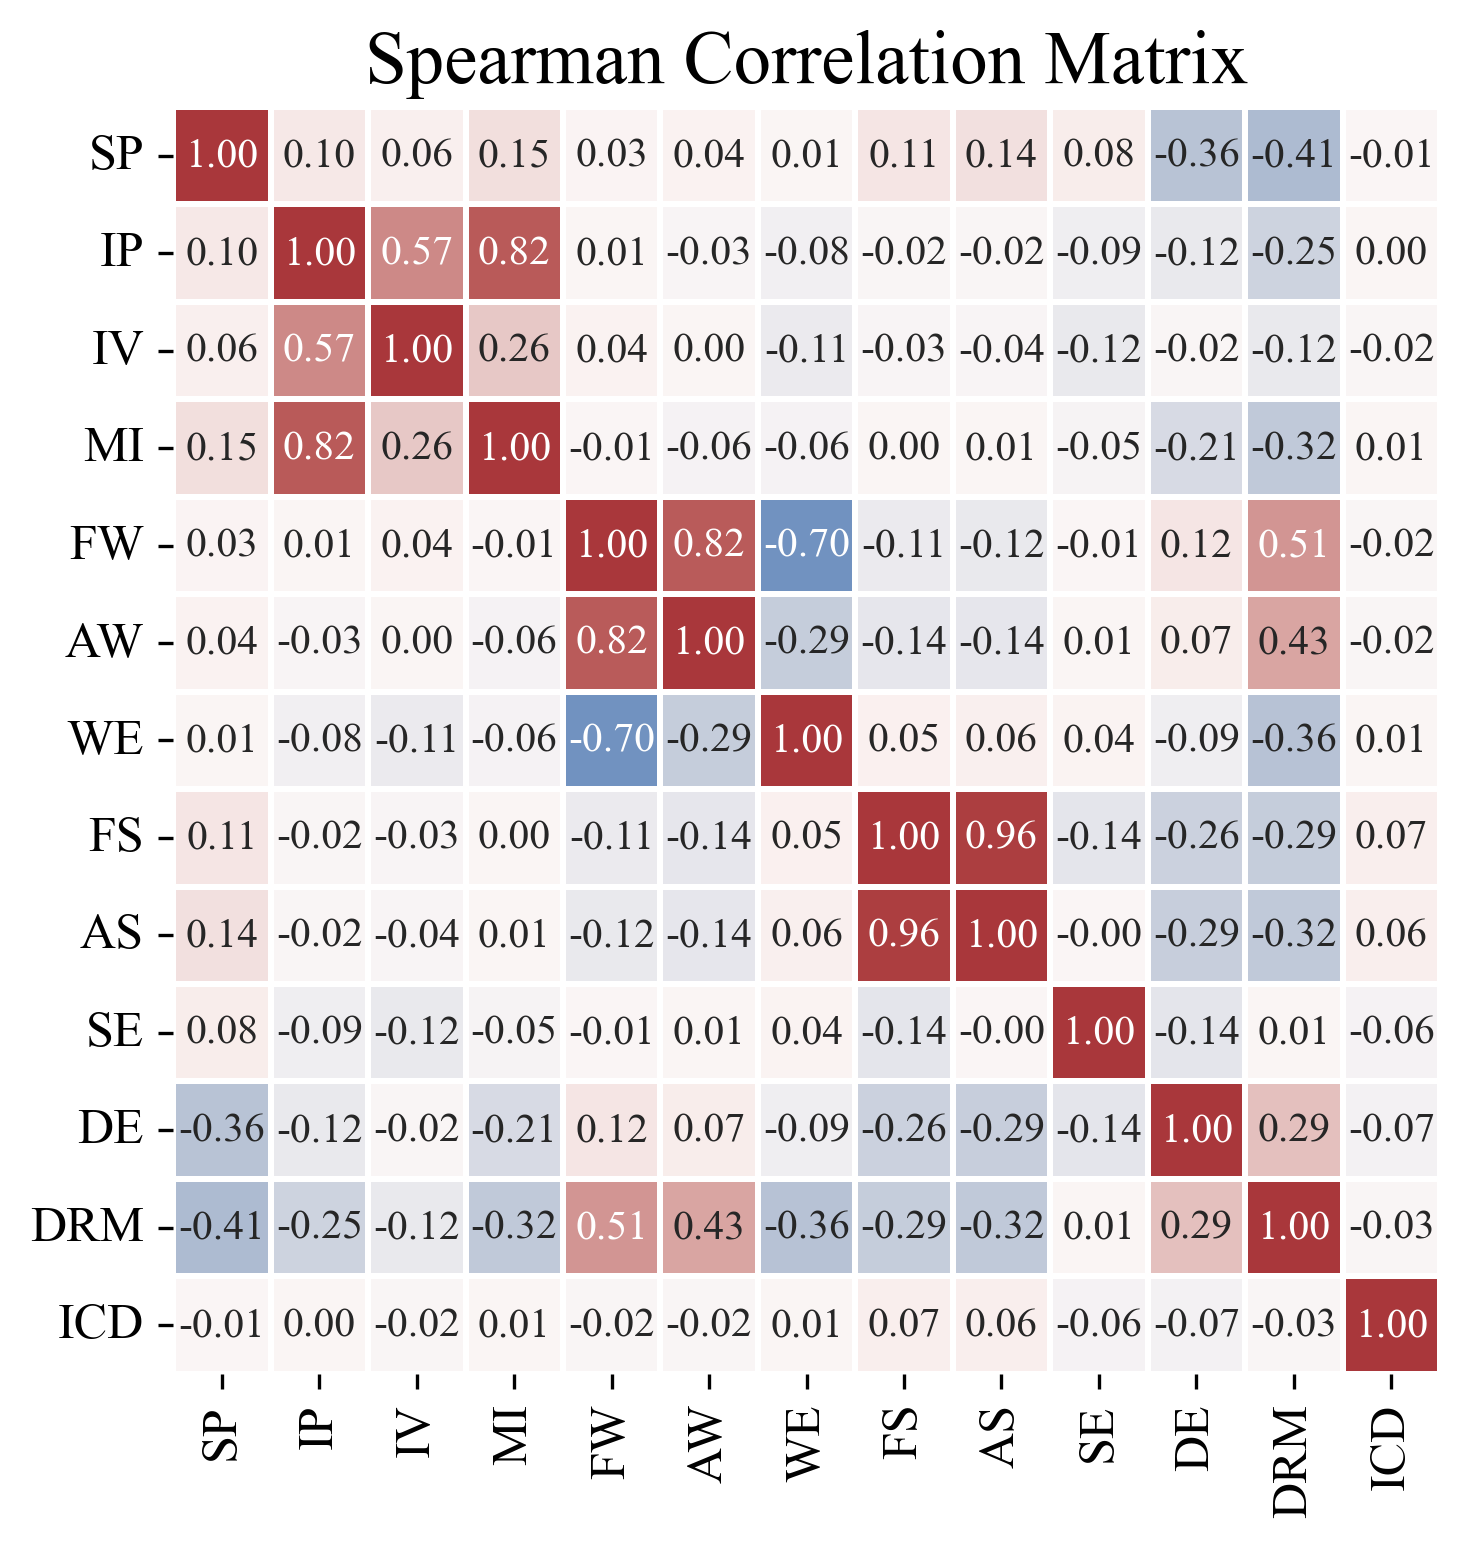

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df_all.rename(columns={
    "Imbalance Price":      "IP",
    "Imbalance Volume":     "IV",
    "Market Index":         "MI",
    "Forecast Wind":        "FW",
    "Forecast Solar":       "FS",
    "Actual Wind":          "AW",
    "Actual Solar":         "AS",
    "Wind Error":           "WE",
    "Solar Error":          "SE",
    "Demand Error":         "DE",
    "De-Rated Margin (1h)": "DRM",
    "Inter Delta":          "ICD",
    "Settlement Period":     "SP"
})

corr_matrix = df_corr.corr(method='spearman')

plt.figure(figsize=(5, 6), dpi=300)
plt.title("Spearman Correlation Matrix")
sns.heatmap(
    corr_matrix,
    annot=True,
    square=True,
    fmt=".2f",
    cmap="vlag",
    cbar=False,
    center=0,
    vmax=1,
    vmin=-1,
    linewidths=1,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.grid(False)
plt.tight_layout()
plt.show()


### Data and System Length

In [14]:
import numpy as np

# List of columns and labels
cols = df_all.columns.tolist()

# Helper to calculate stats
def get_stats(df, label):
    stats = df[cols].agg(["mean", "std", "min", "max"]).T.reset_index()
    stats.insert(0, "Condition", label)
    return stats.rename(columns={"index": "Variable", "std": "stddev"})

# Calculate stats for all, short, and long conditions
all_stats   = get_stats(df_all, "All")
short_stats = get_stats(df_all[df_all["Imbalance Volume"] > 0], "Short (NIV > 0)")
long_stats  = get_stats(df_all[df_all["Imbalance Volume"] < 0], "Long (NIV < 0)")

# Combine and preserve float types by inserting np.nan instead of ""
combined_stats = pd.concat([all_stats, short_stats, long_stats])

output_rows = []
for var in cols:
    chunk = combined_stats[combined_stats["Variable"] == var]
    output_rows.append(chunk)
    output_rows.append(
        pd.DataFrame([{
            "Condition": "", "Variable": "",
            "mean": np.nan, "stddev": np.nan,
            "min": np.nan, "max": np.nan
        }])
    )

final_table = pd.concat(output_rows, ignore_index=True)
final_table.round(2)


Condition              Variable      mean   stddev       min  \
0               All     Settlement Period     24.50    13.85      1.00   
1   Short (NIV > 0)     Settlement Period     25.31    13.67      1.00   
2    Long (NIV < 0)     Settlement Period     23.77    13.98      1.00   
3                                               NaN      NaN       NaN   
4               All       Imbalance Price     82.64    97.38   -185.33   
5   Short (NIV > 0)       Imbalance Price    120.97   121.90    -30.99   
6    Long (NIV < 0)       Imbalance Price     48.01    45.80   -185.33   
7                                               NaN      NaN       NaN   
8               All      Imbalance Volume    -25.95   332.32  -2283.46   
9   Short (NIV > 0)      Imbalance Volume    235.73   213.79      0.00   
10   Long (NIV < 0)      Imbalance Volume   -262.39   226.18  -2283.46   
11                                              NaN      NaN       NaN   
12              All          Market Index     81.87    72.81    -77.29   
13  Short (NIV > 0)          Market Index     94.18    80.01    -32.93   
14   Long (NIV < 0)          Market Index     70.75    63.61    -77.29   
15                                              NaN      NaN       NaN   
16              All         Forecast Wind   7943.17  5097.40    109.16   
17  Short (NIV > 0)         Forecast Wind   8127.13  5074.30    110.36   
18   Long (NIV < 0)         Forecast Wind   7777.36  5112.51    109.16   
19                                              NaN      NaN       NaN   
20              All           Actual Wind   5720.70  4052.07      0.00   
21  Short (NIV > 0)           Actual Wind   5749.11  4037.77      0.00   
22   Long (NIV < 0)           Actual Wind   5695.32  4064.76      0.00   
23                                              NaN      NaN       NaN   
24              All            Wind Error  -2215.15  2670.19 -20410.22   
25  Short (NIV > 0)            Wind Error  -2383.61  2633.16 -20410.22   
26   Long (NIV < 0)            Wind Error  -2063.07  2694.25 -20362.89   
27                                              NaN      NaN       NaN   
28              All        Forecast Solar   1334.81  2047.91      0.00   
29  Short (NIV > 0)        Forecast Solar   1193.68  1866.78      0.00   
30   Long (NIV < 0)        Forecast Solar   1462.15  2190.82      0.00   
31                                              NaN      NaN       NaN   
32              All          Actual Solar   1302.95  2044.23      0.00   
33  Short (NIV > 0)          Actual Solar   1105.80  1779.42      0.00   
34   Long (NIV < 0)          Actual Solar   1480.93  2241.98      0.00   
35                                              NaN      NaN       NaN   
36              All           Solar Error    -31.86   426.73  -6096.00   
37  Short (NIV > 0)           Solar Error    -87.88   419.01  -4988.00   
38   Long (NIV < 0)           Solar Error     18.78   427.28  -6096.00   
39                                              NaN      NaN       NaN   
40              All          Demand Error    457.95  1530.35  -7003.12   
41  Short (NIV > 0)          Demand Error    385.59  1432.11  -7003.12   
42   Long (NIV < 0)          Demand Error    529.35  1618.44  -6132.49   
43                                              NaN      NaN       NaN   
44              All  De-Rated Margin (1h)  13612.29  5787.26   -399.89   
45  Short (NIV > 0)  De-Rated Margin (1h)  12960.12  5652.78   -314.29   
46   Long (NIV < 0)  De-Rated Margin (1h)  14201.95  5843.96   -399.89   
47                                              NaN      NaN       NaN   
48              All           Inter Delta     -0.01   488.98  -5499.63   
49  Short (NIV > 0)           Inter Delta    -14.62   491.28  -4368.00   
50   Long (NIV < 0)           Inter Delta     13.20   486.54  -5499.63   
51                                              NaN      NaN       NaN   

         max  
0      50.00  
1      50.00  
2      50.00  
3        NaN  
4    4037.80

### Stats

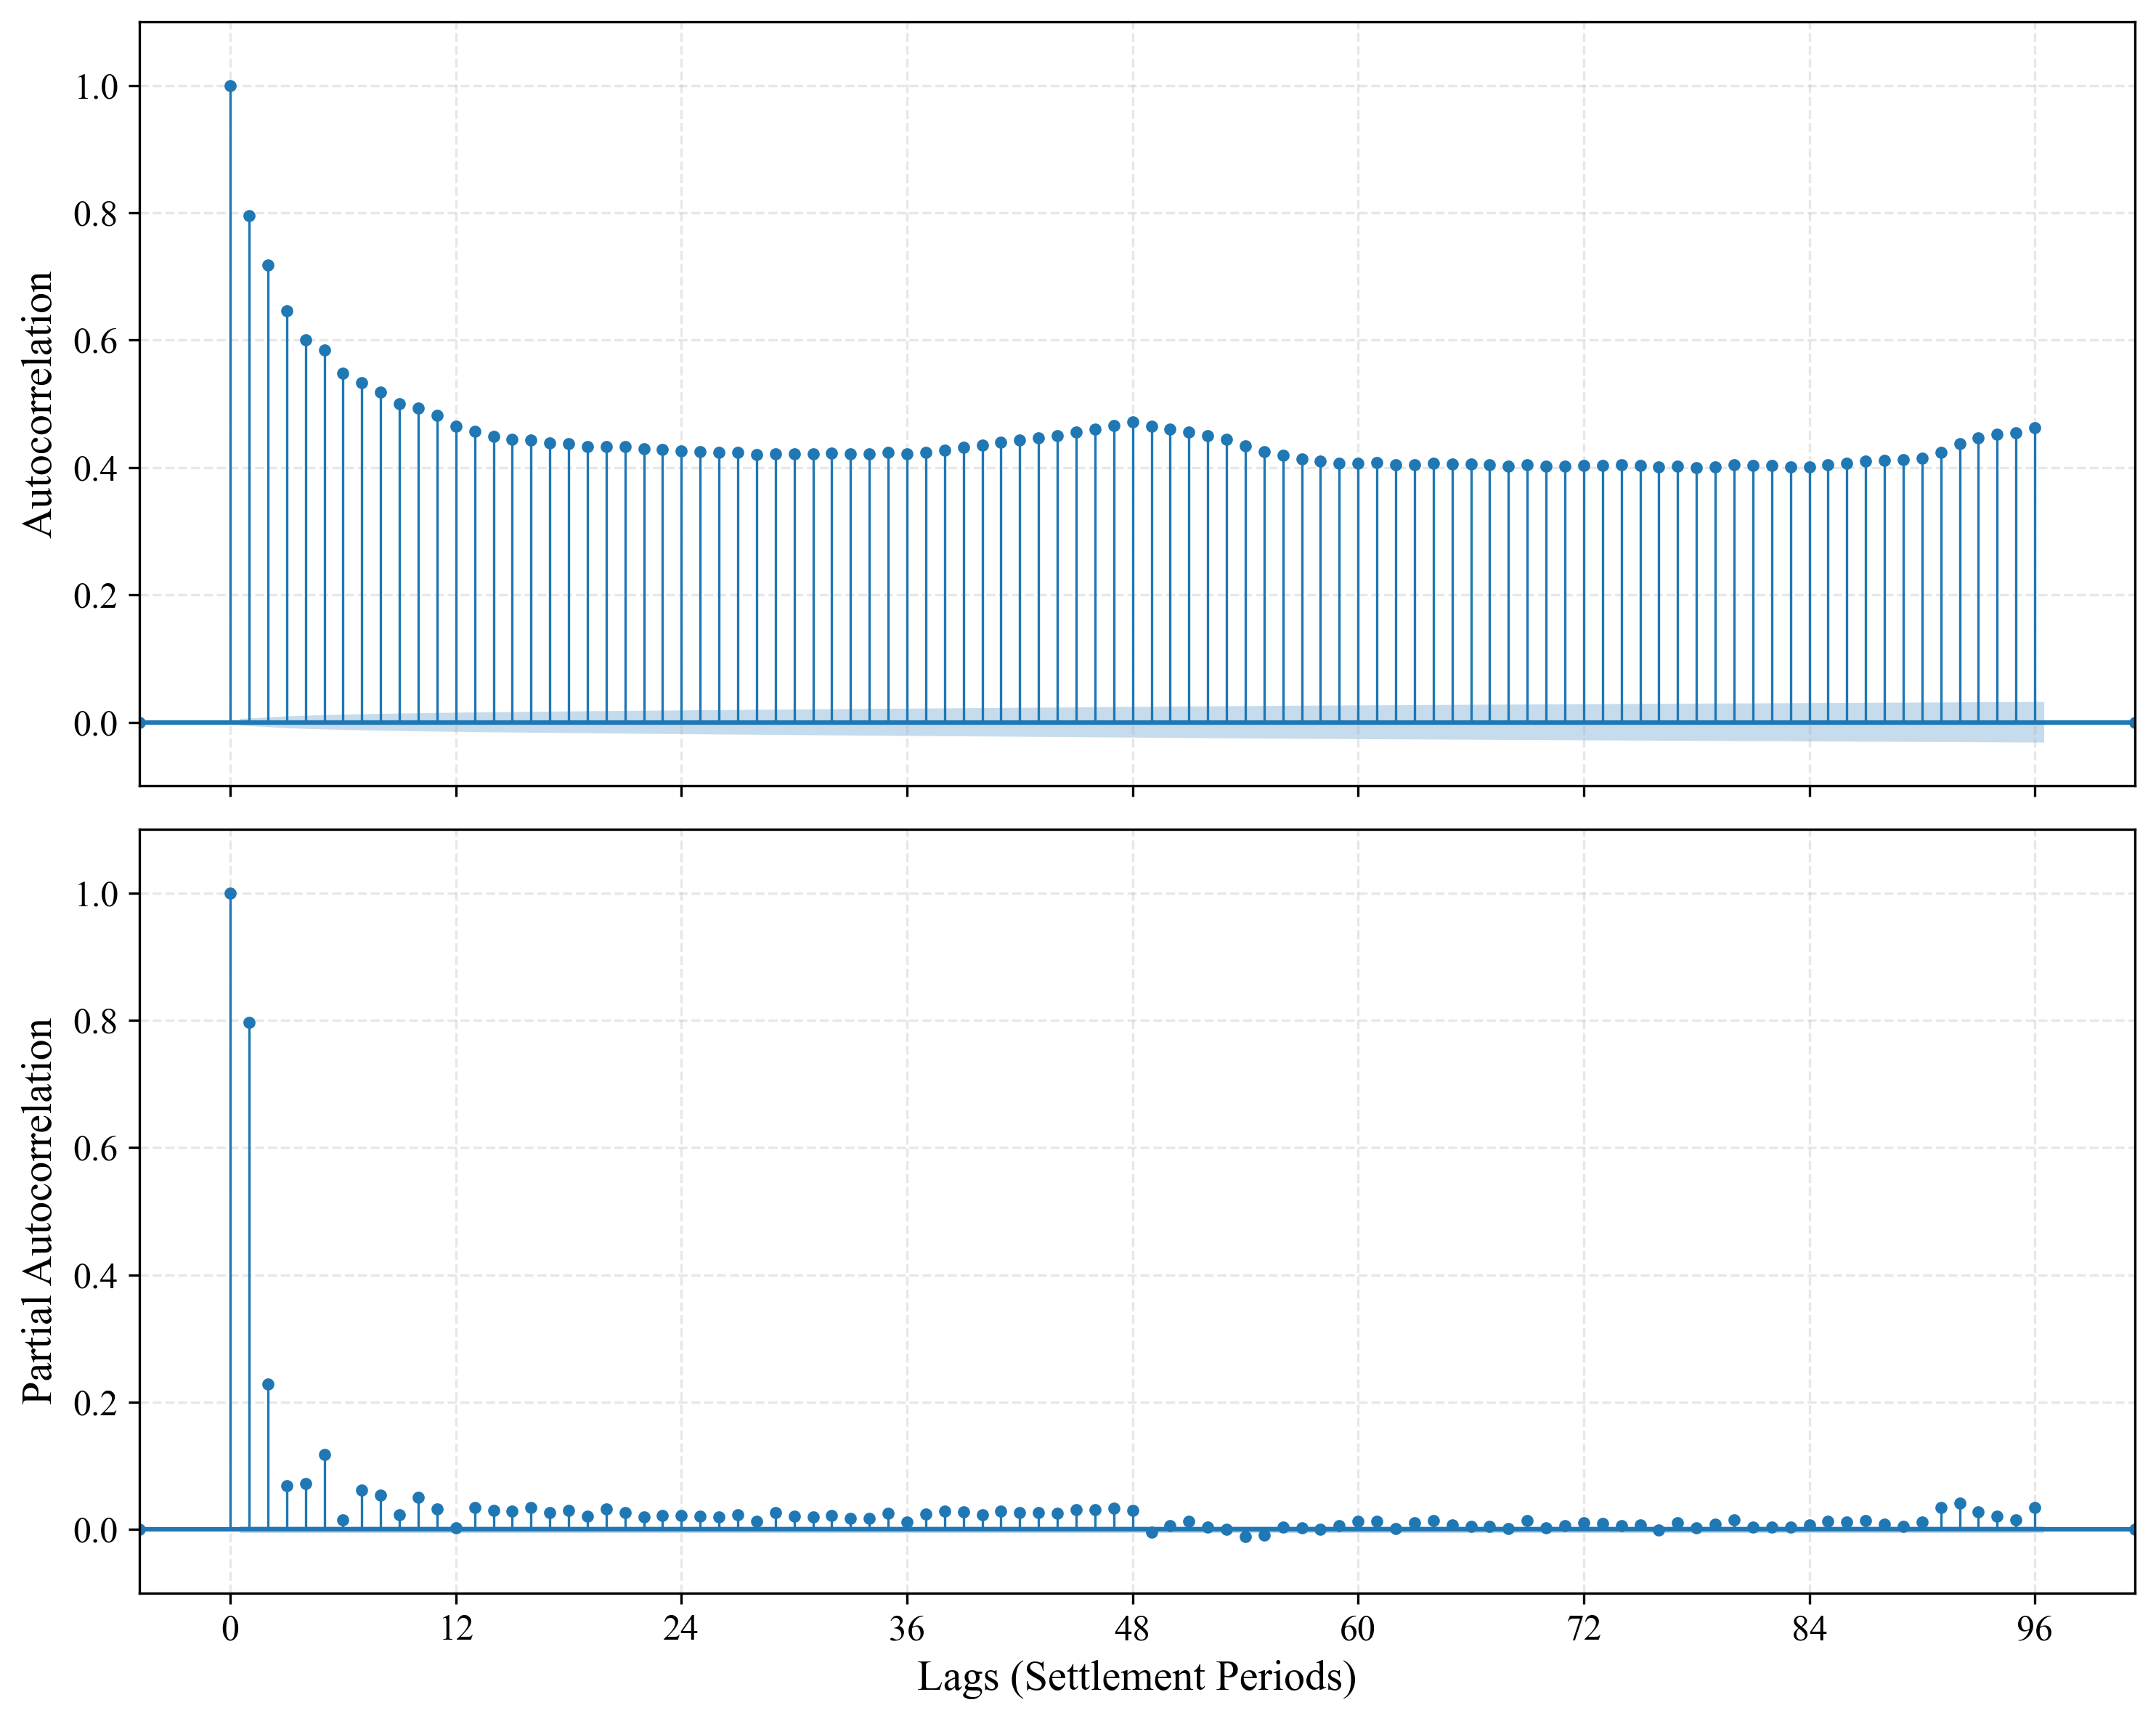

In [15]:
df_all_crop = df_all.loc["2017-01-01":"2025-05-31"]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=300)

# ACF plot
plot_acf(
    df_all_crop["Imbalance Price"],
    lags=96,
    ax=axes[0],
    marker='o',
    markersize=3,
    vlines_kwargs={'linewidth': 0.8},
    auto_ylims=True
)
axes[0].set_ylabel("Autocorrelation")
axes[0].set_ylim(-0.1, 1.1)
axes[0].set_xticks(np.arange(0, 97, 12))
axes[0].tick_params(axis='x', labelbottom=False)
axes[0].set_title(None)

# PACF plot
plot_pacf(
    df_all_crop["Imbalance Price"],
    lags=96,
    ax=axes[1],
    method='ywm',
    marker='o',
    markersize=3,
    vlines_kwargs={'linewidth': 0.8},
    auto_ylims=True
)
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].set_ylim(-0.1, 1.1)
axes[1].set_xticks(np.arange(0, 97, 12))
axes[1].set_xlabel("Lags (Settlement Periods)")
axes[1].set_title(None)

plt.tight_layout()
plt.show()



In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.seasonal import STL
import ipywidgets as widgets
from IPython.display import display

result = STL(df_all['Imbalance Price'], period=48, robust=False, seasonal=23).fit()

months = pd.date_range('2017-01-01', '2024-05-01', freq='MS')
month_options = [(m.strftime('%Y-%m'), m) for m in months]

start_slider = widgets.SelectionSlider(
    options=month_options,
    description='Start month',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)
window_slider = widgets.IntSlider(
    min=1,
    max=12,
    step=1,
    value=12,
    description='Window (months)',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

controls = widgets.VBox(
    [start_slider, window_slider],
    layout=widgets.Layout(width='100%')
)

def plot(start, window):
    end = start + DateOffset(months=window)
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), dpi=300, sharex=True)
    axes[0].plot(df_all['Imbalance Price'].loc[start:end], linewidth=0.5)
    axes[0].set_ylabel('Observed')
    axes[1].plot(result.trend.loc[start:end], linewidth=0.5)
    axes[1].set_ylabel('Trend')
    axes[2].plot(result.seasonal.loc[start:end], linewidth=0.5)
    axes[2].set_ylabel('Seasonal')
    axes[3].plot(result.resid.loc[start:end], linewidth=0.5)
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('')
    fig.suptitle('STL Decomposition of Imbalance Price')
    plt.tight_layout()
    plt.show()

out = widgets.interactive_output(plot, {
    'start': start_slider,
    'window': window_slider
})

display(controls, out)


Output()

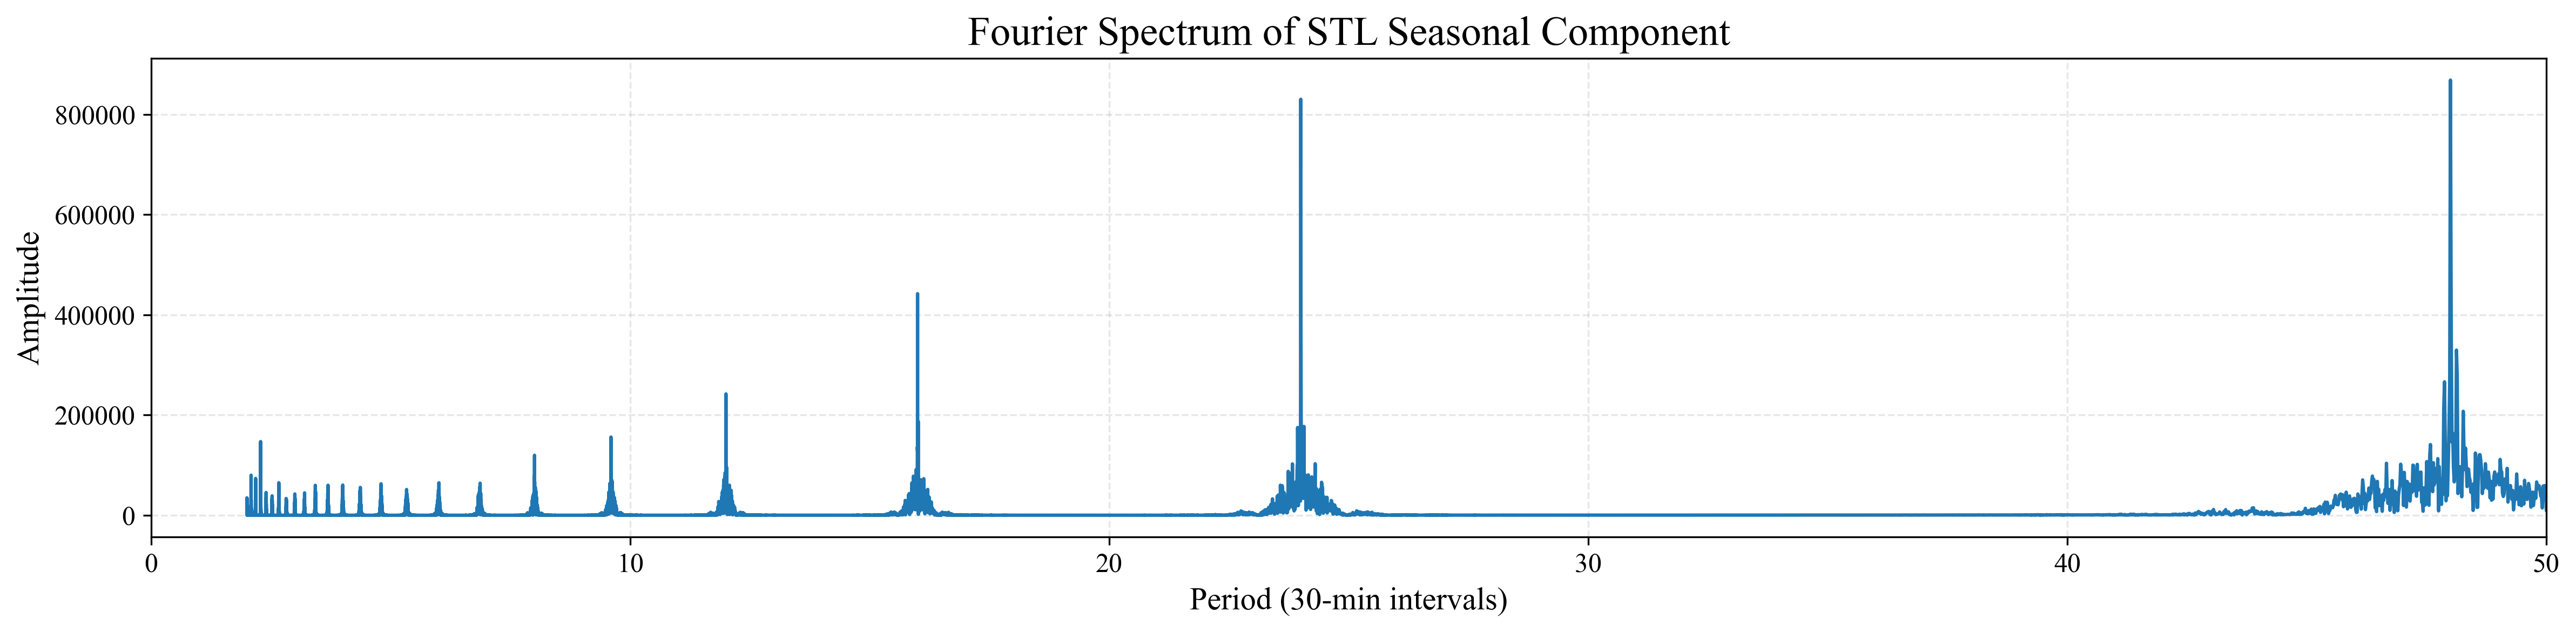

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Perform FFT on the seasonal component
fft = np.fft.fft(result.seasonal)
freqs = np.fft.fftfreq(len(result.seasonal), d=1)
amplitudes = np.abs(fft)

# Use only positive frequencies
half_n = len(result.seasonal) // 2
positive_freqs = freqs[:half_n]
positive_amplitudes = amplitudes[:half_n]

# Convert frequency to period (number of 30-minute intervals)
# Avoid division by zero
nonzero_freqs = positive_freqs[positive_freqs > 0]
periods = 1 / nonzero_freqs
amplitudes_trimmed = positive_amplitudes[positive_freqs > 0]

# Plot amplitude vs period
plt.figure(figsize=(16, 4), dpi=300)
plt.plot(periods, amplitudes_trimmed)
plt.xlabel("Period (30-min intervals)")
plt.xlim(0, 50)
plt.ylabel("Amplitude")
plt.title("Fourier Spectrum of STL Seasonal Component")
plt.grid(True)
plt.tight_layout()
plt.show()


## Explaining 2021/2022 Spikes

In [19]:
df_all_crop = df_all.loc["2021-01-01":"2022-12-31"]

threshold = 750

spikes = df_all_crop[df_all_crop["Imbalance Price"] > threshold]
rest = df_all_crop[df_all_crop["Imbalance Price"] <= threshold]

spikes_label = f"Spikes (>£{threshold})"
rest_label = f"Rest of Data (≤£{threshold})"

### Seasonality

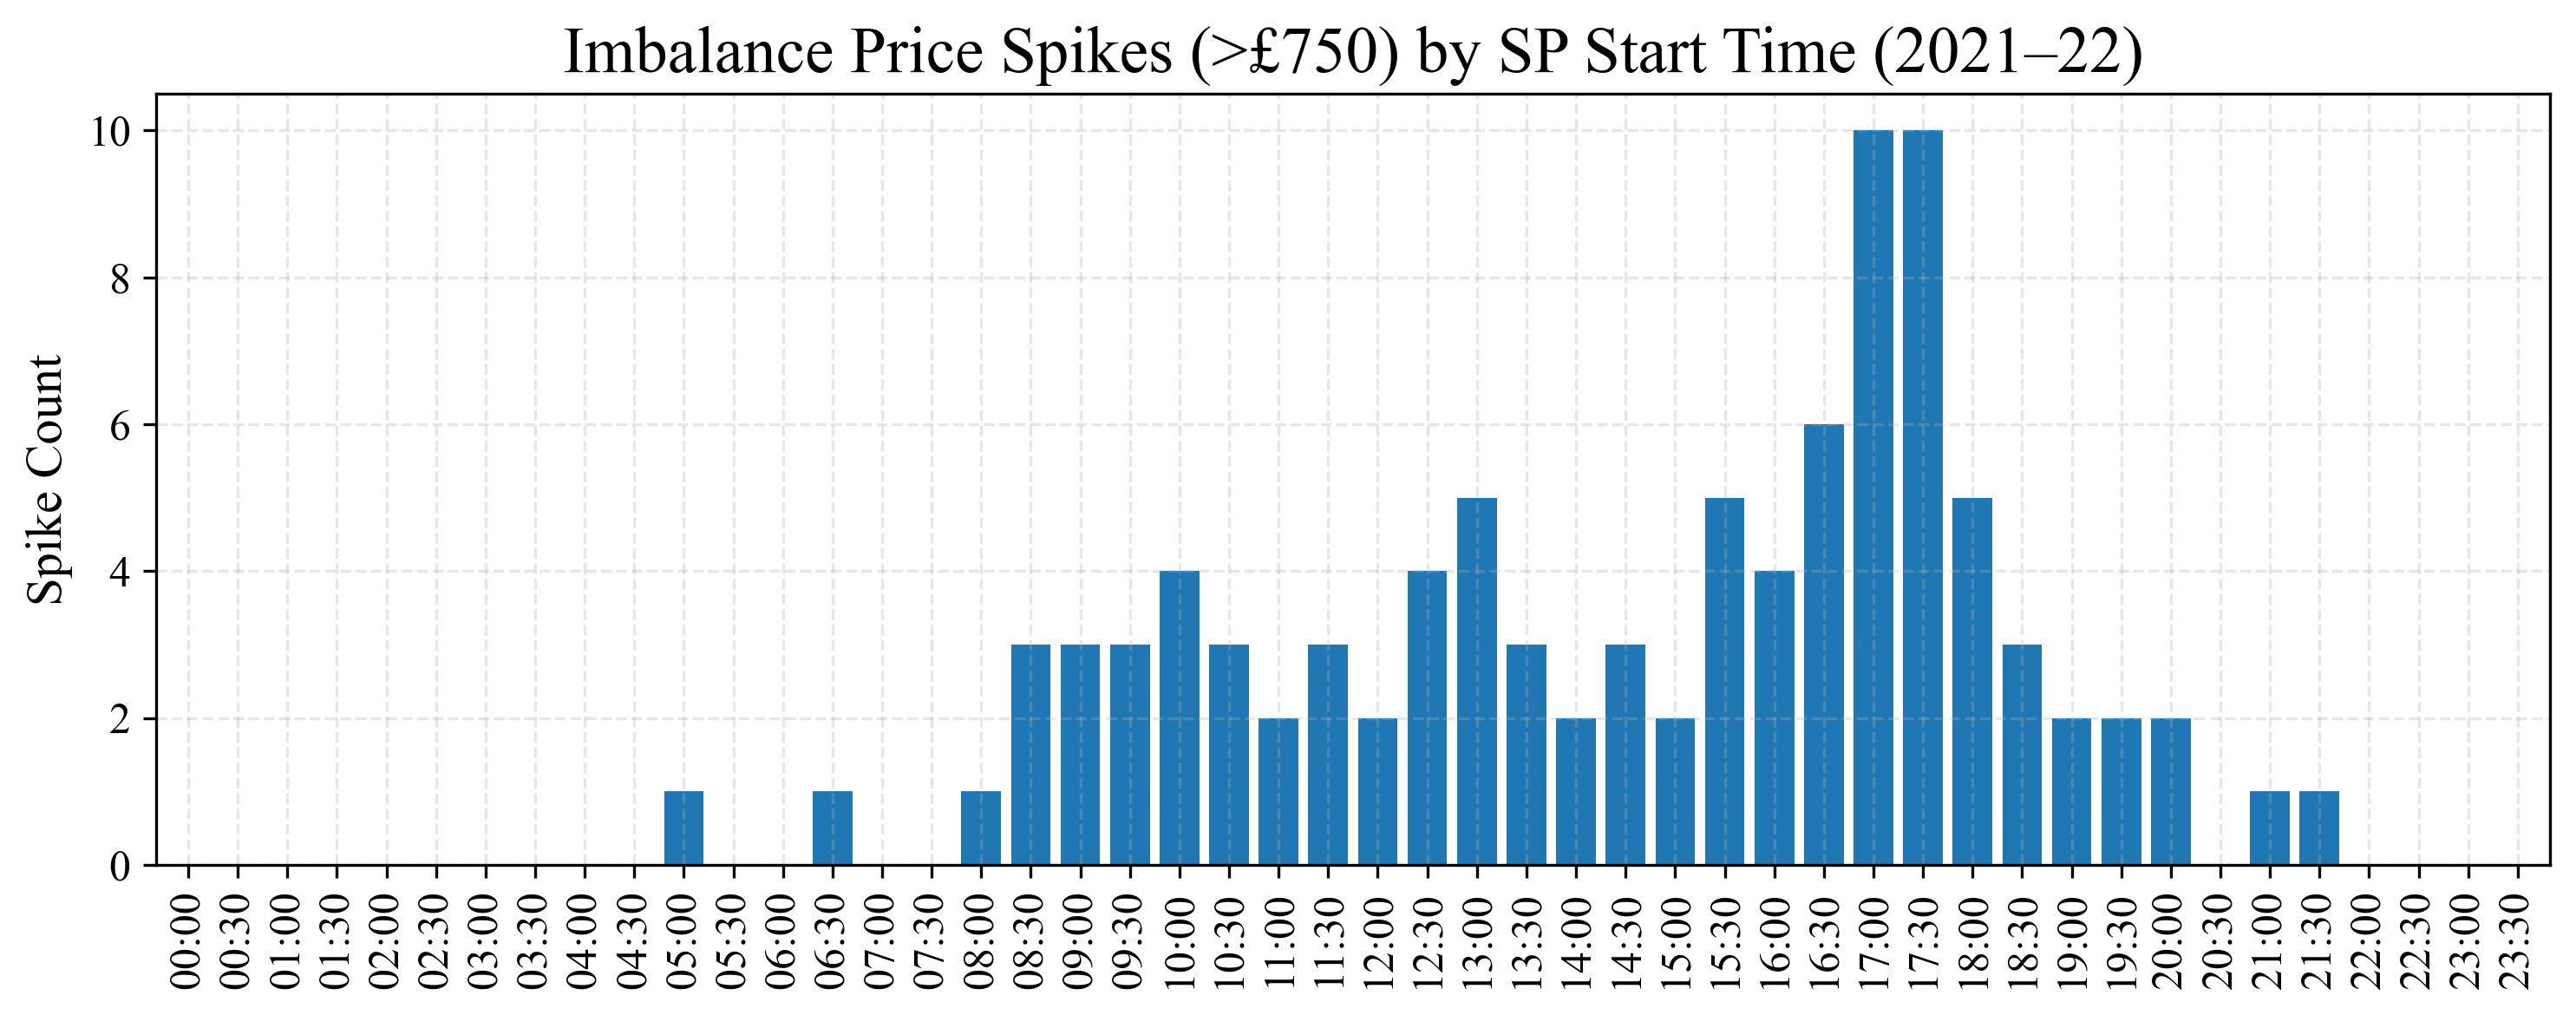

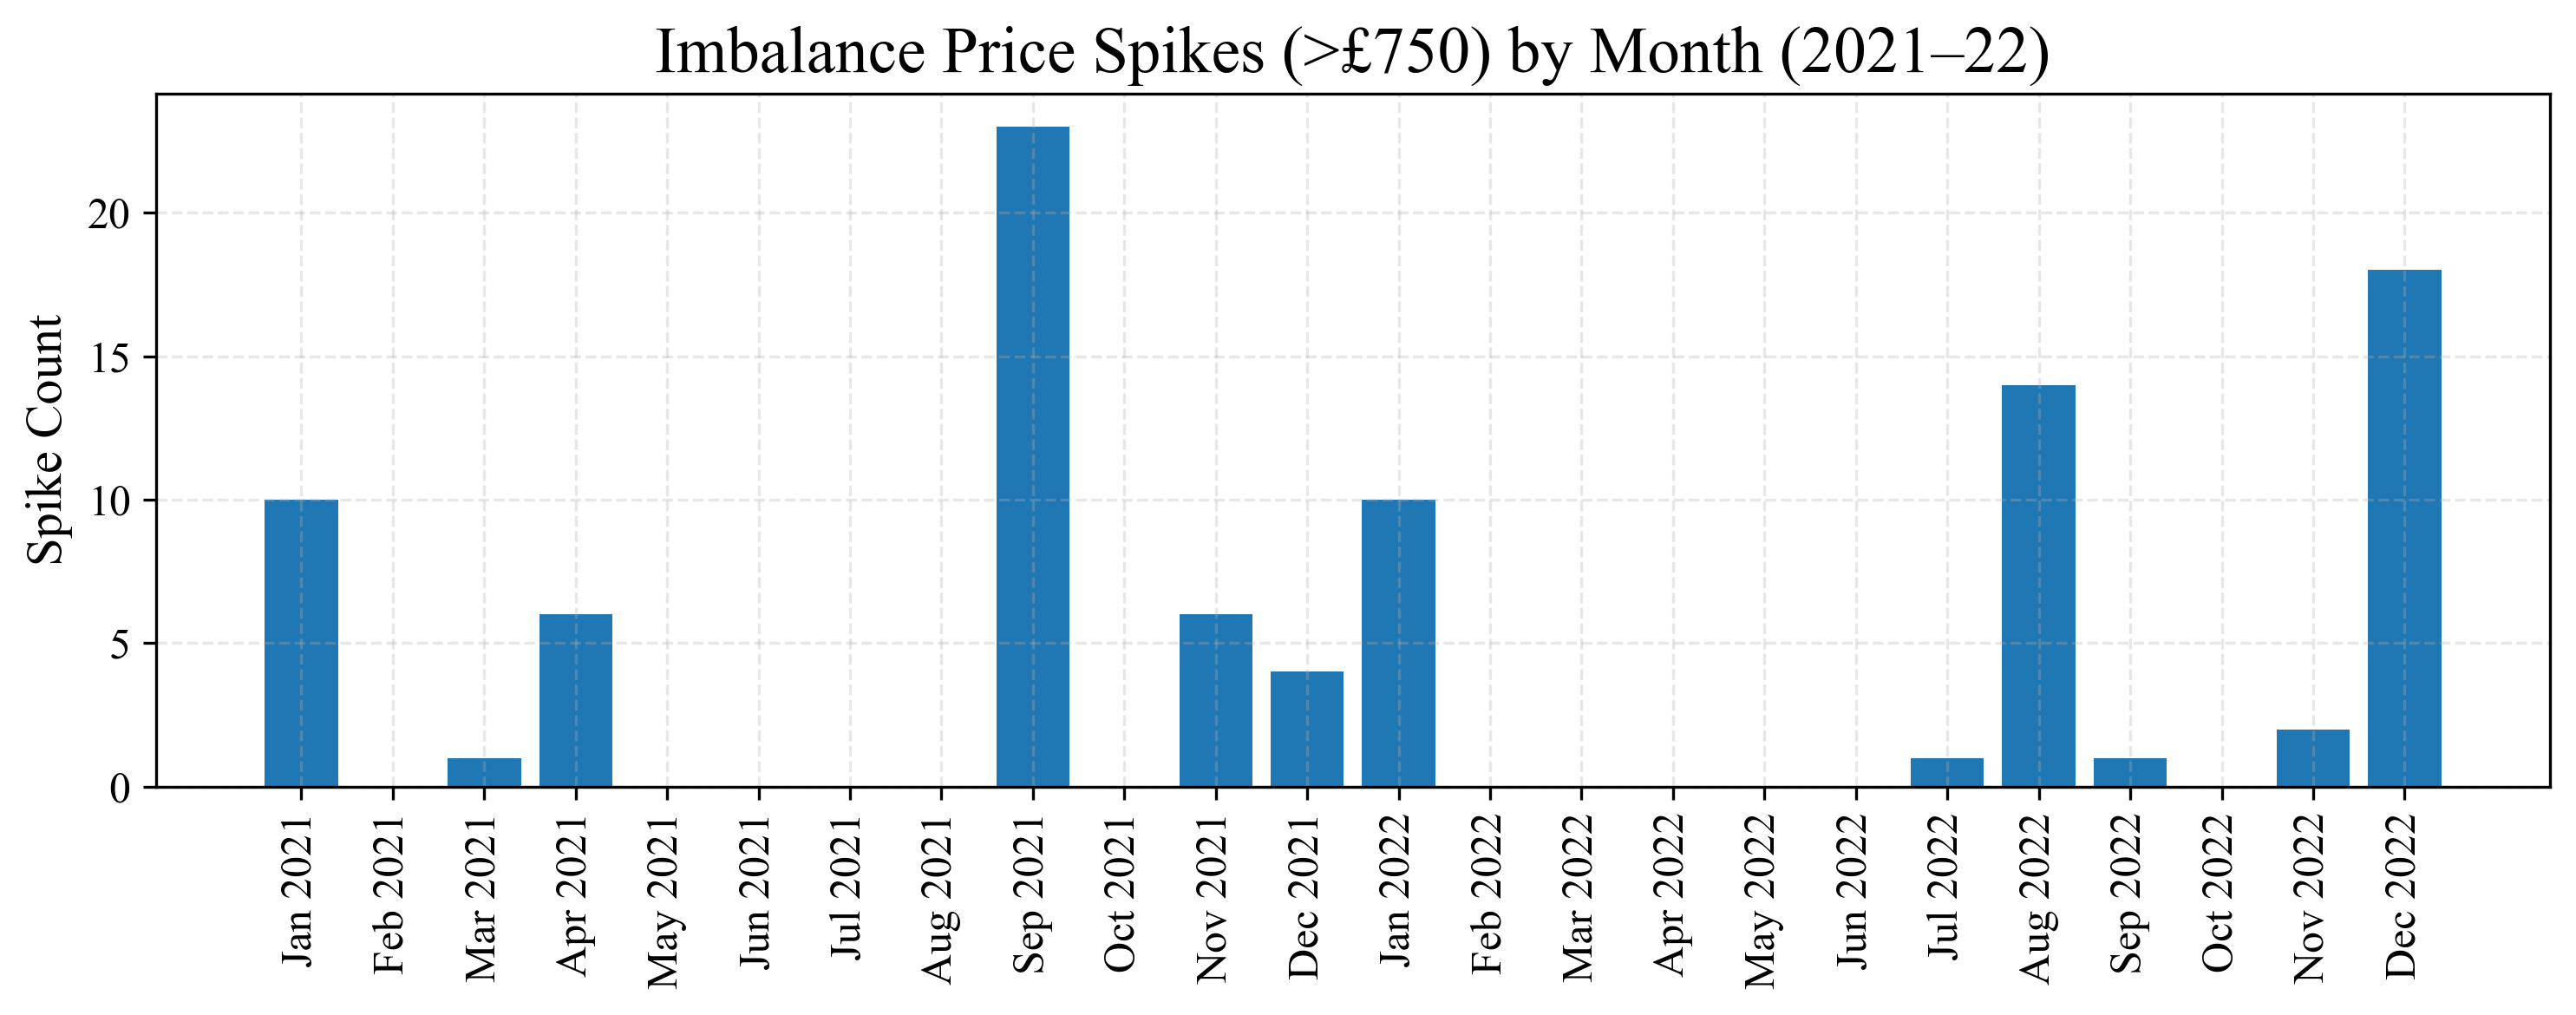

In [20]:
time_bins = pd.date_range("00:00", "23:30", freq="30min").strftime("%H:%M")

times = spikes.index.strftime("%H:%M")
time_counts = times.value_counts().reindex(time_bins, fill_value=0)

plt.figure(figsize=(10, 4), dpi=300)
time_counts.plot(kind="bar", width=0.8)
plt.xticks(rotation=90)
plt.ylabel("Spike Count")
plt.title(f"Imbalance Price Spikes (>£{threshold}) by SP Start Time (2021–22)")
plt.tight_layout()
plt.show()


month_counts = spikes.resample('ME').size()
month_labels = month_counts.index.strftime('%b %Y')

plt.figure(figsize=(10, 4))
plt.bar(month_labels, month_counts, width=0.8)
plt.xticks(rotation=90)
plt.ylabel("Spike Count")
plt.title(f"Imbalance Price Spikes (>£{threshold}) by Month (2021–22)")
plt.tight_layout()
plt.show()

### Price vs. Volume

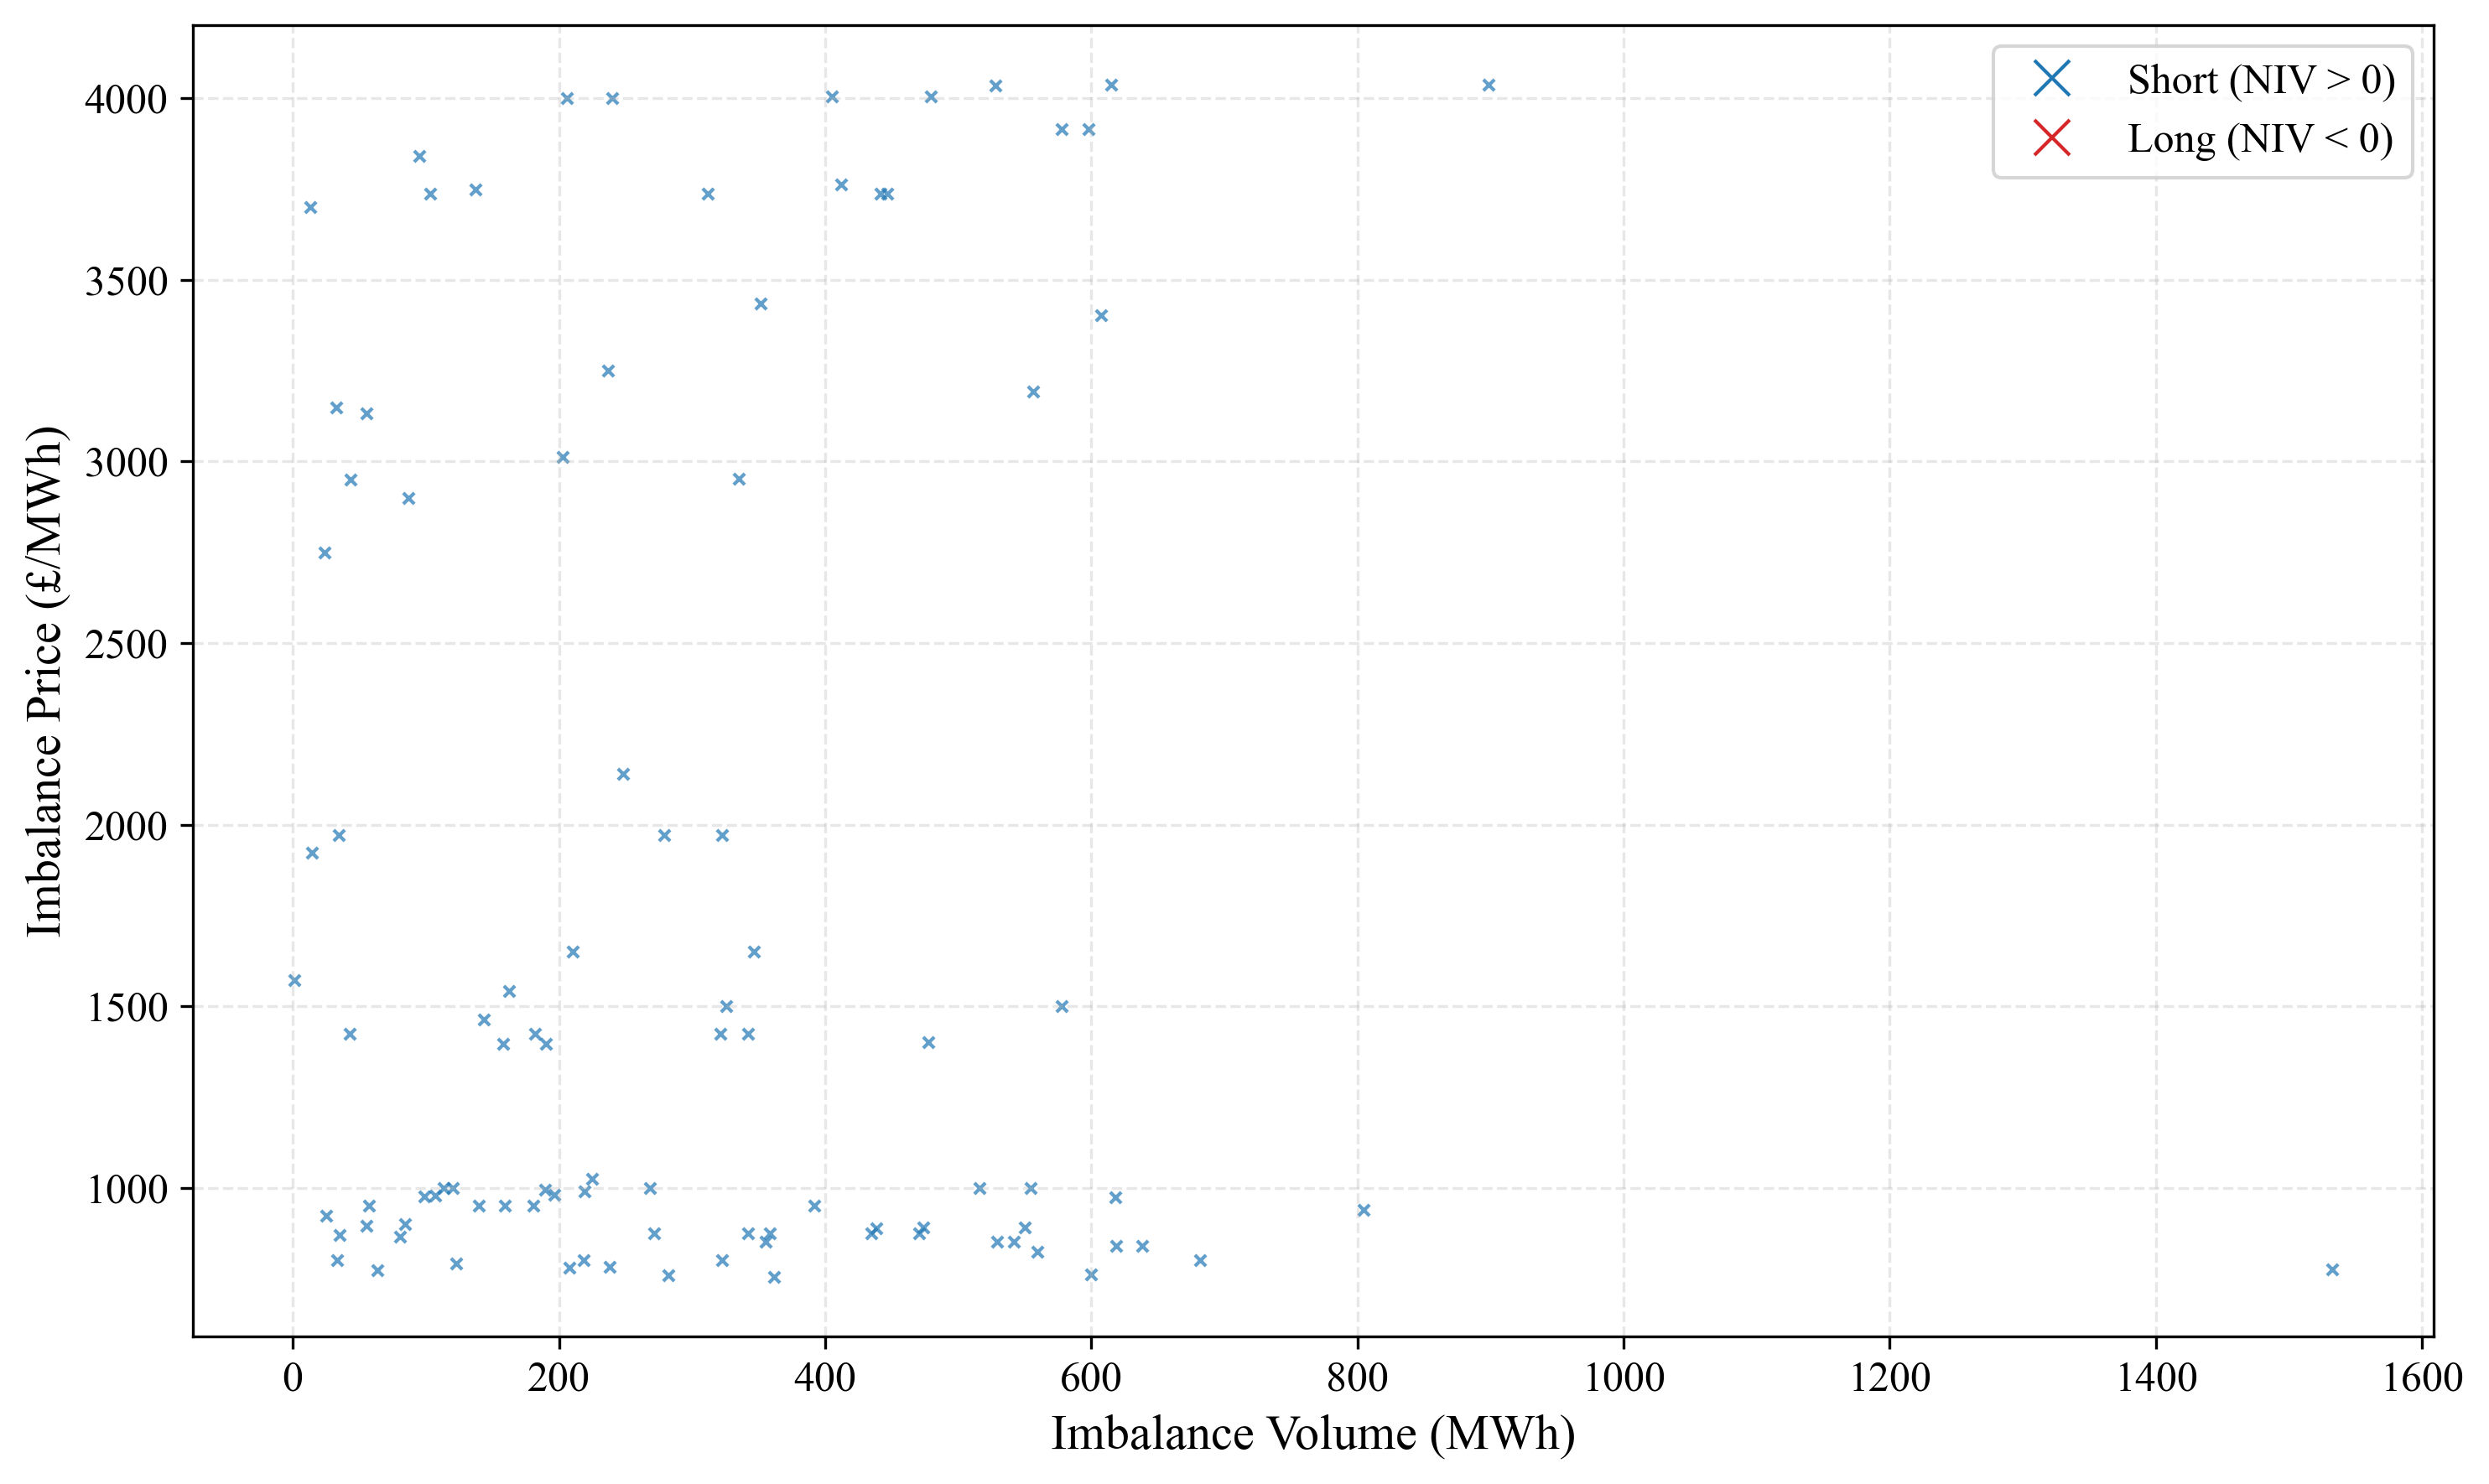

In [21]:
spikes_volume = spikes["Imbalance Volume"]
spikes_price = spikes["Imbalance Price"]
neg_mask = spikes_volume < 0

# 1) Full scatter with coloured markers
plt.figure(figsize=(10, 6))
plt.scatter(spikes_volume[~neg_mask], spikes_price[~neg_mask], alpha=0.7, marker='x', s=10, linewidths=1)
plt.scatter(spikes_volume[neg_mask],  spikes_price[neg_mask],  alpha=0.7, marker='x', s=10, linewidths=1, color='tab:red')

# Custom legend with larger markers
legend_handles = [
    Line2D([0], [0], marker='x', color='tab:blue', markersize=10, linestyle='None', label="Short (NIV > 0)"),
    Line2D([0], [0], marker='x', color='tab:red',  markersize=10, linestyle='None', label="Long (NIV < 0)")
]
plt.legend(handles=legend_handles)

plt.ylabel("Imbalance Price (£/MWh)")
plt.xlabel("Imbalance Volume (MWh)")
plt.tight_layout()
plt.show()

### Scatter Plots for Price vs. Wind and DRM

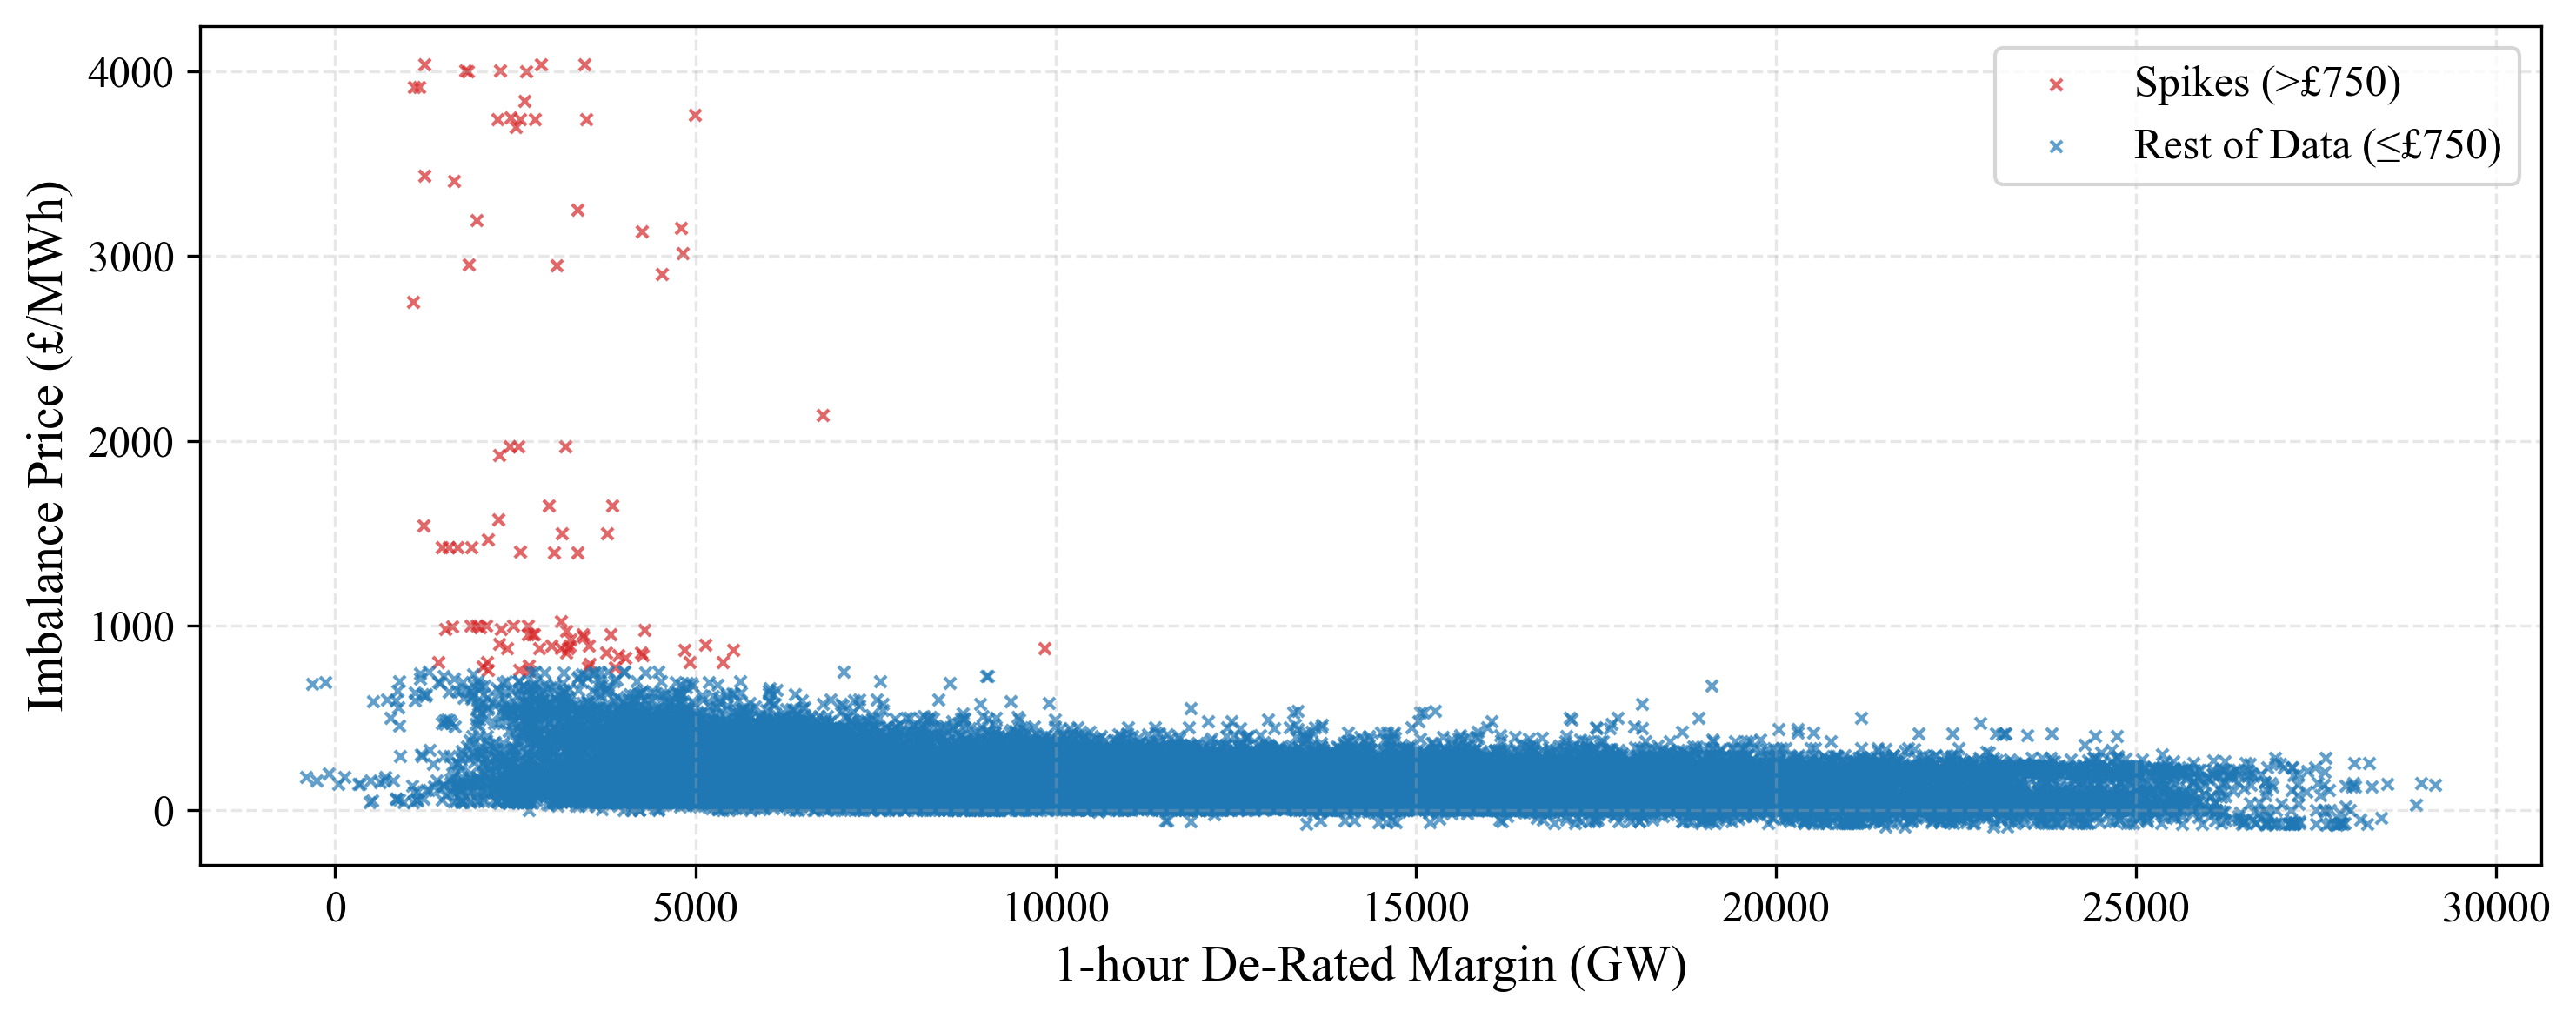

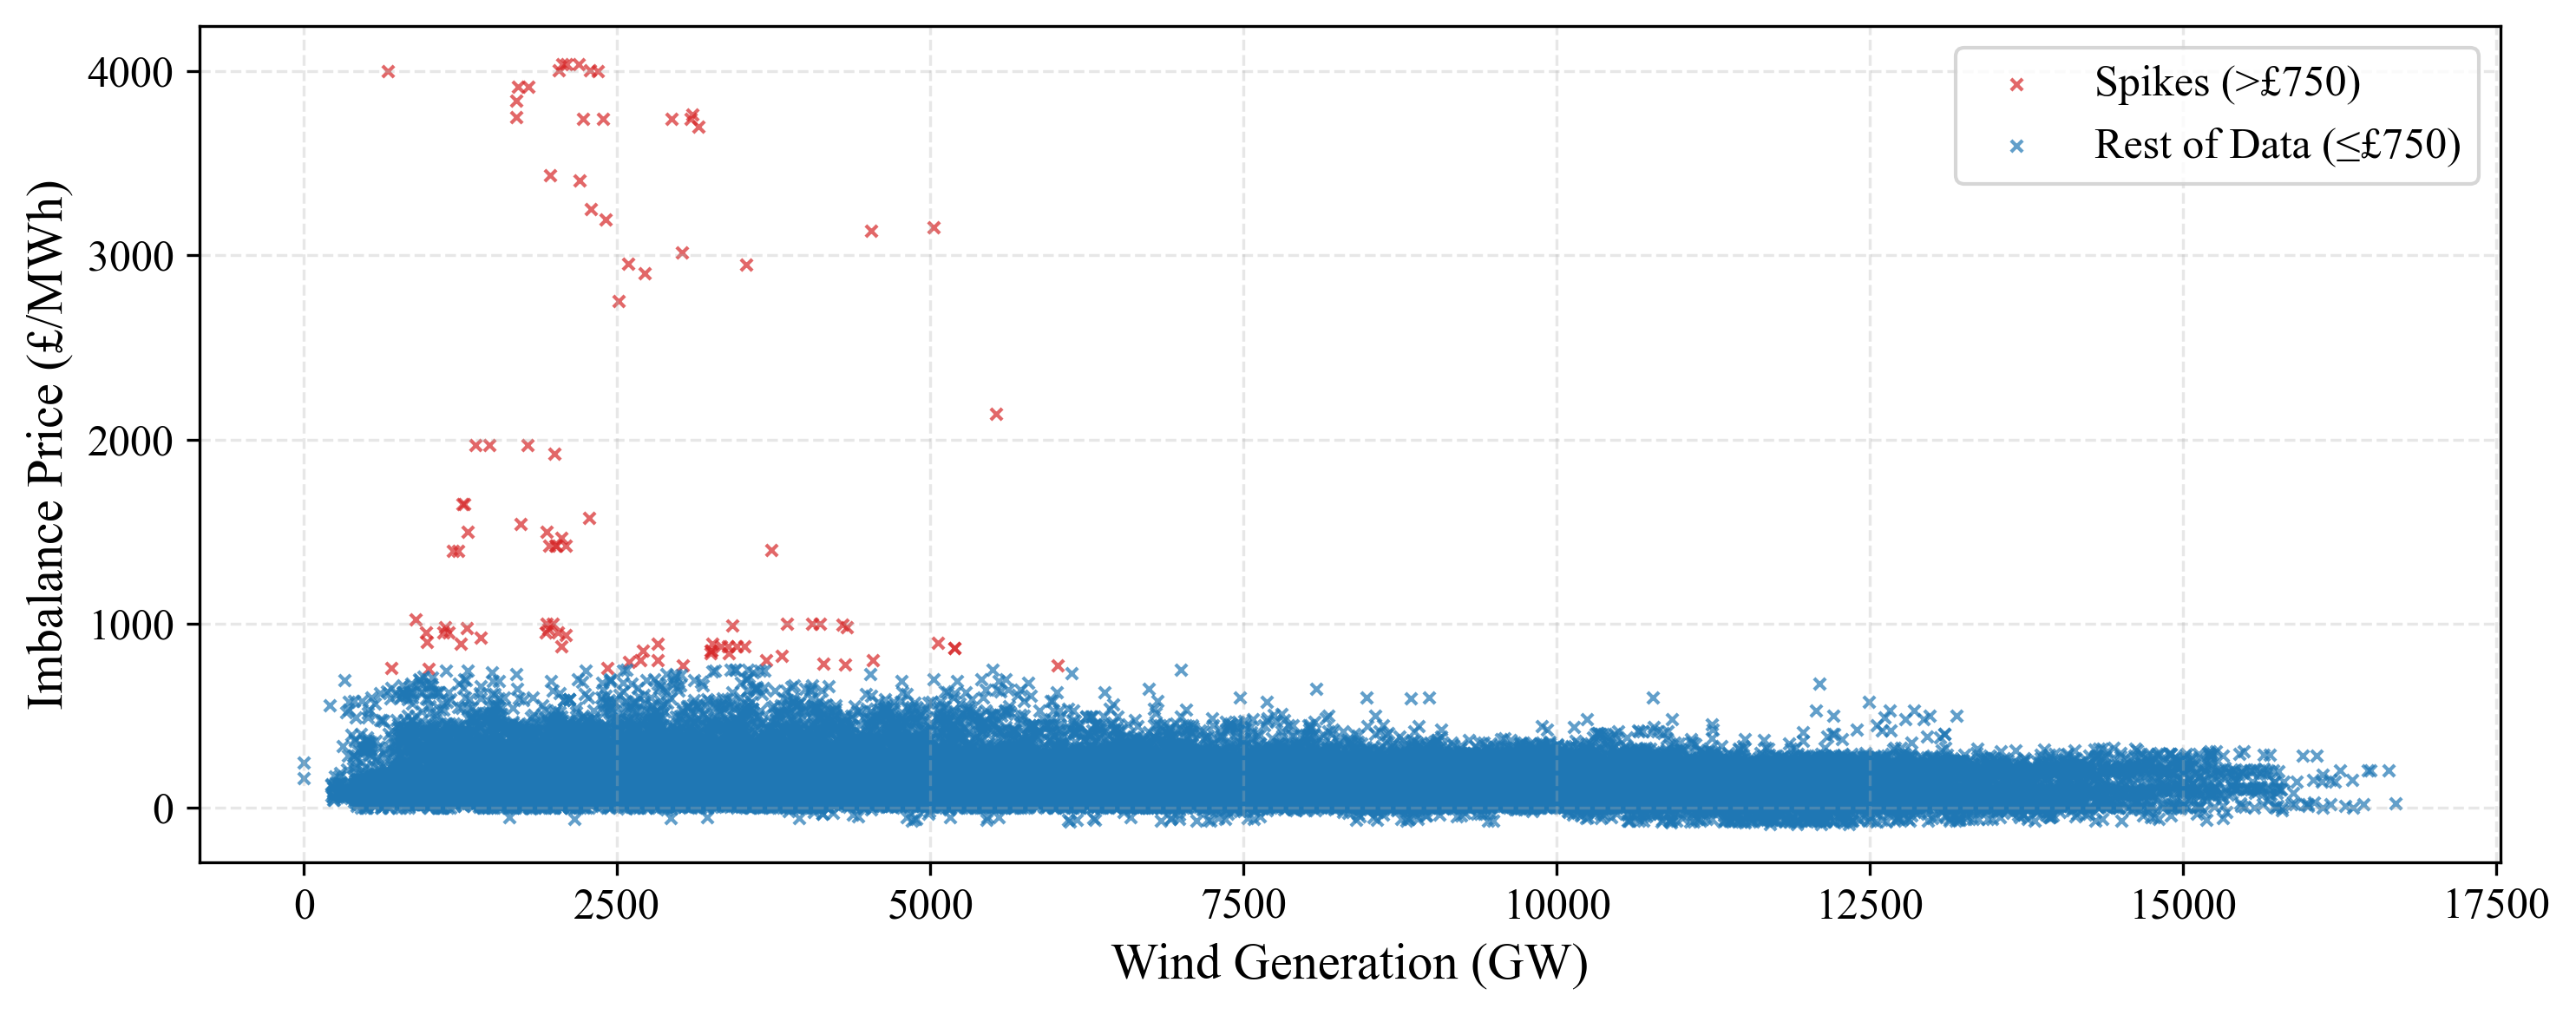

In [22]:
spikes_drm = spikes["De-Rated Margin (1h)"]
spikes_act_wind = spikes["Actual Wind"]
spikes_price = spikes["Imbalance Price"]

rest_drm   = rest["De-Rated Margin (1h)"]
rest_act_wind = rest["Actual Wind"]
rest_price = rest["Imbalance Price"]

plt.figure(figsize=(10, 4))
plt.scatter(spikes_drm, spikes_price, alpha=0.7, marker='x', s=10, linewidths=1, color='tab:red',   label=spikes_label)
plt.scatter(rest_drm, rest_price, alpha=0.7, marker='x', s=10, linewidths=1, color='tab:blue', label=rest_label)

plt.xlabel("1-hour De-Rated Margin (GW)")
plt.ylabel("Imbalance Price (£/MWh)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.scatter(spikes_act_wind, spikes_price, alpha=0.7, marker='x', s=10, linewidths=1, color='tab:red',   label=spikes_label)
plt.scatter(rest_act_wind, rest_price, alpha=0.7, marker='x', s=10, linewidths=1, color='tab:blue', label=rest_label)
plt.xlabel("Wind Generation (GW)")
plt.ylabel("Imbalance Price (£/MWh)")
plt.legend()
plt.tight_layout()
plt.show()



### Boxplots for DRM and Wind

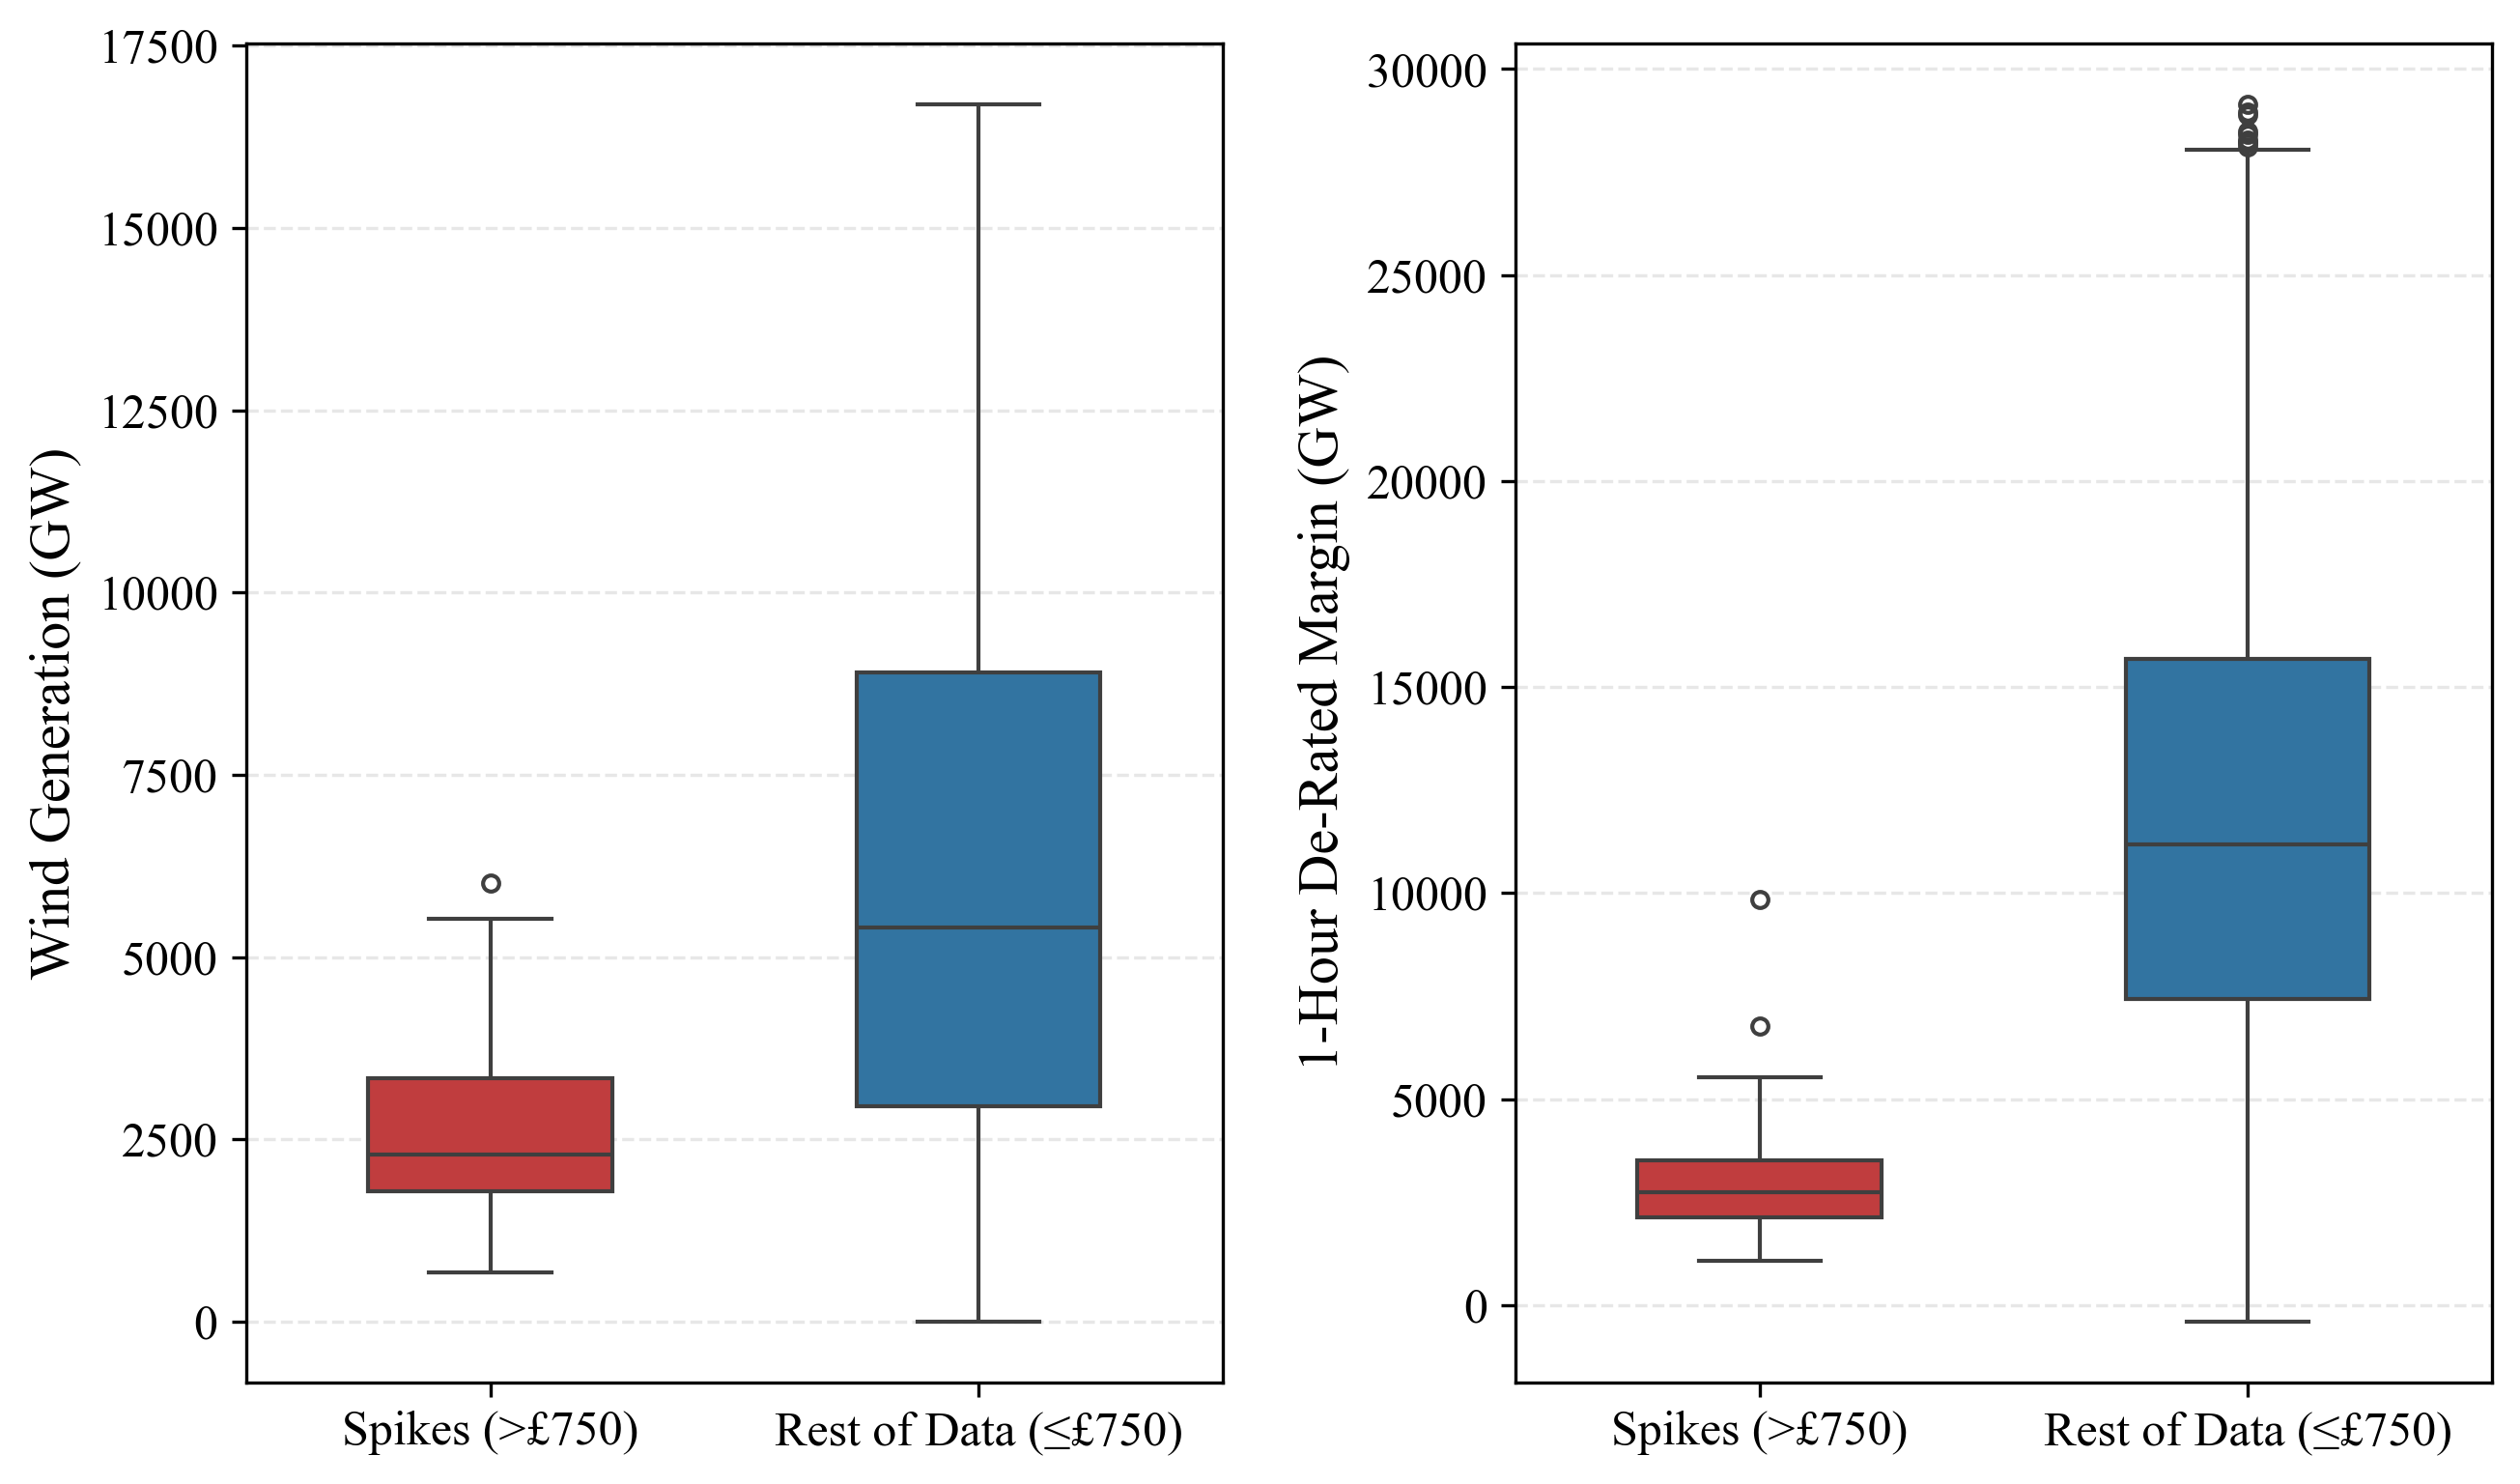

In [23]:
df_wind = pd.concat([
    rest_act_wind.rename("Wind Generation (GW)").to_frame().assign(Period=rest_label),
    spikes_act_wind.rename("Wind Generation (GW)").to_frame().assign(Period=spikes_label),
])
df_drm = pd.concat([
    rest_drm.rename("1-Hour De-Rated Margin (GW)").to_frame().assign(Period=rest_label),
    spikes_drm.rename("1-Hour De-Rated Margin (GW)").to_frame().assign(Period=spikes_label),
])

fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=300)
fig.subplots_adjust(wspace=.3)

sns.boxplot(
    data=df_wind,
    x="Period",
    y="Wind Generation (GW)",
    hue="Period",
    palette=["tab:red", "tab:blue"],
    order=[spikes_label, rest_label],
    hue_order=[spikes_label, rest_label],
    showfliers=True,
    fliersize=4,
    linewidth=1,
    width=0.5,
    ax=axes[0],
    legend=False
)
axes[0].set_xlabel("")
axes[0].set_ylabel("Wind Generation (GW)")

sns.boxplot(
    data=df_drm,
    x="Period",
    y="1-Hour De-Rated Margin (GW)",
    hue="Period",
    palette=["tab:red", "tab:blue"],
    order=[spikes_label, rest_label],
    hue_order=[spikes_label, rest_label],
    showfliers=True,
    fliersize=4,
    linewidth=1,
    width=0.5,
    ax=axes[1],
    legend=False
)
axes[1].set_xlabel("")
axes[1].set_ylabel("1-Hour De-Rated Margin (GW)")

plt.show()


### Correlation Matrix

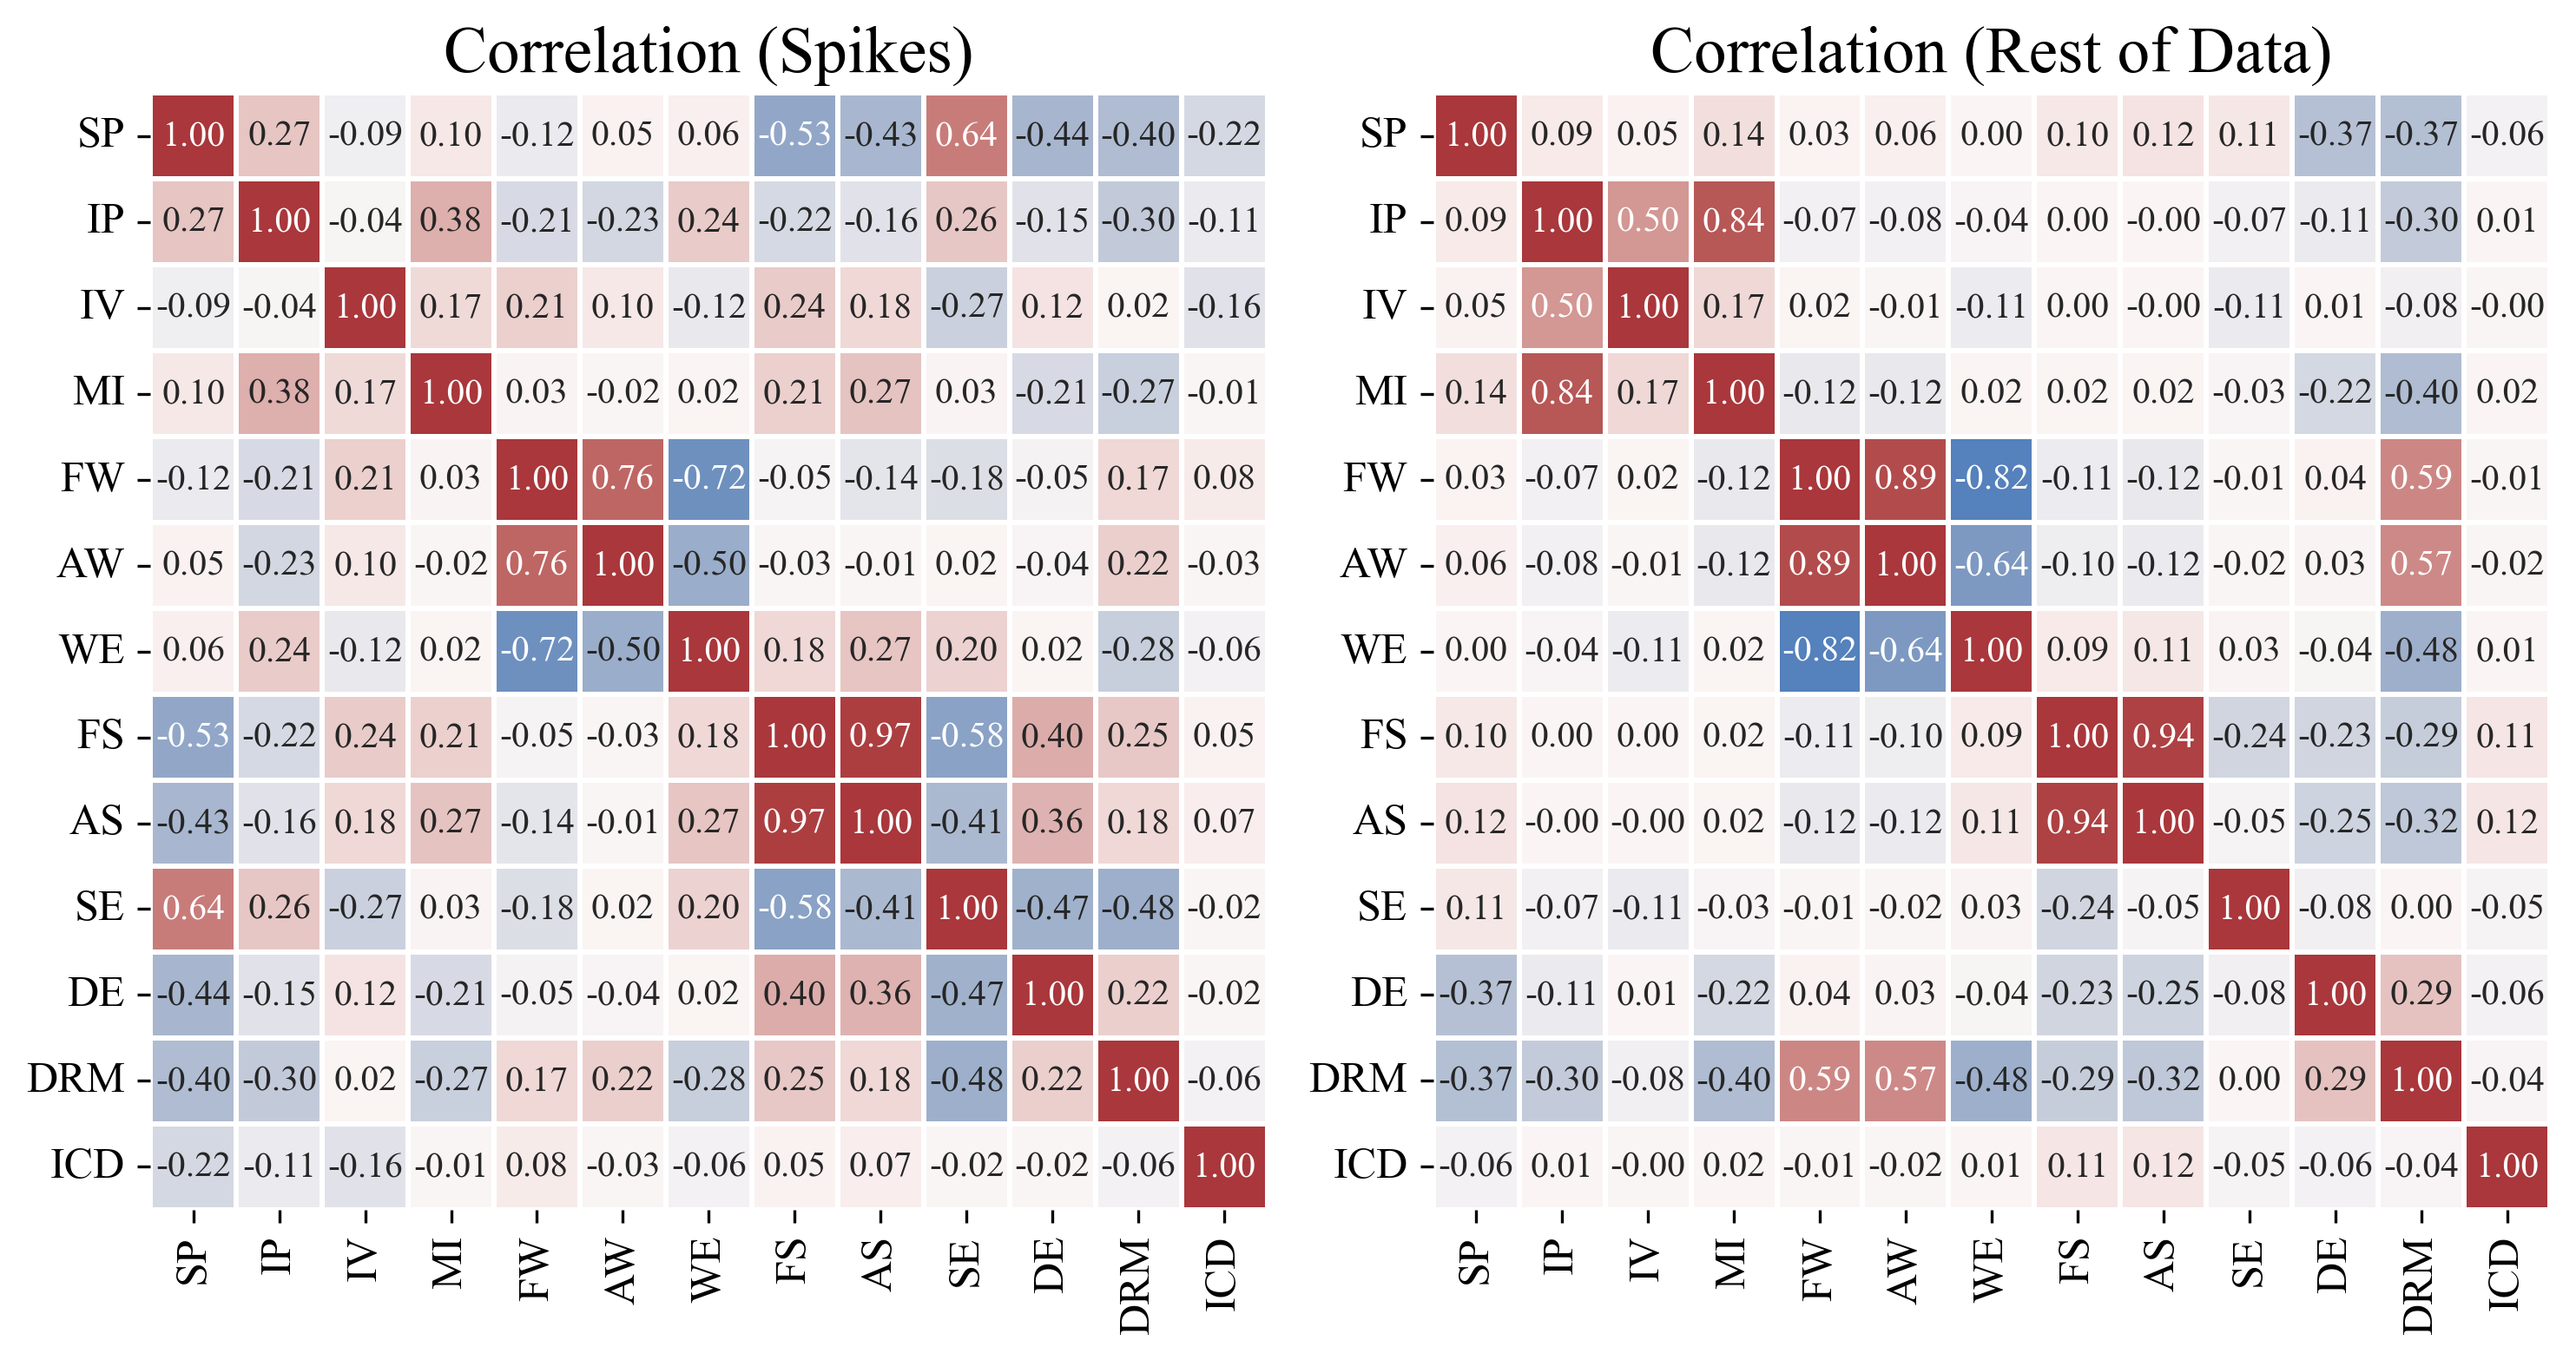

In [25]:
labels={
    "Settlement Period":     "SP",
    "Imbalance Price":      "IP",
    "Imbalance Volume":     "IV",
    "Market Index":         "MI",
    "Forecast Wind":        "FW",
    "Forecast Solar":       "FS",
    "Actual Wind":          "AW",
    "Actual Solar":         "AS",
    "Wind Error":           "WE",
    "Solar Error":          "SE",
    "Demand Error":         "DE",
    "De-Rated Margin (1h)": "DRM",
    "Inter Delta":          "ICD"
}

spikes_ren = spikes.rename(columns=labels, index=labels)
rest_ren   = rest.rename(columns=labels, index=labels)

corr_spike = spikes_ren.corr(method='spearman')
corr_rest  = rest_ren.corr(method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=300)
for ax, corr, title in zip(axes, [corr_spike, corr_rest], ['Correlation (Spikes)','Correlation (Rest of Data)']):
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0, cbar=False, ax=ax, square=True, linewidths=1)
    ax.set_title(title)
    ax.grid(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()
